In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.cuda.amp as amp
import torch.optim as optim
from torchvision.ops import *
from torchvision.models import *
from torchsummary import summary
from matplotlib import pyplot as plt
# import bitsandbytes as bnb
import numpy as np
import pandas as pd
import scipy.stats
import os
import time
import copy
import random
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

!nvidia-smi

# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device('cuda:0')
# device1 = torch.device('cuda:1')
print(torch.cuda.is_available())

Fri Jun 21 07:26:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| 31%   41C    P0             40W /  285W |     788MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import time
import math
import random
import numpy as np
import pandas as pd
from tqdm import *
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

def split_targets(targets):
    cores = cpu_count()
    part = len(targets)//cores
    
    parts = []
    for i in range(cores-1):
        temp = targets[i*part: (i+1)*part]
        parts.append(temp)
    parts.append(targets[(i+1)*part:])
    return parts, cores
    
# Gather Expression dataset
def GenData(paras):  # (gene_part, sub_tf, sub_tf_exp, genesexp_part, sub_gold, time_lag)
    error = 0
    all_tf, all_target = [], []
    gene_pair, exp_pair, labels = [], [], []
    tfs, targets, exp, gold, core = paras
    
    if core == 1:
        for i in trange(len(tfs)):
            tf = tfs[i]
            tf_exp = exp[tf]
            for target in targets:
                target_exp = exp[target]
                relation = [tf, target]
                gene_pair.append(relation)
                exp_pair.append(np.vstack((tf_exp, target_exp)))
                if relation in gold:
                    labels.append(1)
                else:
                    labels.append(0)
    else:
        for tf in tfs:
            tf_exp = exp[tf]
            for target in targets:
                target_exp = exp[target]
                relation = [tf, target]
                gene_pair.append(relation)
                exp_pair.append(np.vstack((tf_exp, target_exp)))
                if relation in gold:
                    labels.append(1)
                else:
                    labels.append(0)
    return (gene_pair, exp_pair, labels)

def processing(tf_raw, gene_raw, exp, gold):
    print('Multi-core processing...')
    start = time.time()
    if __name__ == '__main__':
        tf = np.intersect1d(tf_raw, gold[:,0].reshape(-1,))
        targets = np.intersect1d(gene_raw, gold[:,1].reshape(-1,))
        print('num of tfs:', len(tf), 'num of targets:', len(targets))
        
        # targets_part, cores = split_targets(targets) 
        # gene_pair, all_exp, all_labels = [], [], []
        # p = ProcessPoolExecutor(max_workers=cores)
        # process = [p.submit(GenData, (tf, targets_part[i], exp, gold.tolist(), i)) for i in range(cores)]
        # p.shutdown()
        # for j in range(cores):
        #     results = process[j].result()
        #     gene_pair.extend(results[0])
        #     all_exp.extend(results[1])
        #     all_labels.extend(results[2])

        gene_pair, all_exp, all_labels = GenData((tf, targets, exp, gold.tolist(), 1))

        end = time.time()
        RuningTime = end - start
        print('multiprocessing Done! Runing Time:', round(RuningTime / 60, 2), 'sec')

    return gene_pair, all_exp, all_labels

def split_datasets(labels):
    print('labels', np.sum(labels))
    pos_index, neg_index = [], []
    pos_index = [index for index, value in enumerate(labels) if value == 1]
    neg_index = [index for index, value in enumerate(labels) if value == 0]
    pos_shuffle, neg_shuffle = random.sample(pos_index, len(pos_index)), random.sample(neg_index, len(neg_index))
    pos_part, neg_part = len(pos_shuffle) // 5, len(neg_shuffle) // 5
    pos_train, neg_train = pos_shuffle[ :3*pos_part], neg_shuffle[ :3*neg_part]
    pos_val, neg_val = pos_shuffle[3*pos_part : 4*pos_part], neg_shuffle[3*neg_part : 4*neg_part]
    pos_test, neg_test = pos_shuffle[4*pos_part: ], neg_shuffle[4*neg_part: ]
    train_index = pos_train + neg_train
    val_index = pos_val + neg_val
    test_index = pos_test + neg_test

    return train_index, val_index, test_index



# Gather Expression dataset
class Feeder(Dataset):
    def __init__(self, exp_data, label, patch_size, mode='pretrain', base=128):
        assert mode=='pretrain' or mode=='lincls', 'mode should in [pretrain, lincls]'

        self.exp_data = exp_data[:, :, :exp_data.shape[-1]-exp_data.shape[-1] % patch_size]
        self.label = label
        self.arange = np.arange(exp_data.shape[-1])

    def __len__(self):
        return len(self.label)
        
    def __getitem__(self, index):
        
        tf, target = copy.deepcopy(self.exp_data[index][0]), copy.deepcopy(self.exp_data[index][1])
        label = self.label[index]
        
        X = np.concatenate([tf.reshape(1,-1), target.reshape(1,-1)], axis=0).astype(np.float16)
        return X, label
    
batch_size = 512
patch_size = 8

ExpressionData = pd.read_csv('../Benchmark Dataset/Non-Specific Dataset/hESC/TFs+1000/BL--ExpressionData.csv', index_col=0, engine='c')
network = pd.read_csv('../Benchmark Dataset/Non-Specific Dataset/hESC/TFs+1000/Label.csv', index_col=0, engine='c').values
tfs_raw = pd.read_csv('../Benchmark Dataset/Non-Specific Dataset/hESC/TFs+1000/TF.csv', index_col=0, engine='c')['index'].values.tolist()
targets_raw = pd.read_csv('../Benchmark Dataset/Non-Specific Dataset/hESC/TFs+1000/Target.csv', index_col=0, engine='c')['index'].values.tolist()

gene_pair, all_exp, labels = processing(tfs_raw, targets_raw, ExpressionData.values, network)

data = Feeder(np.array(all_exp), labels, patch_size, 'pretrain')
loader = DataLoader(data, batch_size=batch_size, shuffle=True)
labels_unique, counts = np.unique(labels, return_counts=True)
class_weight = [sum(counts)/i for i in counts]
print('labels', np.sum(labels), 'postive VS negative:', class_weight, 'Density:', round(class_weight[0]/sum(class_weight), 3))

Multi-core processing...
num of tfs: 292 num of targets: 1138


100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [01:52<00:00,  2.61it/s]


multiprocessing Done! Runing Time: 1.87 sec
labels 4617 postive VS negative: [1.014090008819607, 71.97227636993719] Density: 0.014


In [3]:
# classes
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
import math
        
def SinCosEmbed(seq_len, d_model, max_len=5000):
    pe = torch.zeros(max_len, d_model).float()
    pe.require_grad = False
    
    position = torch.arange(0, max_len).float().unsqueeze(1)
    div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)
    return pe[:, :seq_len, :d_model]

class PosEmb(nn.Module):
    def __init__(self, num, dim, emb_dropout):
        super().__init__()
        self.num = num
        self.dropout = nn.Dropout(emb_dropout)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_emd = nn.Parameter(SinCosEmbed(num+1, dim), requires_grad=False)
    
    def forward(self, x):
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((x, cls_tokens), dim=1)
        return x + self.dropout(self.pos_emd)
        
class Logits(nn.Module):
    def __init__(self, cls_token=False):
        super().__init__()
        self.cls_token = cls_token
    def forward(self, x):
        out = x[:, -1] if self.cls_token else x.mean(dim = 1)
        return out

class MAE(nn.Module):
    def __init__(
                self,*,
                seq_len, 
                channels,
                patch_size,   
                dim = 192, 
                heads = 12,
                mlp_ratio = 4,
                cls_token = True,
                emded_grad = True,
                masking_ratio = 0.7,
                # encodoer paraments
                encoder_depth = 2, 
                dropout = .2, 
                emb_dropout = 0.,
                # decoder paraments
                decoder_depth = 2, 
                ):
        super().__init__()
        assert (seq_len % patch_size) == 0, 'seq_len must be divisible by patch_size'
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'

        self.dim = dim
        self.cls = cls_token
        self.logits = Logits(cls_token)
        self.masking_ratio = masking_ratio
        num_patches = seq_len // patch_size * channels
        self.to_patch = Rearrange('b c (n p) -> b (c n) p', p = patch_size)
        
        self.patch_to_emb = nn.Sequential(
                                            # nn.LayerNorm(patch_size),
                                            nn.Linear(patch_size, dim, bias=False),
                                            nn.LayerNorm(dim),
                                            PosEmb(num_patches, dim, emb_dropout),
                                            )
        # xavier_uniform initialization
        nn.init.xavier_uniform_(self.patch_to_emb[0].weight)
        self.patch_to_emb[0].weight.requires_grad = emded_grad
                
        self.ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(emb_dropout)
        
        # extract some hyperparameters and functions from encoder
        EncoderLayer = nn.TransformerEncoderLayer(d_model=dim, 
                                                    nhead=heads,
                                                    dim_feedforward=int(dim*mlp_ratio),
                                                    dropout=dropout, 
                                                    activation='gelu',
                                                    # layer_norm_eps=1e-3,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    )
        self.encoder = nn.TransformerEncoder(EncoderLayer, num_layers=encoder_depth)
        
        # decoder parameters
        self.mask_token = nn.Parameter(torch.randn(dim))
        DecoderLayer = nn.TransformerEncoderLayer(d_model=dim, 
                                                    nhead=heads,
                                                    dim_feedforward=int(dim*mlp_ratio),
                                                    dropout=dropout, 
                                                    activation='gelu',
                                                    # layer_norm_eps=1e-3,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    )
        self.decoder = nn.TransformerEncoder(DecoderLayer, num_layers=decoder_depth)
        self.decoder_pos_emb = nn.Parameter(SinCosEmbed(num_patches+1, dim), requires_grad=False) if self.cls else nn.Parameter(SinCosEmbed(num_patches, dim), requires_grad=False)
        
        self.to_seqs = nn.Linear(dim, patch_size)
        
        # MSE and Cosine Similarity Loss 
        self.loss = nn.MSELoss()
        self.criterion = nn.CosineSimilarity(dim=1)

    # Modify cross entropy (CE) as: -softmax(z)*log(softmax(p))
    def CE(self, p, z):
        return - (z.softmax(dim=1) * p.log_softmax(dim=1)).mean()

    def ContrastiveLoss(self, p, z, T=.07):
        # normalize
        p = nn.functional.normalize(p, dim=1)
        z = nn.functional.normalize(z, dim=1)
        # Einstein sum is more intuitive
        logits = torch.einsum('nc,mc->nm', [p, z]) / T
        labels = torch.arange(logits.shape[0], dtype=torch.long, device=logits.device)
        return nn.CrossEntropyLoss()(logits, labels)

    def forward(self, series):
        device = series.device

        # get patches
        patches = self.to_patch(series)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions
        tokens = self.patch_to_emb(patches)

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked
        num_masked = int(self.masking_ratio * num_patches)

        batch_range = torch.arange(batch, device=device)[:, None]
        if self.cls:
            rand_indices = torch.rand(batch, num_patches+1, device=device)
            rand_indices[:, -1] = 1e+7
            rand_indices = rand_indices.argsort(dim = -1)
        else:
            rand_indices = torch.rand(batch, num_patches, device=device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # target feature
        z = tokens[batch_range, masked_indices]
        z = self.encoder(z).mean(dim=1)
        
        # get the unmasked tokens to be encoded
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss
        masked_patches = patches[batch_range, masked_indices]
        
        # attend with transformer
        encoded_tokens = self.encoder(tokens)

        # project encoder to decoder dimensions, if they are not equal
        # encoded_tokens += self.decoder_pos_emb[:, unmasked_indices]
        encoded_tokens = self.ln(encoded_tokens) + self.decoder_pos_emb[:, unmasked_indices]
            
        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above
        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb[:, masked_indices]
        
        
        # concat the masked tokens to the decoder tokens
        if self.cls:
            decoder_tokens = torch.zeros(batch, num_patches+1, self.dim, device=device)
        else:
            decoder_tokens = torch.zeros(batch, num_patches, self.dim, device=device)
        
        decoder_tokens[batch_range, unmasked_indices] = encoded_tokens
        decoder_tokens[batch_range, masked_indices] = mask_tokens

        # attend with decoder
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the pred_features and pred_values
        mask_tokens = decoded_tokens[batch_range, masked_indices]
        pred_values = self.to_seqs(mask_tokens)
        p = mask_tokens.mean(dim=1)

        # calculate reconstruction loss
        recon_loss = self.loss(pred_values, masked_patches)
        # criterion = - (z.detach().softmax(dim=1) * p.log_softmax(dim=1)).mean()
        criterion = -self.criterion(p, z.detach()).mean()
        # criterion = self.ContrastiveLoss(p, z.detach())
        
        return criterion + recon_loss
    
model = MAE(seq_len=data[0][0].shape[1], 
            channels=2, 
            patch_size=patch_size,
            cls_token=False,)

# define optimizer
opt = optim.AdamW(model.parameters())
scaler = amp.GradScaler()

# define function to training
def Training(model, num_epochs, opt=opt, data_dl=loader):
    loss_history = []
    start_time = time.time()
    path2weights = './models/SIGMA_hESC1000+Non-Specific.pt'
    best_loss = 1e+7
    
    # 模型输出和loss计算
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        model.train()
        running_loss = 0
        for i, (x, _) in enumerate(tqdm(data_dl)):
            # retrieve query and key`````
            x = x.float().to(device, non_blocking=True)
            # compute output and loss
            with amp.autocast():
                loss = model(x)
                if loss == torch.nan:
                    break
                opt.zero_grad()
            # compute gradient and do SGD step
                scaler.scale(loss).backward()
                scaler.step(opt)
                scale = scaler.get_scale()
                scaler.update()
#             loss.backward()
#             opt.step()
            running_loss += loss
            
        if loss == torch.nan:
            break
        # store loss history
        epoch_loss = running_loss / (i+1)
        loss_history.append(epoch_loss.detach().cpu().numpy())
        print('train loss: %.6f, time: %.2f min' %(epoch_loss,(time.time()-start_time)/60))
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = copy.deepcopy(model)

    # save weights
    torch.save(model.state_dict(), path2weights)
    best_encoder = nn.Sequential(copy.deepcopy(best_model.to_patch),
                            copy.deepcopy(best_model.patch_to_emb),
                            copy.deepcopy(best_model.encoder),
                            # copy.deepcopy(best_model.ln),
                            copy.deepcopy(best_model.logits))
    # projector = copy.deepcopy(encoder.spatial.fc)# .fc
    torch.cuda.empty_cache()  # 释放显存
    return best_encoder, loss_history

In [4]:
# create folder to save model weights
os.makedirs('./models', exist_ok=True)
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
# start training
num_epochs = 200
encoder, loss_history = Training(model.to(device), num_epochs=num_epochs)

Epoch 1/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:39<00:00,  6.53it/s]


train loss: 4.583928, time: 1.66 min
Epoch 2/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:38<00:00,  6.62it/s]


train loss: 3.540140, time: 3.29 min
Epoch 3/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:58<00:00,  5.48it/s]


train loss: 3.421810, time: 5.27 min
Epoch 4/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.20it/s]


train loss: 3.309430, time: 7.02 min
Epoch 5/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:37<00:00,  6.67it/s]


train loss: 3.206160, time: 8.64 min
Epoch 6/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:36<00:00,  6.73it/s]


train loss: 3.091584, time: 10.26 min
Epoch 7/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:51<00:00,  5.82it/s]


train loss: 2.975123, time: 12.12 min
Epoch 8/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:15<00:00,  4.78it/s]


train loss: 2.843737, time: 14.39 min
Epoch 9/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:46<00:00,  6.11it/s]


train loss: 2.718254, time: 16.16 min
Epoch 10/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:05<00:00,  5.18it/s]


train loss: 2.600653, time: 18.26 min
Epoch 11/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 2.500381, time: 20.33 min
Epoch 12/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.21it/s]


train loss: 2.407147, time: 22.41 min
Epoch 13/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 2.329974, time: 24.49 min
Epoch 14/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.21it/s]


train loss: 2.271718, time: 26.57 min
Epoch 15/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 2.208373, time: 28.65 min
Epoch 16/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.20it/s]


train loss: 2.157104, time: 30.73 min
Epoch 17/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 2.107545, time: 32.79 min
Epoch 18/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.21it/s]


train loss: 2.061449, time: 34.88 min
Epoch 19/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 2.024513, time: 36.95 min
Epoch 20/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:05<00:00,  5.20it/s]


train loss: 1.981237, time: 39.03 min
Epoch 21/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.950300, time: 41.11 min
Epoch 22/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.913619, time: 43.18 min
Epoch 23/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.875353, time: 45.26 min
Epoch 24/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.30it/s]


train loss: 1.847910, time: 47.30 min
Epoch 25/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.810079, time: 49.38 min
Epoch 26/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.781026, time: 51.44 min
Epoch 27/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.750242, time: 53.51 min
Epoch 28/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.714879, time: 55.58 min
Epoch 29/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.685347, time: 57.64 min
Epoch 30/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.30it/s]


train loss: 1.648417, time: 59.69 min
Epoch 31/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.622788, time: 61.74 min
Epoch 32/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.591404, time: 63.80 min
Epoch 33/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.559702, time: 65.88 min
Epoch 34/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.524443, time: 67.96 min
Epoch 35/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 1.499039, time: 70.01 min
Epoch 36/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.465173, time: 72.07 min
Epoch 37/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.442050, time: 74.13 min
Epoch 38/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.415489, time: 76.19 min
Epoch 39/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.392427, time: 78.26 min
Epoch 40/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.377108, time: 80.32 min
Epoch 41/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.30it/s]


train loss: 1.349347, time: 82.36 min
Epoch 42/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.330011, time: 84.42 min
Epoch 43/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 1.314470, time: 86.47 min
Epoch 44/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.29it/s]


train loss: 1.295249, time: 88.52 min
Epoch 45/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.29it/s]


train loss: 1.280743, time: 90.57 min
Epoch 46/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.31it/s]


train loss: 1.267779, time: 92.61 min
Epoch 47/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.252746, time: 94.68 min
Epoch 48/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.24it/s]


train loss: 1.240817, time: 96.75 min
Epoch 49/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.228604, time: 98.81 min
Epoch 50/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.217534, time: 100.87 min
Epoch 51/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.205947, time: 102.94 min
Epoch 52/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:05<00:00,  5.19it/s]


train loss: 1.195084, time: 105.03 min
Epoch 53/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.182154, time: 107.09 min
Epoch 54/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.176738, time: 109.16 min
Epoch 55/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.167424, time: 111.22 min
Epoch 56/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.155613, time: 113.28 min
Epoch 57/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.152645, time: 115.35 min
Epoch 58/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.146593, time: 117.40 min
Epoch 59/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.135282, time: 119.46 min
Epoch 60/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.125760, time: 121.52 min
Epoch 61/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.122766, time: 123.58 min
Epoch 62/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.116001, time: 125.64 min
Epoch 63/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.109281, time: 127.72 min
Epoch 64/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 1.103090, time: 129.77 min
Epoch 65/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.096646, time: 131.84 min
Epoch 66/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 1.087204, time: 133.92 min
Epoch 67/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.085081, time: 135.98 min
Epoch 68/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.078606, time: 138.05 min
Epoch 69/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.075016, time: 140.11 min
Epoch 70/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.27it/s]


train loss: 1.071784, time: 142.16 min
Epoch 71/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.065873, time: 144.23 min
Epoch 72/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.24it/s]


train loss: 1.059993, time: 146.30 min
Epoch 73/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.057765, time: 148.37 min
Epoch 74/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.29it/s]


train loss: 1.050478, time: 150.42 min
Epoch 75/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.045984, time: 152.48 min
Epoch 76/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.042066, time: 154.55 min
Epoch 77/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.034479, time: 156.63 min
Epoch 78/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.21it/s]


train loss: 1.034209, time: 158.71 min
Epoch 79/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 1.030532, time: 160.78 min
Epoch 80/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 1.028887, time: 162.84 min
Epoch 81/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.025533, time: 164.90 min
Epoch 82/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.020045, time: 166.98 min
Epoch 83/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.015121, time: 169.05 min
Epoch 84/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.21it/s]


train loss: 1.011352, time: 171.13 min
Epoch 85/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.007119, time: 173.20 min
Epoch 86/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 1.004377, time: 175.27 min
Epoch 87/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 1.001333, time: 177.33 min
Epoch 88/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.23it/s]


train loss: 0.993202, time: 179.40 min
Epoch 89/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.20it/s]


train loss: 0.996020, time: 181.49 min
Epoch 90/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 0.991146, time: 183.56 min
Epoch 91/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.29it/s]


train loss: 0.986967, time: 185.61 min
Epoch 92/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:02<00:00,  5.29it/s]


train loss: 0.983212, time: 187.66 min
Epoch 93/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 0.980567, time: 189.71 min
Epoch 94/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 0.977671, time: 191.76 min
Epoch 95/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.26it/s]


train loss: 0.976008, time: 193.82 min
Epoch 96/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 0.968951, time: 195.90 min
Epoch 97/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.28it/s]


train loss: 0.971006, time: 197.96 min
Epoch 98/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:03<00:00,  5.25it/s]


train loss: 0.967565, time: 200.02 min
Epoch 99/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.22it/s]


train loss: 0.962274, time: 202.09 min
Epoch 100/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [02:04<00:00,  5.24it/s]


train loss: 0.960221, time: 204.16 min
Epoch 101/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:54<00:00,  5.67it/s]


train loss: 0.954054, time: 206.08 min
Epoch 102/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.19it/s]


train loss: 0.954572, time: 207.83 min
Epoch 103/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.18it/s]


train loss: 0.951544, time: 209.58 min
Epoch 104/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.20it/s]


train loss: 0.949404, time: 211.33 min
Epoch 105/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.18it/s]


train loss: 0.946784, time: 213.09 min
Epoch 106/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.22it/s]


train loss: 0.944372, time: 214.83 min
Epoch 107/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.18it/s]


train loss: 0.941582, time: 216.59 min
Epoch 108/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.23it/s]


train loss: 0.935282, time: 218.33 min
Epoch 109/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.25it/s]


train loss: 0.936927, time: 220.06 min
Epoch 110/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.21it/s]


train loss: 0.937948, time: 221.81 min
Epoch 111/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.17it/s]


train loss: 0.931493, time: 223.57 min
Epoch 112/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.21it/s]


train loss: 0.925900, time: 225.31 min
Epoch 113/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.17it/s]


train loss: 0.927056, time: 227.07 min
Epoch 114/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.22it/s]


train loss: 0.926227, time: 228.81 min
Epoch 115/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.24it/s]


train loss: 0.922198, time: 230.55 min
Epoch 116/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.25it/s]


train loss: 0.918530, time: 232.29 min
Epoch 117/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.24it/s]


train loss: 0.917878, time: 234.02 min
Epoch 118/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:44<00:00,  6.23it/s]


train loss: 0.916349, time: 235.76 min
Epoch 119/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:43<00:00,  6.26it/s]


train loss: 0.913145, time: 237.50 min
Epoch 120/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:45<00:00,  6.17it/s]


train loss: 0.911137, time: 239.25 min
Epoch 121/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:56<00:00,  5.59it/s]


train loss: 0.905002, time: 241.19 min
Epoch 122/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:56<00:00,  5.56it/s]


train loss: 0.906726, time: 243.14 min
Epoch 123/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:57<00:00,  5.55it/s]


train loss: 0.904964, time: 245.10 min
Epoch 124/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:56<00:00,  5.59it/s]


train loss: 0.903450, time: 247.04 min
Epoch 125/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:56<00:00,  5.56it/s]


train loss: 0.900525, time: 248.99 min
Epoch 126/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:55<00:00,  5.61it/s]


train loss: 0.898028, time: 250.92 min
Epoch 127/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:56<00:00,  5.57it/s]


train loss: 0.896759, time: 252.87 min
Epoch 128/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:34<00:00,  6.85it/s]


train loss: 0.894684, time: 254.45 min
Epoch 129/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:34<00:00,  6.87it/s]


train loss: 0.891729, time: 256.03 min
Epoch 130/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:34<00:00,  6.87it/s]


train loss: 0.886749, time: 257.61 min
Epoch 131/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:34<00:00,  6.90it/s]


train loss: 0.888217, time: 259.18 min
Epoch 132/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:33<00:00,  6.93it/s]


train loss: 0.885576, time: 260.75 min
Epoch 133/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:33<00:00,  6.93it/s]


train loss: 0.883619, time: 262.31 min
Epoch 134/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:34<00:00,  6.87it/s]


train loss: 0.880797, time: 263.89 min
Epoch 135/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.70it/s]


train loss: 0.875479, time: 265.30 min
Epoch 136/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.70it/s]


train loss: 0.877185, time: 266.71 min
Epoch 137/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.71it/s]


train loss: 0.874723, time: 268.11 min
Epoch 138/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.874343, time: 269.53 min
Epoch 139/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.70it/s]


train loss: 0.870330, time: 270.94 min
Epoch 140/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.865758, time: 272.35 min
Epoch 141/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.72it/s]


train loss: 0.866979, time: 273.75 min
Epoch 142/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.65it/s]


train loss: 0.864466, time: 275.17 min
Epoch 143/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.864485, time: 276.58 min
Epoch 144/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.863181, time: 277.99 min
Epoch 145/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.66it/s]


train loss: 0.856134, time: 279.41 min
Epoch 146/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.857834, time: 280.82 min
Epoch 147/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.858121, time: 282.24 min
Epoch 148/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.71it/s]


train loss: 0.853980, time: 283.64 min
Epoch 149/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.65it/s]


train loss: 0.854097, time: 285.06 min
Epoch 150/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.70it/s]


train loss: 0.851378, time: 286.47 min
Epoch 151/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.849597, time: 287.88 min
Epoch 152/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:30<00:00,  7.18it/s]


train loss: 0.848075, time: 289.39 min
Epoch 153/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:37<00:00,  6.66it/s]


train loss: 0.847560, time: 291.02 min
Epoch 154/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:38<00:00,  6.60it/s]


train loss: 0.841615, time: 292.66 min
Epoch 155/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:39<00:00,  6.53it/s]


train loss: 0.843840, time: 294.32 min
Epoch 156/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:39<00:00,  6.54it/s]


train loss: 0.839416, time: 295.98 min
Epoch 157/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.95it/s]


train loss: 0.842167, time: 297.80 min
Epoch 158/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.88it/s]


train loss: 0.839759, time: 299.65 min
Epoch 159/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.92it/s]


train loss: 0.837112, time: 301.48 min
Epoch 160/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:48<00:00,  5.97it/s]


train loss: 0.835138, time: 303.29 min
Epoch 161/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.93it/s]


train loss: 0.833566, time: 305.12 min
Epoch 162/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:48<00:00,  5.99it/s]


train loss: 0.832590, time: 306.94 min
Epoch 163/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.90it/s]


train loss: 0.828256, time: 308.77 min
Epoch 164/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.96it/s]


train loss: 0.831840, time: 310.59 min
Epoch 165/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.87it/s]


train loss: 0.828651, time: 312.44 min
Epoch 166/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:48<00:00,  5.96it/s]


train loss: 0.827722, time: 314.26 min
Epoch 167/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.96it/s]


train loss: 0.827459, time: 316.08 min
Epoch 168/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.89it/s]


train loss: 0.826527, time: 317.92 min
Epoch 169/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:43<00:00,  6.31it/s]


train loss: 0.823855, time: 319.64 min
Epoch 170/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:33<00:00,  6.93it/s]


train loss: 0.821101, time: 321.20 min
Epoch 171/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:26<00:00,  7.50it/s]


train loss: 0.820587, time: 322.65 min
Epoch 172/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:25<00:00,  7.64it/s]


train loss: 0.819145, time: 324.06 min
Epoch 173/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.814820, time: 325.48 min
Epoch 174/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.71it/s]


train loss: 0.817043, time: 326.89 min
Epoch 175/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.66it/s]


train loss: 0.816269, time: 328.30 min
Epoch 176/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.66it/s]


train loss: 0.813354, time: 329.72 min
Epoch 177/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.813407, time: 331.13 min
Epoch 178/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.65it/s]


train loss: 0.807683, time: 332.55 min
Epoch 179/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.810437, time: 333.96 min
Epoch 180/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.65it/s]


train loss: 0.807707, time: 335.38 min
Epoch 181/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.812898, time: 336.79 min
Epoch 182/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.66it/s]


train loss: 0.805483, time: 338.20 min
Epoch 183/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.71it/s]


train loss: 0.804204, time: 339.61 min
Epoch 184/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.802810, time: 341.02 min
Epoch 185/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.65it/s]


train loss: 0.803104, time: 342.44 min
Epoch 186/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.69it/s]


train loss: 0.800000, time: 343.85 min
Epoch 187/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.796909, time: 345.26 min
Epoch 188/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.799036, time: 346.68 min
Epoch 189/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.67it/s]


train loss: 0.797496, time: 348.09 min
Epoch 190/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.68it/s]


train loss: 0.796858, time: 349.51 min
Epoch 191/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.69it/s]


train loss: 0.795653, time: 350.92 min
Epoch 192/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:24<00:00,  7.66it/s]


train loss: 0.794192, time: 352.33 min
Epoch 193/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:35<00:00,  6.84it/s]


train loss: 0.789826, time: 353.92 min
Epoch 194/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:48<00:00,  6.01it/s]


train loss: 0.791755, time: 355.72 min
Epoch 195/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.96it/s]


train loss: 0.792213, time: 357.54 min
Epoch 196/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.88it/s]


train loss: 0.790573, time: 359.39 min
Epoch 197/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.93it/s]


train loss: 0.788933, time: 361.21 min
Epoch 198/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.94it/s]


train loss: 0.789452, time: 363.04 min
Epoch 199/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:49<00:00,  5.91it/s]


train loss: 0.786659, time: 364.87 min
Epoch 200/200


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:50<00:00,  5.90it/s]


train loss: 0.781957, time: 366.71 min


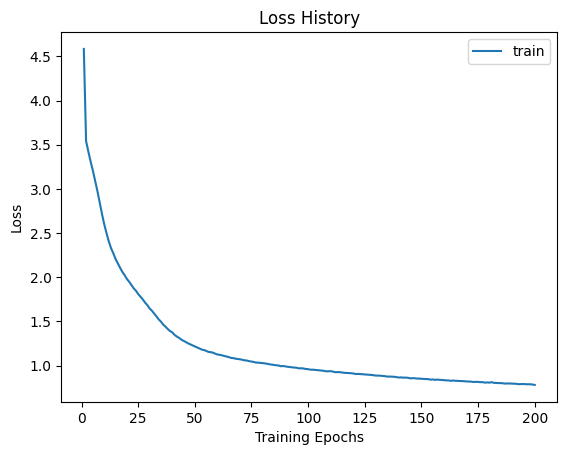

In [5]:
# plot loss history
plt.title('Loss History')
plt.plot(range(1, num_epochs+1), loss_history, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [6]:
# define Linear Classifier for transfer learning
class LinearClassifier(nn.Module):
    def __init__(self, backbone, finetune=True):
        super(LinearClassifier, self).__init__()
        self.backbone = backbone
        dim = self.backbone[1][0].weight.shape[0]
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, 1)
#         self.bn2 = nn.BatchNorm1d(dim)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.fc3 = nn.Linear(dim, 1)

        self.bn = nn.BatchNorm1d(dim)
        self.relu = nn.ReLU(inplace=True)
        
        if finetune:
            self.ft = finetune
        else:
            self.ft = finetune
            for name, param in self.backbone.named_parameters():
                param.requires_grad = False
    
    def forward(self, x):
        if self.ft:
            x = self.backbone(x)
        else:
            with torch.no_grad():
                x = self.backbone(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.fc3(x)
        return x

In [7]:
def downstream(model, linear_epoch=100):
    loss_hist = {'train':[], 'val':[]}
    start_time = time.time()
    path2weights = './models/lincls_weights.pt'
    max_auc = 0
    auc = 0
    from sklearn import metrics
    linear_scaler = amp.GradScaler()#weight=torch.FloatTensor(class_weight).to(device)
    linear_loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight[1]]).to(device))#nn.CrossEntropyLoss(weight=torch.HalfTensor(class_weight).to(device))
    # linear_opt =  optim.SGD(encoder.parameters(), lr=30, momentum=0.9, weight_decay=1e-4)#pos_weight=torch.FloatTensor(class_weight[1]).to(device)
    linear_opt =  optim.AdamW(model.parameters())
    # start training
    best_result = 0
    for epoch in range(linear_epoch):
        # clear_output()
        print('Epoch {}/{}'.format(epoch+1, linear_epoch))
    
        running_train_loss = 0
        running_val_loss = 0
        running_test_loss = 0
        train_pred, train_gold = [], []
        val_pred, val_gold = [], []
        # transfer dataloader
        model.train()
        for i, (x, y) in enumerate(tqdm(train_dl)):
            # retrieve query and key
            x = x.float().to(device)
            y = y.float().to(device)
            # extract features using linear_encoder
            with amp.autocast():
                pred = model(x)#.reshape(-1,)
                loss = linear_loss_func(pred, y.reshape(-1,1))
                if loss == torch.nan:
                    break
                linear_opt.zero_grad()
                linear_scaler.scale(loss).backward()
                linear_scaler.step(linear_opt)
                linear_scale = linear_scaler.get_scale()
                linear_scaler.update()
            temp_pos = y.int().detach().cpu().numpy()
            train_pred.extend(pred.detach().cpu().numpy())
            train_gold.extend(temp_pos)
            running_train_loss += loss
            
        if loss == torch.nan:
            break
        train_loss = running_train_loss / (i+1)
        loss_hist['train'].append(train_loss.detach().cpu().numpy())
        train_pred, train_gold = np.array(train_pred).reshape(-1), np.array(train_gold).reshape(-1)
        train_AUROC = metrics.roc_auc_score(train_gold, train_pred)
        train_AUPR = metrics.average_precision_score(train_gold, train_pred)
        # validation dataloader
        model.eval()
        for i, (x, y) in enumerate(val_dl):
            x = x.float().to(device)
            y = y.float().to(device)
            
            with torch.no_grad():
                with amp.autocast():
                    pred = model(x)
                    running_val_loss += loss
                val_pred.extend(pred.detach().cpu().numpy())
                val_gold.extend(y.int().detach().cpu().numpy())
        val_pred, val_gold = np.nan_to_num(val_pred).reshape(-1), np.nan_to_num(val_gold).reshape(-1)
        val_AUROC = metrics.roc_auc_score(val_gold, val_pred)
        val_AUPR = metrics.average_precision_score(val_gold, val_pred)
        
        val_loss = running_val_loss / (i+1)
        loss_hist['val'].append(val_loss.detach().cpu().numpy())
        print('train loss: %.6f, val loss: %.6f, AUROC score: %.4f, AUPR score: %.4f, time: %.4f min' %(train_loss, val_loss, val_AUROC, val_AUPR, (time.time()-start_time)/60))
        print('-'*10)
        if val_AUPR > best_result:
            best_loss = val_AUPR
            best_model = copy.deepcopy(model)
    
    best_model.eval()
    test_pred, test_gold = [], []
    for i, (x, y) in enumerate(tqdm(test_dl)):
        # retrieve query and key
        x = x.float().to(device)
        y = y.float().to(device)
        # extract features using q_encoder
        with torch.no_grad():
            with amp.autocast():
                linear_opt.zero_grad()
                pred = best_model(x)# .reshape(-1,)
                loss = linear_loss_func(pred, y.reshape(-1,1))
            test_pred.extend(pred.detach().cpu().numpy())
            test_gold.extend(y.int().detach().cpu().numpy())
    torch.cuda.empty_cache()
    test_loss = running_test_loss / (i+1)
    test_pred, test_gold = np.nan_to_num(test_pred).reshape(-1), np.nan_to_num(test_gold).reshape(-1)
    AUROC = metrics.roc_auc_score(test_gold, test_pred)
    AUPR = metrics.average_precision_score(test_gold, test_pred)
    # F1 = metrics.f1_score(test_gold, test_pred)
    # BAS = metrics.balanced_accuracy_score(test_gold, test_pred)
    # Accuracy = metrics.accuracy_score(test_gold, test_pred)
    print('Test Metric:',AUROC, AUPR)
    return [AUROC, AUPR]

In [8]:
TestMetric, TestMetric_ft = [], []
for _ in range(10):
    train_index, val_index, test_index = split_datasets(labels)
    exp_train = np.array(all_exp)[np.array(train_index)]
    y_train = np.array(labels)[np.array(train_index)]
    exp_val = np.array(all_exp)[np.array(val_index)]
    y_val = np.array(labels)[np.array(val_index)]
    exp_test = np.array(all_exp)[np.array(test_index)]
    y_test = np.array(labels)[np.array(test_index)]
    
    train_data = Feeder(np.array(exp_train), y_train, patch_size, 'lincls')
    val_data = Feeder(np.array(exp_val), y_val, patch_size, 'lincls')
    test_data = Feeder(np.array(exp_test), y_test, patch_size, 'lincls')
    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # without finetune (frozen backbone params)
    Metric = downstream(model=LinearClassifier(backbone=copy.deepcopy(encoder), finetune=False).to(device), linear_epoch=100)
    TestMetric.append(Metric)
    # with finetune (unfrozen backbone params)
    Metric = downstream(model=LinearClassifier(backbone=copy.deepcopy(encoder), finetune=True).to(device), linear_epoch=50)
    TestMetric_ft.append(Metric)
a, b = np.argsort(np.array(TestMetric)[:,1], axis=0)[5:], np.argsort(np.array(TestMetric)[:,1], axis=0)[2:7]
TestMetric, TestMetric_ft = np.array(TestMetric)[a,:].tolist(), np.array(TestMetric_ft)[b,:].tolist()
np.save('SIGMA_hESC1000+Non-Specific.npy', np.array(TestMetric))
np.save('SIGMA_hESC1000+Non-Specific+ft.npy', np.array(TestMetric_ft))

labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:28<00:00, 13.69it/s]


train loss: 0.984703, val loss: 0.665504, AUROC score: 0.8812, AUPR score: 0.1408, time: 0.5794 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 13.98it/s]


train loss: 0.832415, val loss: 0.439842, AUROC score: 0.8877, AUPR score: 0.1458, time: 1.1595 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.09it/s]


train loss: 0.773972, val loss: 0.871398, AUROC score: 0.8954, AUPR score: 0.1550, time: 1.7412 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.32it/s]


train loss: 0.723338, val loss: 0.643983, AUROC score: 0.8902, AUPR score: 0.1538, time: 2.3118 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.36it/s]


train loss: 0.688277, val loss: 1.280138, AUROC score: 0.8916, AUPR score: 0.1500, time: 2.8795 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:28<00:00, 13.84it/s]


train loss: 0.641083, val loss: 0.903548, AUROC score: 0.8958, AUPR score: 0.1640, time: 3.4666 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.30it/s]


train loss: 0.602866, val loss: 0.496731, AUROC score: 0.8938, AUPR score: 0.1484, time: 4.0394 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.37it/s]


train loss: 0.566717, val loss: 0.630621, AUROC score: 0.8905, AUPR score: 0.1350, time: 4.5988 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.07it/s]


train loss: 0.532790, val loss: 0.504722, AUROC score: 0.8879, AUPR score: 0.1387, time: 5.1659 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.16it/s]


train loss: 0.498977, val loss: 0.621522, AUROC score: 0.8903, AUPR score: 0.1382, time: 5.7369 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.30it/s]


train loss: 0.473314, val loss: 0.409259, AUROC score: 0.8939, AUPR score: 0.1438, time: 6.3033 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.38it/s]


train loss: 0.443562, val loss: 0.525964, AUROC score: 0.8928, AUPR score: 0.1401, time: 6.8714 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.12it/s]


train loss: 0.427135, val loss: 0.514560, AUROC score: 0.8928, AUPR score: 0.1469, time: 7.4468 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.03it/s]


train loss: 0.403413, val loss: 0.295828, AUROC score: 0.8876, AUPR score: 0.1305, time: 8.0265 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.12it/s]


train loss: 0.390722, val loss: 0.362247, AUROC score: 0.8798, AUPR score: 0.1280, time: 8.6024 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.57it/s]


train loss: 0.377096, val loss: 0.291666, AUROC score: 0.8904, AUPR score: 0.1400, time: 9.1496 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.37it/s]


train loss: 0.351424, val loss: 0.459751, AUROC score: 0.8844, AUPR score: 0.1361, time: 9.6638 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.89it/s]


train loss: 0.338837, val loss: 0.302857, AUROC score: 0.8908, AUPR score: 0.1461, time: 10.1753 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.97it/s]


train loss: 0.333881, val loss: 0.287369, AUROC score: 0.8843, AUPR score: 0.1366, time: 10.6901 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.02it/s]


train loss: 0.321663, val loss: 0.310510, AUROC score: 0.8881, AUPR score: 0.1281, time: 11.2036 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.93it/s]


train loss: 0.309183, val loss: 0.613952, AUROC score: 0.8864, AUPR score: 0.1223, time: 11.7169 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.67it/s]


train loss: 0.302922, val loss: 0.240762, AUROC score: 0.8785, AUPR score: 0.1229, time: 12.2381 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.62it/s]


train loss: 0.292953, val loss: 0.208708, AUROC score: 0.8874, AUPR score: 0.1427, time: 12.7612 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.92it/s]


train loss: 0.279507, val loss: 0.200441, AUROC score: 0.8842, AUPR score: 0.1316, time: 13.2790 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.80it/s]


train loss: 0.281746, val loss: 0.342686, AUROC score: 0.8839, AUPR score: 0.1351, time: 13.7886 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:17<00:00, 22.60it/s]


train loss: 0.271038, val loss: 0.247929, AUROC score: 0.8834, AUPR score: 0.1541, time: 14.1559 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:19<00:00, 19.54it/s]


train loss: 0.264146, val loss: 0.431676, AUROC score: 0.8893, AUPR score: 0.1291, time: 14.5800 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.66it/s]


train loss: 0.263299, val loss: 0.591209, AUROC score: 0.8839, AUPR score: 0.1332, time: 15.0181 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 18.54it/s]


train loss: 0.257874, val loss: 0.233382, AUROC score: 0.8800, AUPR score: 0.1219, time: 15.4609 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.70it/s]


train loss: 0.251488, val loss: 0.156859, AUROC score: 0.8794, AUPR score: 0.1394, time: 15.8901 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.73it/s]


train loss: 0.234550, val loss: 0.163703, AUROC score: 0.8855, AUPR score: 0.1346, time: 16.3267 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.76it/s]


train loss: 0.234875, val loss: 0.149708, AUROC score: 0.8798, AUPR score: 0.1338, time: 16.7592 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.70it/s]


train loss: 0.230528, val loss: 0.164485, AUROC score: 0.8807, AUPR score: 0.1233, time: 17.1980 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.62it/s]


train loss: 0.227756, val loss: 0.525864, AUROC score: 0.8796, AUPR score: 0.1411, time: 17.6401 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.229386, val loss: 0.620784, AUROC score: 0.8742, AUPR score: 0.1411, time: 18.0750 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.57it/s]


train loss: 0.222703, val loss: 0.253064, AUROC score: 0.8829, AUPR score: 0.1436, time: 18.5157 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.62it/s]


train loss: 0.215995, val loss: 0.318614, AUROC score: 0.8840, AUPR score: 0.1486, time: 18.9481 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 18.55it/s]


train loss: 0.219478, val loss: 0.153859, AUROC score: 0.8817, AUPR score: 0.1246, time: 19.3913 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.60it/s]


train loss: 0.203883, val loss: 0.185479, AUROC score: 0.8808, AUPR score: 0.1353, time: 19.8258 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.210886, val loss: 0.118507, AUROC score: 0.8815, AUPR score: 0.1499, time: 20.2629 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.81it/s]


train loss: 0.210849, val loss: 0.285160, AUROC score: 0.8814, AUPR score: 0.1310, time: 20.6964 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.202555, val loss: 0.255194, AUROC score: 0.8793, AUPR score: 0.1302, time: 21.1329 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.67it/s]


train loss: 0.198477, val loss: 0.207578, AUROC score: 0.8799, AUPR score: 0.1465, time: 21.5693 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.67it/s]


train loss: 0.198684, val loss: 0.348761, AUROC score: 0.8788, AUPR score: 0.1303, time: 22.0040 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 18.52it/s]


train loss: 0.188411, val loss: 0.113645, AUROC score: 0.8815, AUPR score: 0.1438, time: 22.4479 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.65it/s]


train loss: 0.188070, val loss: 0.228040, AUROC score: 0.8831, AUPR score: 0.1370, time: 22.8791 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.59it/s]


train loss: 0.199703, val loss: 0.091676, AUROC score: 0.8778, AUPR score: 0.1271, time: 23.3183 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.74it/s]


train loss: 0.180910, val loss: 0.205584, AUROC score: 0.8761, AUPR score: 0.1236, time: 23.7529 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.57it/s]


train loss: 0.190012, val loss: 0.178553, AUROC score: 0.8775, AUPR score: 0.1216, time: 24.1916 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.183650, val loss: 0.131603, AUROC score: 0.8766, AUPR score: 0.1300, time: 24.6274 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.61it/s]


train loss: 0.183303, val loss: 0.236714, AUROC score: 0.8745, AUPR score: 0.1397, time: 25.0629 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.65it/s]


train loss: 0.176671, val loss: 0.171560, AUROC score: 0.8782, AUPR score: 0.1396, time: 25.5015 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.64it/s]


train loss: 0.174696, val loss: 0.274840, AUROC score: 0.8759, AUPR score: 0.1239, time: 25.9326 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.66it/s]


train loss: 0.176773, val loss: 0.196693, AUROC score: 0.8776, AUPR score: 0.1437, time: 26.3693 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.69it/s]


train loss: 0.174507, val loss: 0.401760, AUROC score: 0.8724, AUPR score: 0.1397, time: 26.8029 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.64it/s]


train loss: 0.176700, val loss: 0.358598, AUROC score: 0.8784, AUPR score: 0.1472, time: 27.2444 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.64it/s]


train loss: 0.179112, val loss: 0.122518, AUROC score: 0.8760, AUPR score: 0.1420, time: 27.6784 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.67it/s]


train loss: 0.166458, val loss: 0.158775, AUROC score: 0.8750, AUPR score: 0.1152, time: 28.1195 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.71it/s]


train loss: 0.162055, val loss: 0.090530, AUROC score: 0.8791, AUPR score: 0.1382, time: 28.5576 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.63it/s]


train loss: 0.160492, val loss: 0.623289, AUROC score: 0.8761, AUPR score: 0.1370, time: 28.9902 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.63it/s]


train loss: 0.169652, val loss: 0.190741, AUROC score: 0.8731, AUPR score: 0.1342, time: 29.4292 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.59it/s]


train loss: 0.167589, val loss: 0.112472, AUROC score: 0.8713, AUPR score: 0.1317, time: 29.8597 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.158942, val loss: 0.217054, AUROC score: 0.8746, AUPR score: 0.1444, time: 30.2992 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.64it/s]


train loss: 0.162604, val loss: 0.205444, AUROC score: 0.8752, AUPR score: 0.1482, time: 30.7332 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.61it/s]


train loss: 0.154666, val loss: 0.129902, AUROC score: 0.8786, AUPR score: 0.1499, time: 31.1735 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.58it/s]


train loss: 0.147575, val loss: 0.120780, AUROC score: 0.8773, AUPR score: 0.1465, time: 31.6127 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.67it/s]


train loss: 0.155429, val loss: 0.091088, AUROC score: 0.8792, AUPR score: 0.1360, time: 32.0468 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.69it/s]


train loss: 0.155319, val loss: 0.152944, AUROC score: 0.8728, AUPR score: 0.1280, time: 32.4852 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.58it/s]


train loss: 0.150668, val loss: 0.197018, AUROC score: 0.8725, AUPR score: 0.1372, time: 32.9160 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.61it/s]


train loss: 0.155242, val loss: 0.131429, AUROC score: 0.8760, AUPR score: 0.1428, time: 33.3562 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.25it/s]


train loss: 0.155616, val loss: 0.150200, AUROC score: 0.8735, AUPR score: 0.1392, time: 33.8493 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.68it/s]


train loss: 0.146555, val loss: 0.151833, AUROC score: 0.8784, AUPR score: 0.1357, time: 34.2806 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.76it/s]


train loss: 0.147263, val loss: 0.156747, AUROC score: 0.8724, AUPR score: 0.1173, time: 34.7226 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.76it/s]


train loss: 0.150700, val loss: 0.096705, AUROC score: 0.8744, AUPR score: 0.1370, time: 35.1582 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.66it/s]


train loss: 0.142758, val loss: 0.304572, AUROC score: 0.8805, AUPR score: 0.1484, time: 35.5950 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.74it/s]


train loss: 0.138413, val loss: 0.106686, AUROC score: 0.8735, AUPR score: 0.1375, time: 36.0307 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.70it/s]


train loss: 0.140417, val loss: 0.106224, AUROC score: 0.8721, AUPR score: 0.1284, time: 36.4636 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.63it/s]


train loss: 0.156528, val loss: 0.064653, AUROC score: 0.8741, AUPR score: 0.1289, time: 36.9032 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.32it/s]


train loss: 0.137023, val loss: 0.076431, AUROC score: 0.8738, AUPR score: 0.1319, time: 37.3747 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.29it/s]


train loss: 0.137727, val loss: 0.126977, AUROC score: 0.8745, AUPR score: 0.1492, time: 37.8695 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.05it/s]


train loss: 0.160510, val loss: 0.349647, AUROC score: 0.8689, AUPR score: 0.1288, time: 38.3716 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.12it/s]


train loss: 0.138896, val loss: 0.172300, AUROC score: 0.8743, AUPR score: 0.1397, time: 38.8724 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.49it/s]


train loss: 0.133559, val loss: 0.098195, AUROC score: 0.8736, AUPR score: 0.1273, time: 39.3651 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.11it/s]


train loss: 0.133944, val loss: 0.173415, AUROC score: 0.8737, AUPR score: 0.1353, time: 39.8636 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.28it/s]


train loss: 0.138868, val loss: 0.117531, AUROC score: 0.8679, AUPR score: 0.1218, time: 40.3623 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.10it/s]


train loss: 0.133353, val loss: 0.200939, AUROC score: 0.8746, AUPR score: 0.1377, time: 40.8625 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.17it/s]


train loss: 0.133057, val loss: 0.261261, AUROC score: 0.8747, AUPR score: 0.1253, time: 41.3576 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.42it/s]


train loss: 0.129715, val loss: 0.141408, AUROC score: 0.8720, AUPR score: 0.1384, time: 41.8500 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.25it/s]


train loss: 0.135481, val loss: 0.104403, AUROC score: 0.8700, AUPR score: 0.1296, time: 42.3509 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.82it/s]


train loss: 0.131118, val loss: 0.118905, AUROC score: 0.8750, AUPR score: 0.1430, time: 42.8571 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.10it/s]


train loss: 0.125593, val loss: 0.090057, AUROC score: 0.8723, AUPR score: 0.1220, time: 43.4331 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.33it/s]


train loss: 0.131400, val loss: 0.072362, AUROC score: 0.8686, AUPR score: 0.1385, time: 44.0014 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.08it/s]


train loss: 0.143774, val loss: 0.064765, AUROC score: 0.8724, AUPR score: 0.1463, time: 44.5816 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.25it/s]


train loss: 0.124173, val loss: 0.127119, AUROC score: 0.8693, AUPR score: 0.1177, time: 45.1490 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.19it/s]


train loss: 0.128361, val loss: 0.054414, AUROC score: 0.8772, AUPR score: 0.1441, time: 45.7220 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.23it/s]


train loss: 0.133245, val loss: 0.085866, AUROC score: 0.8757, AUPR score: 0.1394, time: 46.2973 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.25it/s]


train loss: 0.122886, val loss: 0.177271, AUROC score: 0.8725, AUPR score: 0.1395, time: 46.8587 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.17it/s]


train loss: 0.116028, val loss: 0.106261, AUROC score: 0.8721, AUPR score: 0.1269, time: 47.4186 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.10it/s]


train loss: 0.122773, val loss: 0.091392, AUROC score: 0.8704, AUPR score: 0.1463, time: 47.9870 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.31it/s]


train loss: 0.133980, val loss: 0.092731, AUROC score: 0.8694, AUPR score: 0.1210, time: 48.5561 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:06<00:00, 19.85it/s]


Test Metric: 0.8626464457102703 0.11608444441445857
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:49<00:00,  7.92it/s]


train loss: 0.965190, val loss: 1.296747, AUROC score: 0.8868, AUPR score: 0.1216, time: 0.9232 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:49<00:00,  7.88it/s]


train loss: 0.831267, val loss: 1.135824, AUROC score: 0.8963, AUPR score: 0.1877, time: 1.8642 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.12it/s]


train loss: 0.778550, val loss: 1.154968, AUROC score: 0.9043, AUPR score: 0.1808, time: 2.7798 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:49<00:00,  7.93it/s]


train loss: 0.741322, val loss: 1.191493, AUROC score: 0.8987, AUPR score: 0.1507, time: 3.7162 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.10it/s]


train loss: 0.716758, val loss: 0.466785, AUROC score: 0.9041, AUPR score: 0.1770, time: 4.6333 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:49<00:00,  7.91it/s]


train loss: 0.689822, val loss: 0.633393, AUROC score: 0.9090, AUPR score: 0.1784, time: 5.5593 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.09it/s]


train loss: 0.669157, val loss: 0.412525, AUROC score: 0.9069, AUPR score: 0.1704, time: 6.4772 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.09it/s]


train loss: 0.651571, val loss: 0.435223, AUROC score: 0.8941, AUPR score: 0.1586, time: 7.3824 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:49<00:00,  7.94it/s]


train loss: 0.630331, val loss: 1.654161, AUROC score: 0.9045, AUPR score: 0.1779, time: 8.3153 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.08it/s]


train loss: 0.608082, val loss: 0.660029, AUROC score: 0.9014, AUPR score: 0.1760, time: 9.2255 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.00it/s]


train loss: 0.609264, val loss: 0.624478, AUROC score: 0.9051, AUPR score: 0.1902, time: 10.1508 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:48<00:00,  8.05it/s]


train loss: 0.584609, val loss: 0.357970, AUROC score: 0.8956, AUPR score: 0.1666, time: 11.0746 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:44<00:00,  8.82it/s]


train loss: 0.564013, val loss: 0.744696, AUROC score: 0.8973, AUPR score: 0.1880, time: 11.9202 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  8.92it/s]


train loss: 0.561326, val loss: 1.997891, AUROC score: 0.9022, AUPR score: 0.2025, time: 12.7561 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:44<00:00,  8.82it/s]


train loss: 0.564637, val loss: 0.982771, AUROC score: 0.8956, AUPR score: 0.1787, time: 13.5849 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:45<00:00,  8.65it/s]


train loss: 0.536982, val loss: 0.451843, AUROC score: 0.8807, AUPR score: 0.1767, time: 14.4416 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  9.05it/s]


train loss: 0.535812, val loss: 0.396583, AUROC score: 0.8982, AUPR score: 0.1909, time: 15.2499 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  8.97it/s]


train loss: 0.504420, val loss: 0.339661, AUROC score: 0.8935, AUPR score: 0.1977, time: 16.0830 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  9.00it/s]


train loss: 0.510097, val loss: 0.289557, AUROC score: 0.9017, AUPR score: 0.1937, time: 16.9090 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:44<00:00,  8.85it/s]


train loss: 0.492584, val loss: 0.406902, AUROC score: 0.8953, AUPR score: 0.1868, time: 17.7519 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:42<00:00,  9.21it/s]


train loss: 0.489699, val loss: 0.352310, AUROC score: 0.8960, AUPR score: 0.1743, time: 18.5667 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  8.87it/s]


train loss: 0.476688, val loss: 1.039290, AUROC score: 0.8994, AUPR score: 0.1775, time: 19.3985 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:43<00:00,  9.03it/s]


train loss: 0.494055, val loss: 0.339780, AUROC score: 0.9041, AUPR score: 0.1908, time: 20.2255 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:42<00:00,  9.09it/s]


train loss: 0.463266, val loss: 0.855697, AUROC score: 0.9007, AUPR score: 0.1730, time: 21.0311 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.64it/s]


train loss: 0.433562, val loss: 0.578956, AUROC score: 0.8965, AUPR score: 0.1850, time: 21.7949 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.18it/s]


train loss: 0.451423, val loss: 0.314972, AUROC score: 0.8934, AUPR score: 0.1683, time: 22.5252 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.20it/s]


train loss: 0.464779, val loss: 0.341424, AUROC score: 0.8984, AUPR score: 0.2005, time: 23.2561 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.18it/s]


train loss: 0.435933, val loss: 0.302196, AUROC score: 0.8927, AUPR score: 0.1769, time: 23.9793 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.19it/s]


train loss: 0.434160, val loss: 0.402786, AUROC score: 0.8915, AUPR score: 0.1823, time: 24.7022 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.16it/s]


train loss: 0.426041, val loss: 0.260620, AUROC score: 0.8884, AUPR score: 0.1689, time: 25.4303 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.12it/s]


train loss: 0.414852, val loss: 0.457372, AUROC score: 0.8893, AUPR score: 0.1697, time: 26.1612 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.19it/s]


train loss: 0.402436, val loss: 0.516281, AUROC score: 0.8897, AUPR score: 0.1948, time: 26.8894 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.13it/s]


train loss: 0.401059, val loss: 0.685870, AUROC score: 0.8899, AUPR score: 0.1574, time: 27.6143 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.22it/s]


train loss: 0.401626, val loss: 0.354504, AUROC score: 0.9043, AUPR score: 0.1815, time: 28.3392 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.404189, val loss: 0.381356, AUROC score: 0.9018, AUPR score: 0.1674, time: 29.0700 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.11it/s]


train loss: 0.377923, val loss: 0.456067, AUROC score: 0.8956, AUPR score: 0.1821, time: 29.8063 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.391821, val loss: 0.369526, AUROC score: 0.9014, AUPR score: 0.1769, time: 30.5336 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.12it/s]


train loss: 0.380378, val loss: 0.292057, AUROC score: 0.8925, AUPR score: 0.1660, time: 31.2645 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.366049, val loss: 0.255729, AUROC score: 0.8897, AUPR score: 0.1717, time: 31.9941 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.13it/s]


train loss: 0.351798, val loss: 0.385524, AUROC score: 0.8964, AUPR score: 0.1788, time: 32.7261 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.18it/s]


train loss: 0.364983, val loss: 0.309053, AUROC score: 0.8826, AUPR score: 0.1792, time: 33.4554 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.21it/s]


train loss: 0.348941, val loss: 0.392510, AUROC score: 0.8926, AUPR score: 0.1760, time: 34.1745 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.19it/s]


train loss: 0.332318, val loss: 0.430904, AUROC score: 0.8914, AUPR score: 0.1595, time: 34.9036 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.11it/s]


train loss: 0.368067, val loss: 0.213181, AUROC score: 0.8911, AUPR score: 0.1574, time: 35.6375 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.21it/s]


train loss: 0.347471, val loss: 0.291944, AUROC score: 0.8900, AUPR score: 0.1535, time: 36.3667 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.321436, val loss: 0.210419, AUROC score: 0.8904, AUPR score: 0.1748, time: 37.0914 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.337588, val loss: 0.258696, AUROC score: 0.8860, AUPR score: 0.1806, time: 37.8161 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.16it/s]


train loss: 0.327496, val loss: 0.258142, AUROC score: 0.8872, AUPR score: 0.1533, time: 38.5490 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.13it/s]


train loss: 0.332485, val loss: 0.320536, AUROC score: 0.8974, AUPR score: 0.1698, time: 39.2823 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.13it/s]


train loss: 0.302624, val loss: 0.474811, AUROC score: 0.8787, AUPR score: 0.1431, time: 40.0145 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:05<00:00, 25.28it/s]


Test Metric: 0.854719034632979 0.10923339112885144
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 18.51it/s]


train loss: 0.962028, val loss: 0.810821, AUROC score: 0.8726, AUPR score: 0.1174, time: 0.4410 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.66it/s]


train loss: 0.813544, val loss: 0.715538, AUROC score: 0.8794, AUPR score: 0.1224, time: 0.8729 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.59it/s]


train loss: 0.758899, val loss: 0.427333, AUROC score: 0.8839, AUPR score: 0.1208, time: 1.3124 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:20<00:00, 18.66it/s]


train loss: 0.704839, val loss: 0.453434, AUROC score: 0.8836, AUPR score: 0.1249, time: 1.7413 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 18.50it/s]


train loss: 0.657443, val loss: 0.397944, AUROC score: 0.8831, AUPR score: 0.1316, time: 2.1942 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.24it/s]


train loss: 0.617772, val loss: 0.876145, AUROC score: 0.8864, AUPR score: 0.1309, time: 2.6922 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.67it/s]


train loss: 0.579718, val loss: 0.789114, AUROC score: 0.8916, AUPR score: 0.1425, time: 3.2056 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.37it/s]


train loss: 0.548388, val loss: 0.530677, AUROC score: 0.8869, AUPR score: 0.1281, time: 3.6968 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.14it/s]


train loss: 0.521599, val loss: 0.797140, AUROC score: 0.8854, AUPR score: 0.1365, time: 4.1971 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.98it/s]


train loss: 0.482805, val loss: 0.606004, AUROC score: 0.8762, AUPR score: 0.1061, time: 4.7034 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.34it/s]


train loss: 0.458007, val loss: 0.508373, AUROC score: 0.8793, AUPR score: 0.1299, time: 5.1923 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.18it/s]


train loss: 0.437940, val loss: 0.239393, AUROC score: 0.8837, AUPR score: 0.1328, time: 5.6917 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.17it/s]


train loss: 0.417812, val loss: 0.942007, AUROC score: 0.8774, AUPR score: 0.1238, time: 6.1931 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.15it/s]


train loss: 0.397056, val loss: 0.349839, AUROC score: 0.8785, AUPR score: 0.1143, time: 6.6909 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.00it/s]


train loss: 0.375365, val loss: 0.486004, AUROC score: 0.8844, AUPR score: 0.1265, time: 7.1979 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.20it/s]


train loss: 0.369990, val loss: 0.755442, AUROC score: 0.8804, AUPR score: 0.1161, time: 7.6951 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.20it/s]


train loss: 0.352584, val loss: 0.509693, AUROC score: 0.8811, AUPR score: 0.1393, time: 8.1933 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.17it/s]


train loss: 0.332197, val loss: 0.181137, AUROC score: 0.8752, AUPR score: 0.1331, time: 8.6913 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.92it/s]


train loss: 0.327554, val loss: 0.389184, AUROC score: 0.8730, AUPR score: 0.1282, time: 9.2000 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.43it/s]


train loss: 0.309072, val loss: 0.602465, AUROC score: 0.8799, AUPR score: 0.1392, time: 9.6920 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.17it/s]


train loss: 0.304493, val loss: 0.191376, AUROC score: 0.8741, AUPR score: 0.1291, time: 10.1886 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.17it/s]


train loss: 0.294650, val loss: 0.386013, AUROC score: 0.8771, AUPR score: 0.1412, time: 10.6908 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 15.90it/s]


train loss: 0.282271, val loss: 0.192809, AUROC score: 0.8753, AUPR score: 0.1278, time: 11.1979 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.14it/s]


train loss: 0.277053, val loss: 0.205126, AUROC score: 0.8768, AUPR score: 0.1273, time: 11.6929 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.23it/s]


train loss: 0.266469, val loss: 0.250401, AUROC score: 0.8700, AUPR score: 0.1081, time: 12.1920 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:23<00:00, 16.28it/s]


train loss: 0.272937, val loss: 0.889002, AUROC score: 0.8677, AUPR score: 0.1365, time: 12.6917 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:24<00:00, 16.12it/s]


train loss: 0.256917, val loss: 0.174151, AUROC score: 0.8729, AUPR score: 0.1133, time: 13.1902 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.16it/s]


train loss: 0.257672, val loss: 0.320561, AUROC score: 0.8710, AUPR score: 0.1257, time: 13.7466 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.00it/s]


train loss: 0.239441, val loss: 0.260870, AUROC score: 0.8735, AUPR score: 0.1403, time: 14.3204 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.23it/s]


train loss: 0.234101, val loss: 0.175737, AUROC score: 0.8736, AUPR score: 0.1271, time: 14.8925 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.33it/s]


train loss: 0.246621, val loss: 0.258257, AUROC score: 0.8712, AUPR score: 0.1301, time: 15.4585 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.41it/s]


train loss: 0.234256, val loss: 0.165222, AUROC score: 0.8656, AUPR score: 0.1355, time: 16.0246 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.51it/s]


train loss: 0.227256, val loss: 0.314698, AUROC score: 0.8655, AUPR score: 0.1238, time: 16.5872 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.29it/s]


train loss: 0.215225, val loss: 0.163281, AUROC score: 0.8684, AUPR score: 0.1119, time: 17.1593 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.33it/s]


train loss: 0.215742, val loss: 0.321848, AUROC score: 0.8634, AUPR score: 0.1352, time: 17.7247 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.31it/s]


train loss: 0.221014, val loss: 0.151817, AUROC score: 0.8692, AUPR score: 0.1286, time: 18.2874 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.07it/s]


train loss: 0.218076, val loss: 0.380397, AUROC score: 0.8685, AUPR score: 0.1424, time: 18.8497 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.01it/s]


train loss: 0.207120, val loss: 0.169817, AUROC score: 0.8706, AUPR score: 0.1329, time: 19.4246 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.13it/s]


train loss: 0.199496, val loss: 0.104453, AUROC score: 0.8665, AUPR score: 0.1335, time: 19.9996 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.20it/s]


train loss: 0.202888, val loss: 0.793655, AUROC score: 0.8602, AUPR score: 0.1248, time: 20.5749 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.25it/s]


train loss: 0.207423, val loss: 0.243626, AUROC score: 0.8669, AUPR score: 0.1283, time: 21.1461 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:27<00:00, 14.27it/s]


train loss: 0.199418, val loss: 0.101619, AUROC score: 0.8640, AUPR score: 0.1292, time: 21.7089 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.56it/s]


train loss: 0.195209, val loss: 0.164282, AUROC score: 0.8651, AUPR score: 0.1094, time: 22.2709 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.07it/s]


train loss: 0.189296, val loss: 0.350995, AUROC score: 0.8648, AUPR score: 0.1379, time: 22.7935 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.26it/s]


train loss: 0.188098, val loss: 0.273758, AUROC score: 0.8689, AUPR score: 0.1445, time: 23.2453 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.45it/s]


train loss: 0.198612, val loss: 0.091680, AUROC score: 0.8601, AUPR score: 0.1282, time: 23.7061 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.57it/s]


train loss: 0.179401, val loss: 0.269500, AUROC score: 0.8649, AUPR score: 0.1383, time: 24.1682 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.174272, val loss: 0.122818, AUROC score: 0.8628, AUPR score: 0.1393, time: 24.6334 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.175071, val loss: 0.188772, AUROC score: 0.8585, AUPR score: 0.1363, time: 25.0995 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.50it/s]


train loss: 0.178910, val loss: 0.221992, AUROC score: 0.8647, AUPR score: 0.1194, time: 25.5620 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.40it/s]


train loss: 0.171827, val loss: 0.132739, AUROC score: 0.8622, AUPR score: 0.1200, time: 26.0219 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.20it/s]


train loss: 0.179788, val loss: 0.252155, AUROC score: 0.8605, AUPR score: 0.1329, time: 26.4764 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.01it/s]


train loss: 0.167819, val loss: 0.119473, AUROC score: 0.8527, AUPR score: 0.1340, time: 26.9529 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.20it/s]


train loss: 0.183725, val loss: 0.156113, AUROC score: 0.8576, AUPR score: 0.1178, time: 27.4227 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.10it/s]


train loss: 0.164116, val loss: 0.214519, AUROC score: 0.8575, AUPR score: 0.1323, time: 27.8957 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.52it/s]


train loss: 0.165672, val loss: 1.630265, AUROC score: 0.8614, AUPR score: 0.1269, time: 28.3595 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.164382, val loss: 0.113861, AUROC score: 0.8653, AUPR score: 0.1242, time: 28.8203 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.08it/s]


train loss: 0.158141, val loss: 0.204245, AUROC score: 0.8604, AUPR score: 0.1086, time: 29.2760 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.29it/s]


train loss: 0.172288, val loss: 0.247074, AUROC score: 0.8591, AUPR score: 0.1130, time: 29.7454 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.164529, val loss: 0.160425, AUROC score: 0.8673, AUPR score: 0.1448, time: 30.2121 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.42it/s]


train loss: 0.156033, val loss: 0.225468, AUROC score: 0.8594, AUPR score: 0.1259, time: 30.6789 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.45it/s]


train loss: 0.154808, val loss: 0.188517, AUROC score: 0.8560, AUPR score: 0.1360, time: 31.1433 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.52it/s]


train loss: 0.147174, val loss: 0.115344, AUROC score: 0.8575, AUPR score: 0.1263, time: 31.6088 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.51it/s]


train loss: 0.151912, val loss: 0.101191, AUROC score: 0.8604, AUPR score: 0.1298, time: 32.0614 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.19it/s]


train loss: 0.159683, val loss: 0.143340, AUROC score: 0.8595, AUPR score: 0.1171, time: 32.5224 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.05it/s]


train loss: 0.151983, val loss: 0.132586, AUROC score: 0.8497, AUPR score: 0.1285, time: 32.9942 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.05it/s]


train loss: 0.146724, val loss: 0.115373, AUROC score: 0.8612, AUPR score: 0.1242, time: 33.4686 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.55it/s]


train loss: 0.153043, val loss: 0.145152, AUROC score: 0.8634, AUPR score: 0.1228, time: 33.9318 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.30it/s]


train loss: 0.148122, val loss: 0.159313, AUROC score: 0.8645, AUPR score: 0.1377, time: 34.3990 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.35it/s]


train loss: 0.148048, val loss: 0.122023, AUROC score: 0.8602, AUPR score: 0.1396, time: 34.8506 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.22it/s]


train loss: 0.144864, val loss: 0.322796, AUROC score: 0.8600, AUPR score: 0.1140, time: 35.2973 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:16<00:00, 23.36it/s]


train loss: 0.149095, val loss: 0.095001, AUROC score: 0.8603, AUPR score: 0.1409, time: 35.6461 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.136291, val loss: 0.109680, AUROC score: 0.8567, AUPR score: 0.1218, time: 36.0325 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.154144, val loss: 0.110073, AUROC score: 0.8520, AUPR score: 0.1214, time: 36.4156 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.133669, val loss: 0.116522, AUROC score: 0.8468, AUPR score: 0.1313, time: 36.8034 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.140318, val loss: 0.092448, AUROC score: 0.8591, AUPR score: 0.1286, time: 37.1878 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.141222, val loss: 0.114594, AUROC score: 0.8604, AUPR score: 0.1369, time: 37.5734 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.147567, val loss: 0.155428, AUROC score: 0.8554, AUPR score: 0.1284, time: 37.9596 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.129305, val loss: 0.101510, AUROC score: 0.8615, AUPR score: 0.1365, time: 38.3410 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.133952, val loss: 0.104057, AUROC score: 0.8609, AUPR score: 0.1515, time: 38.7263 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.140683, val loss: 0.164490, AUROC score: 0.8463, AUPR score: 0.1039, time: 39.1076 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.132090, val loss: 0.259930, AUROC score: 0.8586, AUPR score: 0.1435, time: 39.4939 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.134458, val loss: 0.261767, AUROC score: 0.8597, AUPR score: 0.1475, time: 39.8802 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.131357, val loss: 0.067491, AUROC score: 0.8543, AUPR score: 0.1453, time: 40.2672 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.68it/s]


train loss: 0.136325, val loss: 0.110101, AUROC score: 0.8591, AUPR score: 0.1246, time: 40.6562 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.130002, val loss: 0.092382, AUROC score: 0.8560, AUPR score: 0.1312, time: 41.0380 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.94it/s]


train loss: 0.123069, val loss: 0.112349, AUROC score: 0.8531, AUPR score: 0.1336, time: 41.4222 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.121544, val loss: 0.065133, AUROC score: 0.8527, AUPR score: 0.1308, time: 41.8033 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.129428, val loss: 0.156820, AUROC score: 0.8547, AUPR score: 0.1145, time: 42.1910 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.126543, val loss: 0.035802, AUROC score: 0.8515, AUPR score: 0.1258, time: 42.5761 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.94it/s]


train loss: 0.124945, val loss: 0.119021, AUROC score: 0.8588, AUPR score: 0.1343, time: 42.9620 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.124905, val loss: 0.130875, AUROC score: 0.8495, AUPR score: 0.1120, time: 43.3483 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.130090, val loss: 0.405484, AUROC score: 0.8578, AUPR score: 0.1148, time: 43.7313 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.130121, val loss: 0.060650, AUROC score: 0.8489, AUPR score: 0.1428, time: 44.1177 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.138247, val loss: 0.065488, AUROC score: 0.8484, AUPR score: 0.1343, time: 44.5002 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.126801, val loss: 0.108560, AUROC score: 0.8531, AUPR score: 0.1094, time: 44.8851 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.122726, val loss: 0.088020, AUROC score: 0.8555, AUPR score: 0.1350, time: 45.2711 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.123979, val loss: 0.210989, AUROC score: 0.8548, AUPR score: 0.1179, time: 45.6577 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.74it/s]


train loss: 0.115263, val loss: 0.339459, AUROC score: 0.8502, AUPR score: 0.1225, time: 46.0445 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.114169, val loss: 0.262592, AUROC score: 0.8579, AUPR score: 0.1001, time: 46.4260 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.02it/s]


Test Metric: 0.8675639386162891 0.10065542271827839
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.53it/s]


train loss: 0.953528, val loss: 0.851702, AUROC score: 0.8787, AUPR score: 0.1423, time: 0.6401 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.53it/s]


train loss: 0.812773, val loss: 0.615222, AUROC score: 0.8866, AUPR score: 0.1403, time: 1.2798 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.765498, val loss: 0.679215, AUROC score: 0.8885, AUPR score: 0.1503, time: 1.9157 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.725339, val loss: 1.147298, AUROC score: 0.8851, AUPR score: 0.1360, time: 2.5447 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.702135, val loss: 0.541977, AUROC score: 0.8903, AUPR score: 0.1511, time: 3.1728 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.662322, val loss: 2.057888, AUROC score: 0.8885, AUPR score: 0.1530, time: 3.8029 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.73it/s]


train loss: 0.659721, val loss: 0.580594, AUROC score: 0.8915, AUPR score: 0.1384, time: 4.4317 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.78it/s]


train loss: 0.631550, val loss: 0.562789, AUROC score: 0.8856, AUPR score: 0.1378, time: 5.0602 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.608309, val loss: 1.384568, AUROC score: 0.8831, AUPR score: 0.1588, time: 5.6923 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.606027, val loss: 0.420700, AUROC score: 0.8900, AUPR score: 0.1468, time: 6.3226 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.568820, val loss: 0.777037, AUROC score: 0.8858, AUPR score: 0.1527, time: 6.9573 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.55it/s]


train loss: 0.564441, val loss: 0.449195, AUROC score: 0.8848, AUPR score: 0.1549, time: 7.5960 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.57it/s]


train loss: 0.564193, val loss: 0.837774, AUROC score: 0.8858, AUPR score: 0.1553, time: 8.2339 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.75it/s]


train loss: 0.534432, val loss: 0.686872, AUROC score: 0.8880, AUPR score: 0.1639, time: 8.8630 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.74it/s]


train loss: 0.514854, val loss: 0.417665, AUROC score: 0.8864, AUPR score: 0.1516, time: 9.4923 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.525985, val loss: 0.542064, AUROC score: 0.8815, AUPR score: 0.1528, time: 10.1199 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.515962, val loss: 0.510860, AUROC score: 0.8787, AUPR score: 0.1582, time: 10.7471 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.487139, val loss: 0.315642, AUROC score: 0.8755, AUPR score: 0.1499, time: 11.3819 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.475598, val loss: 0.337252, AUROC score: 0.8805, AUPR score: 0.1586, time: 12.0200 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.464936, val loss: 0.403226, AUROC score: 0.8740, AUPR score: 0.1486, time: 12.6585 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.464455, val loss: 0.337552, AUROC score: 0.8776, AUPR score: 0.1534, time: 13.2919 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.55it/s]


train loss: 0.452745, val loss: 0.375640, AUROC score: 0.8804, AUPR score: 0.1419, time: 13.9253 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.441896, val loss: 0.355939, AUROC score: 0.8629, AUPR score: 0.1259, time: 14.5530 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.75it/s]


train loss: 0.424325, val loss: 0.621506, AUROC score: 0.8773, AUPR score: 0.1491, time: 15.1800 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.415966, val loss: 0.241819, AUROC score: 0.8723, AUPR score: 0.1293, time: 15.8130 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.06it/s]


train loss: 0.426822, val loss: 0.339439, AUROC score: 0.8684, AUPR score: 0.1222, time: 16.5383 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.28it/s]


train loss: 0.404742, val loss: 0.266249, AUROC score: 0.8750, AUPR score: 0.1346, time: 17.2635 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.53it/s]


train loss: 0.388097, val loss: 0.277932, AUROC score: 0.8672, AUPR score: 0.1348, time: 17.9603 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.81it/s]


train loss: 0.397751, val loss: 0.312773, AUROC score: 0.8634, AUPR score: 0.1242, time: 18.7156 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.30it/s]


train loss: 0.385290, val loss: 0.275933, AUROC score: 0.8794, AUPR score: 0.1416, time: 19.4387 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.98it/s]


train loss: 0.404447, val loss: 0.345793, AUROC score: 0.8724, AUPR score: 0.1415, time: 20.1842 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.09it/s]


train loss: 0.358276, val loss: 0.312973, AUROC score: 0.8662, AUPR score: 0.1315, time: 20.9204 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:41<00:00,  9.30it/s]


train loss: 0.357659, val loss: 0.354788, AUROC score: 0.8688, AUPR score: 0.1454, time: 21.7071 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.12it/s]


train loss: 0.353154, val loss: 0.244626, AUROC score: 0.8710, AUPR score: 0.1400, time: 22.4425 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.66it/s]


train loss: 0.364557, val loss: 0.544594, AUROC score: 0.8687, AUPR score: 0.1345, time: 23.1924 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.06it/s]


train loss: 0.340545, val loss: 0.216774, AUROC score: 0.8685, AUPR score: 0.1303, time: 23.9317 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.69it/s]


train loss: 0.336623, val loss: 0.286779, AUROC score: 0.8616, AUPR score: 0.1412, time: 24.6906 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.55it/s]


train loss: 0.329785, val loss: 0.301113, AUROC score: 0.8511, AUPR score: 0.1131, time: 25.4637 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.62it/s]


train loss: 0.346946, val loss: 0.433570, AUROC score: 0.8565, AUPR score: 0.1232, time: 26.1679 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.90it/s]


train loss: 0.312001, val loss: 0.231823, AUROC score: 0.8579, AUPR score: 0.1263, time: 26.9170 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.18it/s]


train loss: 0.299395, val loss: 0.276045, AUROC score: 0.8672, AUPR score: 0.1385, time: 27.6489 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.88it/s]


train loss: 0.275224, val loss: 0.247301, AUROC score: 0.8709, AUPR score: 0.1326, time: 28.3835 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.60it/s]


train loss: 0.316137, val loss: 0.269900, AUROC score: 0.8618, AUPR score: 0.1333, time: 29.1552 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.31it/s]


train loss: 0.306038, val loss: 0.260926, AUROC score: 0.8559, AUPR score: 0.1065, time: 29.8683 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.06it/s]


train loss: 0.303754, val loss: 0.278261, AUROC score: 0.8748, AUPR score: 0.1374, time: 30.6080 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.67it/s]


train loss: 0.269267, val loss: 0.238481, AUROC score: 0.8701, AUPR score: 0.1298, time: 31.3108 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.17it/s]


train loss: 0.269860, val loss: 0.180468, AUROC score: 0.8620, AUPR score: 0.1354, time: 32.0428 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.04it/s]


train loss: 0.282044, val loss: 0.257976, AUROC score: 0.8498, AUPR score: 0.1128, time: 32.7819 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:41<00:00,  9.44it/s]


train loss: 0.262378, val loss: 0.193968, AUROC score: 0.8698, AUPR score: 0.1488, time: 33.5542 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.69it/s]


train loss: 0.297426, val loss: 0.419024, AUROC score: 0.8682, AUPR score: 0.1253, time: 34.3167 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:05<00:00, 23.64it/s]


Test Metric: 0.8819836589973455 0.1284820275434837
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.50it/s]


train loss: 0.971845, val loss: 1.149870, AUROC score: 0.8715, AUPR score: 0.1291, time: 0.4632 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.58it/s]


train loss: 0.826904, val loss: 0.595070, AUROC score: 0.8811, AUPR score: 0.1290, time: 0.9249 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.51it/s]


train loss: 0.764651, val loss: 0.870070, AUROC score: 0.8866, AUPR score: 0.1392, time: 1.3911 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.67it/s]


train loss: 0.708335, val loss: 0.569396, AUROC score: 0.8860, AUPR score: 0.1336, time: 1.8488 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.17it/s]


train loss: 0.669928, val loss: 0.635577, AUROC score: 0.8899, AUPR score: 0.1455, time: 2.3022 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.38it/s]


train loss: 0.624963, val loss: 0.596189, AUROC score: 0.8904, AUPR score: 0.1344, time: 2.7698 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.58it/s]


train loss: 0.586289, val loss: 0.368652, AUROC score: 0.8927, AUPR score: 0.1443, time: 3.2334 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.54it/s]


train loss: 0.552006, val loss: 0.681056, AUROC score: 0.8894, AUPR score: 0.1461, time: 3.6966 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.57it/s]


train loss: 0.518757, val loss: 0.345021, AUROC score: 0.8926, AUPR score: 0.1491, time: 4.1584 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 21.40it/s]


train loss: 0.490360, val loss: 0.941797, AUROC score: 0.8912, AUPR score: 0.1459, time: 4.5386 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.462103, val loss: 0.335845, AUROC score: 0.8889, AUPR score: 0.1402, time: 4.9231 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.437567, val loss: 0.278917, AUROC score: 0.8861, AUPR score: 0.1347, time: 5.3079 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.409330, val loss: 0.383397, AUROC score: 0.8900, AUPR score: 0.1480, time: 5.6937 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.394617, val loss: 0.340237, AUROC score: 0.8839, AUPR score: 0.1198, time: 6.0814 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.371450, val loss: 0.528286, AUROC score: 0.8852, AUPR score: 0.1423, time: 6.4682 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.361572, val loss: 0.423981, AUROC score: 0.8845, AUPR score: 0.1304, time: 6.8525 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.346094, val loss: 0.506813, AUROC score: 0.8867, AUPR score: 0.1507, time: 7.2401 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.339470, val loss: 0.555308, AUROC score: 0.8826, AUPR score: 0.1472, time: 7.6223 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.319223, val loss: 0.307649, AUROC score: 0.8808, AUPR score: 0.1431, time: 8.0093 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.311730, val loss: 0.234850, AUROC score: 0.8843, AUPR score: 0.1376, time: 8.3954 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.299943, val loss: 0.363028, AUROC score: 0.8830, AUPR score: 0.1250, time: 8.7833 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.95it/s]


train loss: 0.303485, val loss: 0.258036, AUROC score: 0.8823, AUPR score: 0.1287, time: 9.1703 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.284436, val loss: 0.282013, AUROC score: 0.8772, AUPR score: 0.1333, time: 9.5545 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.282124, val loss: 0.194446, AUROC score: 0.8759, AUPR score: 0.1351, time: 9.9422 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.78it/s]


train loss: 0.276782, val loss: 0.503071, AUROC score: 0.8811, AUPR score: 0.1403, time: 10.3259 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.260292, val loss: 0.182971, AUROC score: 0.8736, AUPR score: 0.1379, time: 10.7129 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.250191, val loss: 0.211264, AUROC score: 0.8750, AUPR score: 0.1188, time: 11.0988 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.249249, val loss: 0.119452, AUROC score: 0.8791, AUPR score: 0.1400, time: 11.4864 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.243865, val loss: 0.293066, AUROC score: 0.8742, AUPR score: 0.1325, time: 11.8721 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.95it/s]


train loss: 0.240280, val loss: 0.430404, AUROC score: 0.8731, AUPR score: 0.1534, time: 12.2566 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.237692, val loss: 0.210873, AUROC score: 0.8732, AUPR score: 0.1270, time: 12.6431 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.229351, val loss: 0.167274, AUROC score: 0.8688, AUPR score: 0.1243, time: 13.0258 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.225517, val loss: 0.479572, AUROC score: 0.8674, AUPR score: 0.1072, time: 13.4142 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.75it/s]


train loss: 0.227281, val loss: 0.183453, AUROC score: 0.8748, AUPR score: 0.1284, time: 13.8038 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.222337, val loss: 0.383705, AUROC score: 0.8749, AUPR score: 0.1318, time: 14.1923 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.213990, val loss: 0.128823, AUROC score: 0.8758, AUPR score: 0.1363, time: 14.5810 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.79it/s]


train loss: 0.219675, val loss: 0.105924, AUROC score: 0.8724, AUPR score: 0.1406, time: 14.9715 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.202653, val loss: 0.157812, AUROC score: 0.8754, AUPR score: 0.1427, time: 15.3613 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.98it/s]


train loss: 0.197125, val loss: 0.357597, AUROC score: 0.8770, AUPR score: 0.1396, time: 15.7439 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.78it/s]


train loss: 0.197109, val loss: 0.174206, AUROC score: 0.8722, AUPR score: 0.1333, time: 16.1308 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.197830, val loss: 0.127550, AUROC score: 0.8713, AUPR score: 0.1373, time: 16.5163 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.210310, val loss: 0.187139, AUROC score: 0.8679, AUPR score: 0.1243, time: 16.9029 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.74it/s]


train loss: 0.205418, val loss: 0.095882, AUROC score: 0.8719, AUPR score: 0.1404, time: 17.2912 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.192586, val loss: 0.228383, AUROC score: 0.8742, AUPR score: 0.1289, time: 17.6784 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.185303, val loss: 0.105548, AUROC score: 0.8699, AUPR score: 0.1365, time: 18.0644 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.187056, val loss: 0.301909, AUROC score: 0.8742, AUPR score: 0.1413, time: 18.4449 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.180146, val loss: 0.151121, AUROC score: 0.8709, AUPR score: 0.1331, time: 18.8307 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.64it/s]


train loss: 0.179496, val loss: 0.211243, AUROC score: 0.8680, AUPR score: 0.1264, time: 19.2219 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.177419, val loss: 0.165853, AUROC score: 0.8671, AUPR score: 0.1068, time: 19.6097 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.74it/s]


train loss: 0.178243, val loss: 0.084252, AUROC score: 0.8683, AUPR score: 0.1308, time: 19.9976 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.176367, val loss: 0.153464, AUROC score: 0.8680, AUPR score: 0.1328, time: 20.3827 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.70it/s]


train loss: 0.184619, val loss: 0.140118, AUROC score: 0.8702, AUPR score: 0.1377, time: 20.7729 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.185495, val loss: 0.171013, AUROC score: 0.8684, AUPR score: 0.1317, time: 21.1552 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.73it/s]


train loss: 0.166252, val loss: 0.261356, AUROC score: 0.8641, AUPR score: 0.1326, time: 21.5450 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.166233, val loss: 0.135882, AUROC score: 0.8709, AUPR score: 0.1384, time: 21.9289 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.170932, val loss: 0.328824, AUROC score: 0.8709, AUPR score: 0.1385, time: 22.3163 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.69it/s]


train loss: 0.160915, val loss: 0.710480, AUROC score: 0.8637, AUPR score: 0.1338, time: 22.7053 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.162005, val loss: 0.107066, AUROC score: 0.8713, AUPR score: 0.1343, time: 23.0923 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.160839, val loss: 0.132742, AUROC score: 0.8586, AUPR score: 0.1021, time: 23.4806 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.159789, val loss: 0.252764, AUROC score: 0.8710, AUPR score: 0.1421, time: 23.8629 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.168775, val loss: 0.146367, AUROC score: 0.8675, AUPR score: 0.1213, time: 24.2503 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.153070, val loss: 0.219851, AUROC score: 0.8657, AUPR score: 0.1147, time: 24.6342 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.165303, val loss: 0.206032, AUROC score: 0.8692, AUPR score: 0.1326, time: 25.0195 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.153025, val loss: 0.205819, AUROC score: 0.8700, AUPR score: 0.1459, time: 25.4076 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.143936, val loss: 0.182911, AUROC score: 0.8659, AUPR score: 0.1394, time: 25.7920 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.146789, val loss: 0.176213, AUROC score: 0.8632, AUPR score: 0.1292, time: 26.1776 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.143355, val loss: 0.234577, AUROC score: 0.8667, AUPR score: 0.1349, time: 26.5583 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.142668, val loss: 0.102983, AUROC score: 0.8698, AUPR score: 0.1510, time: 26.9447 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.149433, val loss: 0.146353, AUROC score: 0.8622, AUPR score: 0.1371, time: 27.3282 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.148867, val loss: 0.178892, AUROC score: 0.8566, AUPR score: 0.1189, time: 27.7127 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 21.01it/s]


train loss: 0.149554, val loss: 0.088197, AUROC score: 0.8720, AUPR score: 0.1343, time: 28.0966 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.147163, val loss: 0.295500, AUROC score: 0.8652, AUPR score: 0.1287, time: 28.4819 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.146242, val loss: 0.188577, AUROC score: 0.8636, AUPR score: 0.1255, time: 28.8677 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:19<00:00, 19.65it/s]


train loss: 0.151220, val loss: 0.165139, AUROC score: 0.8641, AUPR score: 0.1278, time: 29.2892 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.30it/s]


train loss: 0.131925, val loss: 0.152772, AUROC score: 0.8671, AUPR score: 0.1241, time: 29.7583 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.14it/s]


train loss: 0.133737, val loss: 0.159234, AUROC score: 0.8697, AUPR score: 0.1322, time: 30.2283 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.02it/s]


train loss: 0.139447, val loss: 0.142846, AUROC score: 0.8615, AUPR score: 0.1298, time: 30.6867 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.28it/s]


train loss: 0.136342, val loss: 0.083047, AUROC score: 0.8641, AUPR score: 0.1357, time: 31.1532 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.137646, val loss: 0.287782, AUROC score: 0.8650, AUPR score: 0.1261, time: 31.6211 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.49it/s]


train loss: 0.136976, val loss: 0.201967, AUROC score: 0.8698, AUPR score: 0.1389, time: 32.0863 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.44it/s]


train loss: 0.131418, val loss: 0.118976, AUROC score: 0.8663, AUPR score: 0.1403, time: 32.5508 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.52it/s]


train loss: 0.126415, val loss: 0.161511, AUROC score: 0.8615, AUPR score: 0.1257, time: 33.0144 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.67it/s]


train loss: 0.120493, val loss: 0.181780, AUROC score: 0.8647, AUPR score: 0.1349, time: 33.4673 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.16it/s]


train loss: 0.132153, val loss: 0.269386, AUROC score: 0.8587, AUPR score: 0.1290, time: 33.9228 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.130203, val loss: 0.071053, AUROC score: 0.8654, AUPR score: 0.1230, time: 34.3927 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.53it/s]


train loss: 0.129298, val loss: 0.106751, AUROC score: 0.8666, AUPR score: 0.1302, time: 34.8575 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.33it/s]


train loss: 0.128904, val loss: 0.068561, AUROC score: 0.8653, AUPR score: 0.1353, time: 35.3277 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.31it/s]


train loss: 0.141512, val loss: 0.282430, AUROC score: 0.8621, AUPR score: 0.1081, time: 35.7989 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.16it/s]


train loss: 0.136792, val loss: 0.123929, AUROC score: 0.8610, AUPR score: 0.1248, time: 36.2669 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.20it/s]


train loss: 0.122203, val loss: 0.183005, AUROC score: 0.8635, AUPR score: 0.1282, time: 36.7214 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.131373, val loss: 0.186289, AUROC score: 0.8643, AUPR score: 0.1348, time: 37.1873 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.53it/s]


train loss: 0.127241, val loss: 0.059658, AUROC score: 0.8660, AUPR score: 0.1415, time: 37.6499 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.15it/s]


train loss: 0.112367, val loss: 0.054281, AUROC score: 0.8629, AUPR score: 0.1442, time: 38.1208 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.43it/s]


train loss: 0.120620, val loss: 0.077888, AUROC score: 0.8580, AUPR score: 0.1003, time: 38.5866 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.44it/s]


train loss: 0.121331, val loss: 0.133549, AUROC score: 0.8636, AUPR score: 0.1372, time: 39.0526 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.40it/s]


train loss: 0.120209, val loss: 0.152949, AUROC score: 0.8615, AUPR score: 0.1390, time: 39.5077 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.18it/s]


train loss: 0.123455, val loss: 0.173600, AUROC score: 0.8613, AUPR score: 0.1226, time: 39.9670 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.123594, val loss: 0.068189, AUROC score: 0.8629, AUPR score: 0.1351, time: 40.4354 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.122068, val loss: 0.100399, AUROC score: 0.8632, AUPR score: 0.1256, time: 40.9046 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.35it/s]


train loss: 0.119192, val loss: 0.142337, AUROC score: 0.8642, AUPR score: 0.1357, time: 41.3719 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:05<00:00, 23.66it/s]


Test Metric: 0.876603227374829 0.14083089938530396
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.07it/s]


train loss: 0.961684, val loss: 1.104455, AUROC score: 0.8743, AUPR score: 0.1397, time: 0.7400 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.03it/s]


train loss: 0.817482, val loss: 1.078440, AUROC score: 0.8895, AUPR score: 0.1535, time: 1.4719 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.15it/s]


train loss: 0.765819, val loss: 0.731033, AUROC score: 0.8854, AUPR score: 0.1539, time: 2.2066 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.94it/s]


train loss: 0.723013, val loss: 0.492734, AUROC score: 0.8909, AUPR score: 0.1512, time: 2.9382 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.62it/s]


train loss: 0.697236, val loss: 0.709226, AUROC score: 0.8911, AUPR score: 0.1507, time: 3.7088 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.74it/s]


train loss: 0.671206, val loss: 0.343562, AUROC score: 0.8918, AUPR score: 0.1462, time: 4.4682 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.36it/s]


train loss: 0.648533, val loss: 0.450732, AUROC score: 0.8989, AUPR score: 0.1631, time: 5.1886 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.43it/s]


train loss: 0.639207, val loss: 0.515274, AUROC score: 0.8935, AUPR score: 0.1572, time: 5.9051 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.14it/s]


train loss: 0.607034, val loss: 0.641409, AUROC score: 0.8949, AUPR score: 0.1697, time: 6.6340 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:41<00:00,  9.47it/s]


train loss: 0.600272, val loss: 0.431671, AUROC score: 0.8910, AUPR score: 0.1531, time: 7.4122 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.05it/s]


train loss: 0.581547, val loss: 0.616271, AUROC score: 0.8953, AUPR score: 0.1581, time: 8.1357 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.56it/s]


train loss: 0.567031, val loss: 0.683068, AUROC score: 0.8913, AUPR score: 0.1603, time: 8.8463 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:34<00:00, 11.37it/s]


train loss: 0.544431, val loss: 0.857796, AUROC score: 0.8885, AUPR score: 0.1625, time: 9.4889 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.560005, val loss: 0.362496, AUROC score: 0.8928, AUPR score: 0.1620, time: 10.1249 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.518053, val loss: 0.404964, AUROC score: 0.8905, AUPR score: 0.1688, time: 10.7598 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.73it/s]


train loss: 0.517696, val loss: 0.538986, AUROC score: 0.8889, AUPR score: 0.1692, time: 11.3889 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.505550, val loss: 0.328902, AUROC score: 0.8884, AUPR score: 0.1550, time: 12.0217 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.499450, val loss: 0.595703, AUROC score: 0.8893, AUPR score: 0.1419, time: 12.6492 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.479316, val loss: 0.435314, AUROC score: 0.8860, AUPR score: 0.1603, time: 13.2855 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.54it/s]


train loss: 0.463855, val loss: 0.457349, AUROC score: 0.8878, AUPR score: 0.1627, time: 13.9255 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.455072, val loss: 0.405869, AUROC score: 0.8829, AUPR score: 0.1530, time: 14.5624 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.57it/s]


train loss: 0.455898, val loss: 0.775353, AUROC score: 0.8837, AUPR score: 0.1583, time: 15.2000 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.451472, val loss: 0.289547, AUROC score: 0.8905, AUPR score: 0.1466, time: 15.8378 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.65it/s]


train loss: 0.441659, val loss: 0.405426, AUROC score: 0.8906, AUPR score: 0.1544, time: 16.4676 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.426669, val loss: 1.196309, AUROC score: 0.8843, AUPR score: 0.1328, time: 17.1000 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.417527, val loss: 0.392657, AUROC score: 0.8889, AUPR score: 0.1471, time: 17.7353 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.434243, val loss: 0.469158, AUROC score: 0.8877, AUPR score: 0.1510, time: 18.3644 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.417554, val loss: 1.564784, AUROC score: 0.8842, AUPR score: 0.1521, time: 18.9950 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.410914, val loss: 0.292241, AUROC score: 0.8901, AUPR score: 0.1446, time: 19.6264 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.62it/s]


train loss: 0.422270, val loss: 0.316436, AUROC score: 0.8728, AUPR score: 0.1383, time: 20.2614 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.55it/s]


train loss: 0.376034, val loss: 1.083704, AUROC score: 0.8876, AUPR score: 0.1425, time: 20.8953 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.381737, val loss: 0.263141, AUROC score: 0.8882, AUPR score: 0.1317, time: 21.5309 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.365698, val loss: 0.221711, AUROC score: 0.8856, AUPR score: 0.1270, time: 22.1651 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.57it/s]


train loss: 0.365100, val loss: 0.464660, AUROC score: 0.8847, AUPR score: 0.1350, time: 22.8020 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.75it/s]


train loss: 0.374578, val loss: 0.389039, AUROC score: 0.8833, AUPR score: 0.1409, time: 23.4325 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.74it/s]


train loss: 0.361763, val loss: 0.307576, AUROC score: 0.8811, AUPR score: 0.1311, time: 24.0607 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.333216, val loss: 0.363378, AUROC score: 0.8850, AUPR score: 0.1334, time: 24.6903 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.354015, val loss: 0.261970, AUROC score: 0.8754, AUPR score: 0.1354, time: 25.3211 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.377597, val loss: 0.254803, AUROC score: 0.8752, AUPR score: 0.1393, time: 25.9568 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.332505, val loss: 0.318066, AUROC score: 0.8847, AUPR score: 0.1513, time: 26.5870 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.354773, val loss: 0.301668, AUROC score: 0.8857, AUPR score: 0.1385, time: 27.2193 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.323094, val loss: 0.276504, AUROC score: 0.8870, AUPR score: 0.1368, time: 27.8557 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.302422, val loss: 0.431279, AUROC score: 0.8910, AUPR score: 0.1490, time: 28.4859 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.329523, val loss: 0.597369, AUROC score: 0.8921, AUPR score: 0.1545, time: 29.1137 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.58it/s]


train loss: 0.311735, val loss: 0.231850, AUROC score: 0.8856, AUPR score: 0.1504, time: 29.7490 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.301576, val loss: 0.306304, AUROC score: 0.8936, AUPR score: 0.1458, time: 30.3797 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.307137, val loss: 0.235569, AUROC score: 0.8798, AUPR score: 0.1349, time: 31.0118 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.295760, val loss: 0.297915, AUROC score: 0.8864, AUPR score: 0.1331, time: 31.6474 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.286590, val loss: 0.204640, AUROC score: 0.8766, AUPR score: 0.1211, time: 32.2799 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.65it/s]


train loss: 0.281100, val loss: 0.358734, AUROC score: 0.8770, AUPR score: 0.1464, time: 32.9074 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 28.03it/s]


Test Metric: 0.8705610729819215 0.13647533979531346
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.967671, val loss: 0.452279, AUROC score: 0.8746, AUPR score: 0.1186, time: 0.3891 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.821219, val loss: 0.466198, AUROC score: 0.8861, AUPR score: 0.1339, time: 0.7749 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.79it/s]


train loss: 0.759525, val loss: 1.279023, AUROC score: 0.8861, AUPR score: 0.1300, time: 1.1618 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.716871, val loss: 1.608974, AUROC score: 0.8904, AUPR score: 0.1416, time: 1.5483 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.666559, val loss: 0.456837, AUROC score: 0.8938, AUPR score: 0.1471, time: 1.9330 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.623037, val loss: 0.459305, AUROC score: 0.8906, AUPR score: 0.1486, time: 2.3189 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.588856, val loss: 1.120452, AUROC score: 0.8900, AUPR score: 0.1243, time: 2.7019 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.554349, val loss: 1.361553, AUROC score: 0.8901, AUPR score: 0.1433, time: 3.0893 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.522473, val loss: 0.270491, AUROC score: 0.8903, AUPR score: 0.1432, time: 3.4725 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.489572, val loss: 0.860322, AUROC score: 0.8932, AUPR score: 0.1498, time: 3.8590 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.73it/s]


train loss: 0.461064, val loss: 0.360472, AUROC score: 0.8896, AUPR score: 0.1393, time: 4.2469 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:19<00:00, 19.62it/s]


train loss: 0.444161, val loss: 0.475315, AUROC score: 0.8901, AUPR score: 0.1402, time: 4.6692 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.422525, val loss: 0.463718, AUROC score: 0.8877, AUPR score: 0.1368, time: 5.1343 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.47it/s]


train loss: 0.399270, val loss: 0.365822, AUROC score: 0.8896, AUPR score: 0.1425, time: 5.5982 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.65it/s]


train loss: 0.375722, val loss: 0.316541, AUROC score: 0.8890, AUPR score: 0.1402, time: 6.0519 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.23it/s]


train loss: 0.368095, val loss: 0.304222, AUROC score: 0.8848, AUPR score: 0.1368, time: 6.5048 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.33it/s]


train loss: 0.354111, val loss: 0.469688, AUROC score: 0.8803, AUPR score: 0.1279, time: 6.9746 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.21it/s]


train loss: 0.347833, val loss: 0.966049, AUROC score: 0.8817, AUPR score: 0.1241, time: 7.4454 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.43it/s]


train loss: 0.337810, val loss: 0.422909, AUROC score: 0.8820, AUPR score: 0.1301, time: 7.9101 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.310091, val loss: 0.323347, AUROC score: 0.8878, AUPR score: 0.1341, time: 8.3813 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.41it/s]


train loss: 0.312768, val loss: 0.521335, AUROC score: 0.8847, AUPR score: 0.1348, time: 8.8441 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.09it/s]


train loss: 0.301152, val loss: 0.243851, AUROC score: 0.8845, AUPR score: 0.1426, time: 9.2994 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.14it/s]


train loss: 0.290932, val loss: 0.226078, AUROC score: 0.8756, AUPR score: 0.1282, time: 9.7709 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.55it/s]


train loss: 0.284129, val loss: 0.215513, AUROC score: 0.8744, AUPR score: 0.1126, time: 10.2336 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.59it/s]


train loss: 0.285020, val loss: 0.312027, AUROC score: 0.8863, AUPR score: 0.1392, time: 10.6959 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.25it/s]


train loss: 0.272032, val loss: 0.194799, AUROC score: 0.8830, AUPR score: 0.1384, time: 11.1646 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.259455, val loss: 0.440853, AUROC score: 0.8838, AUPR score: 0.1314, time: 11.6298 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.49it/s]


train loss: 0.262013, val loss: 0.156650, AUROC score: 0.8812, AUPR score: 0.1259, time: 12.0855 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.30it/s]


train loss: 0.249222, val loss: 0.534740, AUROC score: 0.8829, AUPR score: 0.1331, time: 12.5384 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.46it/s]


train loss: 0.243850, val loss: 0.200275, AUROC score: 0.8819, AUPR score: 0.1414, time: 13.0031 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.240364, val loss: 0.197428, AUROC score: 0.8798, AUPR score: 0.1351, time: 13.4726 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.246878, val loss: 1.249375, AUROC score: 0.8800, AUPR score: 0.1250, time: 13.9389 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.42it/s]


train loss: 0.241470, val loss: 0.495931, AUROC score: 0.8791, AUPR score: 0.1486, time: 14.4035 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.43it/s]


train loss: 0.234899, val loss: 0.218330, AUROC score: 0.8845, AUPR score: 0.1276, time: 14.8694 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.26it/s]


train loss: 0.225095, val loss: 0.479679, AUROC score: 0.8766, AUPR score: 0.1336, time: 15.3244 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.06it/s]


train loss: 0.221391, val loss: 0.105921, AUROC score: 0.8830, AUPR score: 0.1412, time: 15.7922 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.26it/s]


train loss: 0.216696, val loss: 0.807451, AUROC score: 0.8765, AUPR score: 0.1196, time: 16.2607 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.28it/s]


train loss: 0.235027, val loss: 0.213733, AUROC score: 0.8714, AUPR score: 0.1326, time: 16.7303 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.32it/s]


train loss: 0.218045, val loss: 0.512645, AUROC score: 0.8799, AUPR score: 0.1318, time: 17.1992 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.43it/s]


train loss: 0.197719, val loss: 0.114738, AUROC score: 0.8773, AUPR score: 0.1441, time: 17.6645 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.46it/s]


train loss: 0.194397, val loss: 0.142295, AUROC score: 0.8762, AUPR score: 0.1127, time: 18.1166 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.12it/s]


train loss: 0.207355, val loss: 0.129402, AUROC score: 0.8817, AUPR score: 0.1364, time: 18.5775 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.36it/s]


train loss: 0.203191, val loss: 0.437402, AUROC score: 0.8792, AUPR score: 0.1412, time: 19.0442 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.44it/s]


train loss: 0.208499, val loss: 0.169199, AUROC score: 0.8762, AUPR score: 0.1211, time: 19.5092 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.38it/s]


train loss: 0.197111, val loss: 0.378694, AUROC score: 0.8734, AUPR score: 0.1349, time: 19.9754 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.56it/s]


train loss: 0.190965, val loss: 0.168336, AUROC score: 0.8771, AUPR score: 0.1360, time: 20.4379 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.51it/s]


train loss: 0.182214, val loss: 0.180911, AUROC score: 0.8776, AUPR score: 0.1415, time: 20.9003 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.47it/s]


train loss: 0.186993, val loss: 0.315876, AUROC score: 0.8771, AUPR score: 0.1366, time: 21.3533 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.11it/s]


train loss: 0.186064, val loss: 0.109765, AUROC score: 0.8734, AUPR score: 0.1357, time: 21.8149 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.51it/s]


train loss: 0.184154, val loss: 0.166976, AUROC score: 0.8731, AUPR score: 0.1210, time: 22.2805 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.63it/s]


train loss: 0.176355, val loss: 0.157785, AUROC score: 0.8767, AUPR score: 0.1316, time: 22.7403 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.172523, val loss: 0.202045, AUROC score: 0.8808, AUPR score: 0.1344, time: 23.2043 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.43it/s]


train loss: 0.174123, val loss: 0.059756, AUROC score: 0.8721, AUPR score: 0.1311, time: 23.6692 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.63it/s]


train loss: 0.178076, val loss: 0.108631, AUROC score: 0.8743, AUPR score: 0.1436, time: 24.1314 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.54it/s]


train loss: 0.175783, val loss: 0.216259, AUROC score: 0.8714, AUPR score: 0.1369, time: 24.5870 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:17<00:00, 22.67it/s]


train loss: 0.174602, val loss: 0.163765, AUROC score: 0.8702, AUPR score: 0.1191, time: 24.9463 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.167074, val loss: 0.113745, AUROC score: 0.8749, AUPR score: 0.1350, time: 25.3312 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.166753, val loss: 0.120559, AUROC score: 0.8781, AUPR score: 0.1331, time: 25.7133 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.169110, val loss: 0.139721, AUROC score: 0.8734, AUPR score: 0.1203, time: 26.1009 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.168530, val loss: 0.185857, AUROC score: 0.8780, AUPR score: 0.1394, time: 26.4881 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.160067, val loss: 0.127831, AUROC score: 0.8745, AUPR score: 0.1483, time: 26.8737 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.164463, val loss: 0.179883, AUROC score: 0.8740, AUPR score: 0.1332, time: 27.2597 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.98it/s]


train loss: 0.159889, val loss: 0.083556, AUROC score: 0.8752, AUPR score: 0.1337, time: 27.6438 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.151050, val loss: 0.058390, AUROC score: 0.8798, AUPR score: 0.1446, time: 28.0308 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.72it/s]


train loss: 0.158500, val loss: 0.150898, AUROC score: 0.8762, AUPR score: 0.1422, time: 28.4150 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.69it/s]


train loss: 0.148943, val loss: 0.142475, AUROC score: 0.8737, AUPR score: 0.1290, time: 28.8057 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.152100, val loss: 0.185783, AUROC score: 0.8668, AUPR score: 0.1276, time: 29.1888 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.157846, val loss: 0.149216, AUROC score: 0.8650, AUPR score: 0.1032, time: 29.5769 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.162168, val loss: 0.128741, AUROC score: 0.8687, AUPR score: 0.1171, time: 29.9643 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.158532, val loss: 0.118439, AUROC score: 0.8714, AUPR score: 0.1144, time: 30.3506 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.142908, val loss: 0.176915, AUROC score: 0.8744, AUPR score: 0.1284, time: 30.7382 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.150869, val loss: 0.323246, AUROC score: 0.8708, AUPR score: 0.1319, time: 31.1220 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.147668, val loss: 0.119911, AUROC score: 0.8711, AUPR score: 0.1262, time: 31.5089 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.95it/s]


train loss: 0.138081, val loss: 0.104644, AUROC score: 0.8762, AUPR score: 0.1368, time: 31.8892 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.95it/s]


train loss: 0.145534, val loss: 0.389460, AUROC score: 0.8646, AUPR score: 0.1327, time: 32.2756 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.79it/s]


train loss: 0.138326, val loss: 0.223308, AUROC score: 0.8689, AUPR score: 0.1377, time: 32.6620 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.150034, val loss: 0.555850, AUROC score: 0.8698, AUPR score: 0.1141, time: 33.0465 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.154186, val loss: 0.360495, AUROC score: 0.8780, AUPR score: 0.1243, time: 33.4350 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.97it/s]


train loss: 0.141554, val loss: 0.225838, AUROC score: 0.8730, AUPR score: 0.1288, time: 33.8161 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.75it/s]


train loss: 0.139505, val loss: 0.183605, AUROC score: 0.8684, AUPR score: 0.1323, time: 34.2041 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.136135, val loss: 0.201568, AUROC score: 0.8709, AUPR score: 0.1174, time: 34.5884 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.68it/s]


train loss: 0.133540, val loss: 0.137163, AUROC score: 0.8729, AUPR score: 0.1278, time: 34.9782 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.131725, val loss: 0.111252, AUROC score: 0.8698, AUPR score: 0.1309, time: 35.3640 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.138513, val loss: 0.497197, AUROC score: 0.8681, AUPR score: 0.1131, time: 35.7509 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.137840, val loss: 0.148296, AUROC score: 0.8721, AUPR score: 0.1201, time: 36.1379 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.138614, val loss: 0.229780, AUROC score: 0.8645, AUPR score: 0.1003, time: 36.5236 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.78it/s]


train loss: 0.131376, val loss: 0.188120, AUROC score: 0.8697, AUPR score: 0.1266, time: 36.9110 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.93it/s]


train loss: 0.127936, val loss: 0.137278, AUROC score: 0.8702, AUPR score: 0.1371, time: 37.2948 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.130687, val loss: 0.332778, AUROC score: 0.8649, AUPR score: 0.0979, time: 37.6809 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 21.00it/s]


train loss: 0.144534, val loss: 0.053643, AUROC score: 0.8609, AUPR score: 0.1112, time: 38.0636 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.135655, val loss: 0.043294, AUROC score: 0.8688, AUPR score: 0.1316, time: 38.4487 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.129543, val loss: 0.050514, AUROC score: 0.8660, AUPR score: 0.1238, time: 38.8384 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.119004, val loss: 0.227617, AUROC score: 0.8695, AUPR score: 0.1154, time: 39.2237 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.70it/s]


train loss: 0.123217, val loss: 0.083472, AUROC score: 0.8692, AUPR score: 0.1395, time: 39.6125 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.79it/s]


train loss: 0.131115, val loss: 0.117385, AUROC score: 0.8646, AUPR score: 0.1252, time: 39.9980 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.124793, val loss: 0.125217, AUROC score: 0.8651, AUPR score: 0.1123, time: 40.3866 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.144483, val loss: 0.183719, AUROC score: 0.8746, AUPR score: 0.1321, time: 40.7701 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.117023, val loss: 0.070919, AUROC score: 0.8694, AUPR score: 0.1393, time: 41.1585 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.78it/s]


train loss: 0.128935, val loss: 0.076156, AUROC score: 0.8705, AUPR score: 0.1203, time: 41.5456 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.128817, val loss: 0.331768, AUROC score: 0.8627, AUPR score: 0.1082, time: 41.9337 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 31.16it/s]


Test Metric: 0.86582050794596 0.11166237639407789
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.53it/s]


train loss: 0.972744, val loss: 0.615197, AUROC score: 0.8774, AUPR score: 0.1300, time: 0.6407 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.842980, val loss: 1.114350, AUROC score: 0.8937, AUPR score: 0.1570, time: 1.2767 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.791260, val loss: 2.047375, AUROC score: 0.8951, AUPR score: 0.1654, time: 1.9126 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.748596, val loss: 0.543487, AUROC score: 0.8985, AUPR score: 0.1662, time: 2.5464 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.71it/s]


train loss: 0.726477, val loss: 0.588702, AUROC score: 0.8988, AUPR score: 0.1557, time: 3.1726 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.691639, val loss: 0.787336, AUROC score: 0.8965, AUPR score: 0.1495, time: 3.8036 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.669868, val loss: 0.669096, AUROC score: 0.8983, AUPR score: 0.1603, time: 4.4418 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.646007, val loss: 0.640040, AUROC score: 0.8973, AUPR score: 0.1648, time: 5.0781 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.638748, val loss: 0.340912, AUROC score: 0.8892, AUPR score: 0.1549, time: 5.7133 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.620389, val loss: 1.232893, AUROC score: 0.9020, AUPR score: 0.1575, time: 6.3521 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.68it/s]


train loss: 0.603347, val loss: 0.533180, AUROC score: 0.8940, AUPR score: 0.1608, time: 6.9817 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.580227, val loss: 1.529831, AUROC score: 0.8931, AUPR score: 0.1645, time: 7.6133 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.585343, val loss: 0.468533, AUROC score: 0.8960, AUPR score: 0.1536, time: 8.2461 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.540442, val loss: 0.704857, AUROC score: 0.8992, AUPR score: 0.1681, time: 8.8867 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.99it/s]


train loss: 0.546255, val loss: 0.355212, AUROC score: 0.8940, AUPR score: 0.1588, time: 9.6297 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.71it/s]


train loss: 0.534477, val loss: 0.492081, AUROC score: 0.8913, AUPR score: 0.1526, time: 10.3929 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.07it/s]


train loss: 0.527018, val loss: 0.362728, AUROC score: 0.8959, AUPR score: 0.1683, time: 11.1304 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.30it/s]


train loss: 0.506534, val loss: 0.447678, AUROC score: 0.8951, AUPR score: 0.1548, time: 11.8552 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.06it/s]


train loss: 0.515519, val loss: 0.498555, AUROC score: 0.8977, AUPR score: 0.1562, time: 12.5818 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.40it/s]


train loss: 0.462852, val loss: 0.500924, AUROC score: 0.8936, AUPR score: 0.1385, time: 13.3008 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.21it/s]


train loss: 0.477537, val loss: 0.569748, AUROC score: 0.8899, AUPR score: 0.1584, time: 14.0162 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.18it/s]


train loss: 0.492079, val loss: 0.364639, AUROC score: 0.8948, AUPR score: 0.1499, time: 14.7476 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.25it/s]


train loss: 0.458016, val loss: 0.616143, AUROC score: 0.8981, AUPR score: 0.1529, time: 15.4749 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.14it/s]


train loss: 0.458186, val loss: 0.367466, AUROC score: 0.8941, AUPR score: 0.1493, time: 16.2086 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.59it/s]


train loss: 0.465709, val loss: 0.442432, AUROC score: 0.8977, AUPR score: 0.1623, time: 16.9170 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.49it/s]


train loss: 0.441319, val loss: 0.374154, AUROC score: 0.8925, AUPR score: 0.1698, time: 17.6217 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.85it/s]


train loss: 0.438416, val loss: 0.350271, AUROC score: 0.8937, AUPR score: 0.1532, time: 18.3766 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.16it/s]


train loss: 0.433357, val loss: 0.330416, AUROC score: 0.8885, AUPR score: 0.1643, time: 19.0917 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.68it/s]


train loss: 0.425085, val loss: 0.297344, AUROC score: 0.8970, AUPR score: 0.1569, time: 19.8562 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.58it/s]


train loss: 0.424604, val loss: 0.346939, AUROC score: 0.8693, AUPR score: 0.1159, time: 20.6245 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:41<00:00,  9.32it/s]


train loss: 0.429298, val loss: 0.403522, AUROC score: 0.8990, AUPR score: 0.1522, time: 21.4153 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.08it/s]


train loss: 0.408873, val loss: 0.408921, AUROC score: 0.8935, AUPR score: 0.1553, time: 22.1549 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.05it/s]


train loss: 0.400226, val loss: 1.642287, AUROC score: 0.8992, AUPR score: 0.1675, time: 22.8921 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.08it/s]


train loss: 0.416674, val loss: 0.273342, AUROC score: 0.8935, AUPR score: 0.1562, time: 23.6292 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.08it/s]


train loss: 0.401598, val loss: 0.951387, AUROC score: 0.8985, AUPR score: 0.1409, time: 24.3507 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.93it/s]


train loss: 0.399585, val loss: 0.371426, AUROC score: 0.8891, AUPR score: 0.1364, time: 25.0985 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.14it/s]


train loss: 0.380110, val loss: 0.430488, AUROC score: 0.8971, AUPR score: 0.1534, time: 25.8200 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.45it/s]


train loss: 0.376499, val loss: 0.299479, AUROC score: 0.8850, AUPR score: 0.1324, time: 26.5372 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.07it/s]


train loss: 0.386628, val loss: 0.318123, AUROC score: 0.8951, AUPR score: 0.1566, time: 27.2754 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.78it/s]


train loss: 0.363532, val loss: 0.483925, AUROC score: 0.8927, AUPR score: 0.1740, time: 28.0325 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.69it/s]


train loss: 0.364092, val loss: 0.381368, AUROC score: 0.8895, AUPR score: 0.1474, time: 28.7976 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:38<00:00, 10.04it/s]


train loss: 0.361595, val loss: 0.403156, AUROC score: 0.8917, AUPR score: 0.1707, time: 29.5303 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.36it/s]


train loss: 0.367023, val loss: 0.259331, AUROC score: 0.8882, AUPR score: 0.1524, time: 30.2506 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.48it/s]


train loss: 0.347267, val loss: 1.765049, AUROC score: 0.8830, AUPR score: 0.1344, time: 30.9472 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:40<00:00,  9.56it/s]


train loss: 0.367708, val loss: 0.315281, AUROC score: 0.8820, AUPR score: 0.1482, time: 31.7191 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:39<00:00,  9.87it/s]


train loss: 0.334548, val loss: 0.384053, AUROC score: 0.8824, AUPR score: 0.1416, time: 32.4478 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:32<00:00, 11.92it/s]


train loss: 0.322160, val loss: 0.276355, AUROC score: 0.8913, AUPR score: 0.1541, time: 33.0647 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.71it/s]


train loss: 0.332537, val loss: 0.230068, AUROC score: 0.8880, AUPR score: 0.1454, time: 33.6922 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.353749, val loss: 0.550514, AUROC score: 0.8938, AUPR score: 0.1601, time: 34.3255 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.337853, val loss: 0.325245, AUROC score: 0.8852, AUPR score: 0.1380, time: 34.9581 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 28.18it/s]


Test Metric: 0.8910463627392479 0.15316945996520118
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.73it/s]


train loss: 0.970843, val loss: 0.776452, AUROC score: 0.8687, AUPR score: 0.1187, time: 0.3860 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.94it/s]


train loss: 0.828758, val loss: 1.833057, AUROC score: 0.8792, AUPR score: 0.1187, time: 0.7735 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.758058, val loss: 0.672646, AUROC score: 0.8846, AUPR score: 0.1275, time: 1.1584 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.711371, val loss: 0.492389, AUROC score: 0.8865, AUPR score: 0.1335, time: 1.5472 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.91it/s]


train loss: 0.657896, val loss: 0.549129, AUROC score: 0.8818, AUPR score: 0.1267, time: 1.9338 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.613982, val loss: 0.394413, AUROC score: 0.8860, AUPR score: 0.1262, time: 2.3161 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.579344, val loss: 0.425892, AUROC score: 0.8828, AUPR score: 0.1273, time: 2.7036 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.539549, val loss: 0.514981, AUROC score: 0.8824, AUPR score: 0.1318, time: 3.0871 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.515185, val loss: 0.550275, AUROC score: 0.8812, AUPR score: 0.1270, time: 3.4744 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.78it/s]


train loss: 0.477110, val loss: 0.582593, AUROC score: 0.8783, AUPR score: 0.1280, time: 3.8597 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.448861, val loss: 0.308432, AUROC score: 0.8809, AUPR score: 0.1228, time: 4.2469 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.424160, val loss: 0.312267, AUROC score: 0.8799, AUPR score: 0.1328, time: 4.6336 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.402769, val loss: 0.424892, AUROC score: 0.8754, AUPR score: 0.1287, time: 5.0195 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.64it/s]


train loss: 0.382503, val loss: 0.295289, AUROC score: 0.8762, AUPR score: 0.1185, time: 5.4089 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.372408, val loss: 0.256479, AUROC score: 0.8790, AUPR score: 0.1306, time: 5.7922 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.358474, val loss: 0.358127, AUROC score: 0.8706, AUPR score: 0.1189, time: 6.1788 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.344367, val loss: 0.259855, AUROC score: 0.8761, AUPR score: 0.1350, time: 6.5620 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.328550, val loss: 0.255362, AUROC score: 0.8798, AUPR score: 0.1265, time: 6.9495 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.324132, val loss: 0.246166, AUROC score: 0.8801, AUPR score: 0.1306, time: 7.3365 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.307452, val loss: 0.299857, AUROC score: 0.8793, AUPR score: 0.1383, time: 7.7217 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.297412, val loss: 0.255100, AUROC score: 0.8756, AUPR score: 0.1105, time: 8.1088 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.89it/s]


train loss: 0.297344, val loss: 0.214434, AUROC score: 0.8716, AUPR score: 0.1150, time: 8.4921 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.280874, val loss: 0.266351, AUROC score: 0.8736, AUPR score: 0.1247, time: 8.8783 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.268267, val loss: 0.248263, AUROC score: 0.8687, AUPR score: 0.1144, time: 9.2616 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.267379, val loss: 0.236533, AUROC score: 0.8668, AUPR score: 0.1234, time: 9.6482 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.266961, val loss: 0.289532, AUROC score: 0.8725, AUPR score: 0.1415, time: 10.0324 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.254615, val loss: 0.286823, AUROC score: 0.8714, AUPR score: 0.1329, time: 10.4193 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.68it/s]


train loss: 0.260736, val loss: 0.398786, AUROC score: 0.8709, AUPR score: 0.1267, time: 10.8087 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.69it/s]


train loss: 0.252503, val loss: 0.278648, AUROC score: 0.8755, AUPR score: 0.1324, time: 11.1961 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.235813, val loss: 0.134438, AUROC score: 0.8718, AUPR score: 0.1333, time: 11.5842 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.240322, val loss: 0.809762, AUROC score: 0.8700, AUPR score: 0.1265, time: 11.9673 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.248624, val loss: 0.246727, AUROC score: 0.8704, AUPR score: 0.1285, time: 12.3526 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.224505, val loss: 0.326438, AUROC score: 0.8702, AUPR score: 0.1199, time: 12.7337 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.225561, val loss: 0.153173, AUROC score: 0.8757, AUPR score: 0.1425, time: 13.1211 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.66it/s]


train loss: 0.218823, val loss: 0.252100, AUROC score: 0.8684, AUPR score: 0.1281, time: 13.5118 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.90it/s]


train loss: 0.207808, val loss: 0.218838, AUROC score: 0.8699, AUPR score: 0.1351, time: 13.8963 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.208513, val loss: 0.200867, AUROC score: 0.8722, AUPR score: 0.1443, time: 14.2835 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.203306, val loss: 0.175625, AUROC score: 0.8690, AUPR score: 0.1312, time: 14.6674 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.96it/s]


train loss: 0.210344, val loss: 0.230204, AUROC score: 0.8690, AUPR score: 0.1342, time: 15.0519 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.199370, val loss: 0.129878, AUROC score: 0.8707, AUPR score: 0.1310, time: 15.4354 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.97it/s]


train loss: 0.200605, val loss: 0.156615, AUROC score: 0.8691, AUPR score: 0.1208, time: 15.8209 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.76it/s]


train loss: 0.211371, val loss: 0.361628, AUROC score: 0.8683, AUPR score: 0.1296, time: 16.2068 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.198303, val loss: 0.158869, AUROC score: 0.8706, AUPR score: 0.1252, time: 16.5950 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.189423, val loss: 0.170091, AUROC score: 0.8674, AUPR score: 0.1331, time: 16.9820 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.77it/s]


train loss: 0.194473, val loss: 0.138242, AUROC score: 0.8684, AUPR score: 0.1287, time: 17.3672 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.84it/s]


train loss: 0.190095, val loss: 0.296101, AUROC score: 0.8694, AUPR score: 0.1333, time: 17.7545 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.85it/s]


train loss: 0.182561, val loss: 0.156062, AUROC score: 0.8592, AUPR score: 0.1242, time: 18.1389 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.87it/s]


train loss: 0.171604, val loss: 0.181732, AUROC score: 0.8636, AUPR score: 0.1430, time: 18.5253 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.92it/s]


train loss: 0.189656, val loss: 0.191148, AUROC score: 0.8693, AUPR score: 0.1368, time: 18.9114 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.75it/s]


train loss: 0.178084, val loss: 0.198857, AUROC score: 0.8663, AUPR score: 0.1368, time: 19.3007 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.71it/s]


train loss: 0.176336, val loss: 0.149231, AUROC score: 0.8649, AUPR score: 0.1228, time: 19.6882 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.82it/s]


train loss: 0.178679, val loss: 0.273581, AUROC score: 0.8671, AUPR score: 0.1274, time: 20.0730 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.83it/s]


train loss: 0.171601, val loss: 0.113824, AUROC score: 0.8641, AUPR score: 0.1190, time: 20.4608 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.86it/s]


train loss: 0.170516, val loss: 0.161810, AUROC score: 0.8674, AUPR score: 0.1433, time: 20.8440 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.88it/s]


train loss: 0.167941, val loss: 0.160580, AUROC score: 0.8652, AUPR score: 0.1347, time: 21.2304 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.81it/s]


train loss: 0.162848, val loss: 0.157234, AUROC score: 0.8700, AUPR score: 0.1308, time: 21.6157 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.152752, val loss: 0.225311, AUROC score: 0.8657, AUPR score: 0.1269, time: 22.0025 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:18<00:00, 20.80it/s]


train loss: 0.165253, val loss: 0.438980, AUROC score: 0.8590, AUPR score: 0.0985, time: 22.3974 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.09it/s]


train loss: 0.162756, val loss: 0.113890, AUROC score: 0.8694, AUPR score: 0.1237, time: 22.8709 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.23it/s]


train loss: 0.161408, val loss: 0.302925, AUROC score: 0.8635, AUPR score: 0.1222, time: 23.3401 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.163000, val loss: 0.234321, AUROC score: 0.8638, AUPR score: 0.1143, time: 23.8090 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.33it/s]


train loss: 0.153787, val loss: 0.244095, AUROC score: 0.8640, AUPR score: 0.1371, time: 24.2785 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.32it/s]


train loss: 0.154083, val loss: 0.129665, AUROC score: 0.8649, AUPR score: 0.1237, time: 24.7364 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.28it/s]


train loss: 0.155008, val loss: 0.117978, AUROC score: 0.8659, AUPR score: 0.1274, time: 25.1928 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.49it/s]


train loss: 0.160187, val loss: 0.162651, AUROC score: 0.8677, AUPR score: 0.1391, time: 25.6568 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.29it/s]


train loss: 0.155652, val loss: 0.165053, AUROC score: 0.8656, AUPR score: 0.1415, time: 26.1237 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.150839, val loss: 0.078651, AUROC score: 0.8599, AUPR score: 0.1248, time: 26.5874 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.38it/s]


train loss: 0.151466, val loss: 0.148244, AUROC score: 0.8619, AUPR score: 0.1262, time: 27.0536 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.45it/s]


train loss: 0.157379, val loss: 0.129455, AUROC score: 0.8655, AUPR score: 0.1324, time: 27.5196 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.25it/s]


train loss: 0.156320, val loss: 0.120407, AUROC score: 0.8625, AUPR score: 0.1385, time: 27.9735 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.04it/s]


train loss: 0.138256, val loss: 0.047711, AUROC score: 0.8648, AUPR score: 0.1430, time: 28.4442 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.56it/s]


train loss: 0.142617, val loss: 0.076059, AUROC score: 0.8653, AUPR score: 0.1249, time: 28.9075 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.46it/s]


train loss: 0.151297, val loss: 0.101675, AUROC score: 0.8573, AUPR score: 0.0982, time: 29.3721 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.53it/s]


train loss: 0.146092, val loss: 0.130949, AUROC score: 0.8620, AUPR score: 0.1356, time: 29.8359 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.46it/s]


train loss: 0.135063, val loss: 0.051169, AUROC score: 0.8657, AUPR score: 0.1355, time: 30.3004 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.40it/s]


train loss: 0.135742, val loss: 0.187115, AUROC score: 0.8605, AUPR score: 0.1227, time: 30.7604 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.133858, val loss: 0.150546, AUROC score: 0.8591, AUPR score: 0.1233, time: 31.2129 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.38it/s]


train loss: 0.140380, val loss: 0.091583, AUROC score: 0.8602, AUPR score: 0.1183, time: 31.6744 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.50it/s]


train loss: 0.136015, val loss: 0.114845, AUROC score: 0.8656, AUPR score: 0.1354, time: 32.1390 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.33it/s]


train loss: 0.141710, val loss: 0.187038, AUROC score: 0.8587, AUPR score: 0.1286, time: 32.6066 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.41it/s]


train loss: 0.136415, val loss: 0.207792, AUROC score: 0.8524, AUPR score: 0.1217, time: 33.0737 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.57it/s]


train loss: 0.142355, val loss: 0.078699, AUROC score: 0.8597, AUPR score: 0.1207, time: 33.5366 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.129735, val loss: 0.092896, AUROC score: 0.8588, AUPR score: 0.1319, time: 33.9964 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.06it/s]


train loss: 0.125681, val loss: 0.082281, AUROC score: 0.8627, AUPR score: 0.1320, time: 34.4562 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.44it/s]


train loss: 0.134857, val loss: 0.146432, AUROC score: 0.8637, AUPR score: 0.1338, time: 34.9214 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.56it/s]


train loss: 0.128350, val loss: 0.127832, AUROC score: 0.8613, AUPR score: 0.1289, time: 35.3832 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.42it/s]


train loss: 0.131351, val loss: 0.156096, AUROC score: 0.8596, AUPR score: 0.1211, time: 35.8480 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:21<00:00, 17.78it/s]


train loss: 0.134534, val loss: 0.149807, AUROC score: 0.8574, AUPR score: 0.1189, time: 36.3051 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.126835, val loss: 0.113923, AUROC score: 0.8594, AUPR score: 0.1306, time: 36.7715 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.53it/s]


train loss: 0.130402, val loss: 0.075335, AUROC score: 0.8618, AUPR score: 0.1213, time: 37.2286 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.11it/s]


train loss: 0.125084, val loss: 0.700991, AUROC score: 0.8621, AUPR score: 0.1327, time: 37.6868 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.149028, val loss: 0.150754, AUROC score: 0.8641, AUPR score: 0.1357, time: 38.1511 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.47it/s]


train loss: 0.119877, val loss: 0.094820, AUROC score: 0.8617, AUPR score: 0.1313, time: 38.6179 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.53it/s]


train loss: 0.122375, val loss: 0.079956, AUROC score: 0.8613, AUPR score: 0.1329, time: 39.0816 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.57it/s]


train loss: 0.116250, val loss: 0.187594, AUROC score: 0.8656, AUPR score: 0.1386, time: 39.5443 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.03it/s]


train loss: 0.112200, val loss: 0.035457, AUROC score: 0.8593, AUPR score: 0.1290, time: 40.0185 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.142665, val loss: 0.106521, AUROC score: 0.8634, AUPR score: 0.1094, time: 40.4687 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.11it/s]


train loss: 0.135790, val loss: 0.068606, AUROC score: 0.8575, AUPR score: 0.1135, time: 40.9337 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.41it/s]


train loss: 0.120969, val loss: 0.177767, AUROC score: 0.8636, AUPR score: 0.1405, time: 41.3995 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.118597, val loss: 0.132029, AUROC score: 0.8613, AUPR score: 0.1175, time: 41.8630 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:05<00:00, 23.05it/s]


Test Metric: 0.8754981787200772 0.12291983196213546
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.74it/s]


train loss: 0.944637, val loss: 0.528962, AUROC score: 0.8756, AUPR score: 0.1319, time: 0.6728 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.811391, val loss: 1.463333, AUROC score: 0.8628, AUPR score: 0.1039, time: 1.2968 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.755667, val loss: 0.512282, AUROC score: 0.8868, AUPR score: 0.1325, time: 1.9327 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.73it/s]


train loss: 0.730586, val loss: 0.629072, AUROC score: 0.8830, AUPR score: 0.1299, time: 2.5621 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.66it/s]


train loss: 0.689880, val loss: 0.590607, AUROC score: 0.8815, AUPR score: 0.1386, time: 3.1945 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.71it/s]


train loss: 0.657871, val loss: 0.525120, AUROC score: 0.8707, AUPR score: 0.1246, time: 3.8249 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.73it/s]


train loss: 0.635717, val loss: 0.627304, AUROC score: 0.8828, AUPR score: 0.1482, time: 4.4541 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.65it/s]


train loss: 0.621526, val loss: 0.470237, AUROC score: 0.8765, AUPR score: 0.1256, time: 5.0871 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.57it/s]


train loss: 0.602572, val loss: 0.417072, AUROC score: 0.8828, AUPR score: 0.1394, time: 5.7233 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.54it/s]


train loss: 0.578920, val loss: 0.336133, AUROC score: 0.8682, AUPR score: 0.1413, time: 6.3616 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.571240, val loss: 0.838163, AUROC score: 0.8846, AUPR score: 0.1415, time: 6.9980 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.58it/s]


train loss: 0.554556, val loss: 0.599432, AUROC score: 0.8831, AUPR score: 0.1381, time: 7.6346 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.550617, val loss: 0.532364, AUROC score: 0.8853, AUPR score: 0.1518, time: 8.2688 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.68it/s]


train loss: 0.514267, val loss: 0.715986, AUROC score: 0.8833, AUPR score: 0.1400, time: 8.8960 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.527014, val loss: 0.879343, AUROC score: 0.8820, AUPR score: 0.1385, time: 9.5232 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.72it/s]


train loss: 0.489403, val loss: 0.517990, AUROC score: 0.8843, AUPR score: 0.1479, time: 10.1533 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.476873, val loss: 0.398724, AUROC score: 0.8779, AUPR score: 0.1359, time: 10.7860 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.56it/s]


train loss: 0.471747, val loss: 0.349613, AUROC score: 0.8815, AUPR score: 0.1361, time: 11.4235 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.71it/s]


train loss: 0.455426, val loss: 0.320274, AUROC score: 0.8793, AUPR score: 0.1324, time: 12.0548 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.60it/s]


train loss: 0.443965, val loss: 0.335439, AUROC score: 0.8828, AUPR score: 0.1315, time: 12.6876 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.55it/s]


train loss: 0.428035, val loss: 0.446262, AUROC score: 0.8759, AUPR score: 0.1426, time: 13.3215 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.62it/s]


train loss: 0.422980, val loss: 0.428618, AUROC score: 0.8778, AUPR score: 0.1364, time: 13.9571 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.389660, val loss: 0.282373, AUROC score: 0.8796, AUPR score: 0.1352, time: 14.5932 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.396303, val loss: 0.295899, AUROC score: 0.8770, AUPR score: 0.1199, time: 15.2263 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.69it/s]


train loss: 0.389736, val loss: 0.416512, AUROC score: 0.8764, AUPR score: 0.1372, time: 15.8577 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.391634, val loss: 0.187574, AUROC score: 0.8780, AUPR score: 0.1325, time: 16.4885 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.360297, val loss: 0.252243, AUROC score: 0.8805, AUPR score: 0.1426, time: 17.1163 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.65it/s]


train loss: 0.373569, val loss: 0.354486, AUROC score: 0.8724, AUPR score: 0.1299, time: 17.7490 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.62it/s]


train loss: 0.365548, val loss: 0.270225, AUROC score: 0.8674, AUPR score: 0.1312, time: 18.3843 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.68it/s]


train loss: 0.312088, val loss: 0.290678, AUROC score: 0.8803, AUPR score: 0.1473, time: 19.0165 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.63it/s]


train loss: 0.310727, val loss: 0.298794, AUROC score: 0.8660, AUPR score: 0.1169, time: 19.6502 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.332932, val loss: 0.244301, AUROC score: 0.8741, AUPR score: 0.1254, time: 20.2842 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.58it/s]


train loss: 0.331932, val loss: 0.257924, AUROC score: 0.8755, AUPR score: 0.1270, time: 20.9173 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.315207, val loss: 0.588626, AUROC score: 0.8692, AUPR score: 0.1237, time: 21.5504 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.73it/s]


train loss: 0.300808, val loss: 0.563397, AUROC score: 0.8785, AUPR score: 0.1285, time: 22.1784 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.71it/s]


train loss: 0.296742, val loss: 0.215655, AUROC score: 0.8798, AUPR score: 0.1294, time: 22.8093 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.309192, val loss: 0.282953, AUROC score: 0.8744, AUPR score: 0.1274, time: 23.4415 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.41it/s]


train loss: 0.270458, val loss: 0.141251, AUROC score: 0.8768, AUPR score: 0.1385, time: 24.1361 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.59it/s]


train loss: 0.290998, val loss: 0.150167, AUROC score: 0.8722, AUPR score: 0.1228, time: 24.7727 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.55it/s]


train loss: 0.282842, val loss: 0.219190, AUROC score: 0.8615, AUPR score: 0.1129, time: 25.4127 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.259937, val loss: 0.160841, AUROC score: 0.8754, AUPR score: 0.1358, time: 26.0473 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.68it/s]


train loss: 0.249621, val loss: 0.250717, AUROC score: 0.8755, AUPR score: 0.1476, time: 26.6784 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.70it/s]


train loss: 0.244822, val loss: 0.357904, AUROC score: 0.8706, AUPR score: 0.1295, time: 27.3072 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.64it/s]


train loss: 0.314628, val loss: 0.642212, AUROC score: 0.8689, AUPR score: 0.1456, time: 27.9376 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.67it/s]


train loss: 0.261459, val loss: 0.156944, AUROC score: 0.8715, AUPR score: 0.1404, time: 28.5696 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.61it/s]


train loss: 0.225657, val loss: 0.152485, AUROC score: 0.8731, AUPR score: 0.1337, time: 29.2050 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:33<00:00, 11.65it/s]


train loss: 0.248752, val loss: 0.305412, AUROC score: 0.8707, AUPR score: 0.1300, time: 29.8393 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.78it/s]


train loss: 0.217290, val loss: 0.159944, AUROC score: 0.8687, AUPR score: 0.1259, time: 30.5225 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:37<00:00, 10.52it/s]


train loss: 0.217293, val loss: 0.295849, AUROC score: 0.8738, AUPR score: 0.1361, time: 31.2351 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:36<00:00, 10.65it/s]


train loss: 0.237943, val loss: 0.174830, AUROC score: 0.8755, AUPR score: 0.1374, time: 31.9378 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:05<00:00, 24.00it/s]


Test Metric: 0.894393657912784 0.14107379277194182
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.967420, val loss: 0.531472, AUROC score: 0.8678, AUPR score: 0.1156, time: 0.4573 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.04it/s]


train loss: 0.823876, val loss: 0.632270, AUROC score: 0.8817, AUPR score: 0.1273, time: 0.9150 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.22it/s]


train loss: 0.760004, val loss: 1.491886, AUROC score: 0.8866, AUPR score: 0.1316, time: 1.3837 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.703798, val loss: 0.807182, AUROC score: 0.8874, AUPR score: 0.1299, time: 1.8526 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.19it/s]


train loss: 0.664903, val loss: 0.381186, AUROC score: 0.8845, AUPR score: 0.1342, time: 2.3236 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.28it/s]


train loss: 0.617908, val loss: 0.463349, AUROC score: 0.8862, AUPR score: 0.1250, time: 2.7910 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.28it/s]


train loss: 0.584087, val loss: 1.161016, AUROC score: 0.8926, AUPR score: 0.1300, time: 3.2587 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.07it/s]


train loss: 0.546029, val loss: 0.370125, AUROC score: 0.8819, AUPR score: 0.1238, time: 3.7144 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.17it/s]


train loss: 0.513330, val loss: 0.661789, AUROC score: 0.8834, AUPR score: 0.1160, time: 4.1844 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.32it/s]


train loss: 0.483118, val loss: 0.325708, AUROC score: 0.8823, AUPR score: 0.1333, time: 4.6535 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.25it/s]


train loss: 0.457659, val loss: 0.362133, AUROC score: 0.8828, AUPR score: 0.1353, time: 5.1216 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.29it/s]


train loss: 0.426984, val loss: 0.334711, AUROC score: 0.8787, AUPR score: 0.1297, time: 5.5898 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.408775, val loss: 0.744996, AUROC score: 0.8822, AUPR score: 0.1270, time: 6.0609 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.22it/s]


train loss: 0.387150, val loss: 0.290100, AUROC score: 0.8814, AUPR score: 0.1258, time: 6.5125 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.369380, val loss: 0.593796, AUROC score: 0.8768, AUPR score: 0.1199, time: 6.9733 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.36it/s]


train loss: 0.364187, val loss: 0.388378, AUROC score: 0.8786, AUPR score: 0.1286, time: 7.4413 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.336697, val loss: 0.231933, AUROC score: 0.8686, AUPR score: 0.1221, time: 7.9108 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.09it/s]


train loss: 0.339825, val loss: 0.225024, AUROC score: 0.8796, AUPR score: 0.1260, time: 8.3843 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.33it/s]


train loss: 0.313284, val loss: 0.218203, AUROC score: 0.8703, AUPR score: 0.1141, time: 8.8514 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.316342, val loss: 0.444984, AUROC score: 0.8728, AUPR score: 0.1227, time: 9.3009 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.00it/s]


train loss: 0.296188, val loss: 0.354732, AUROC score: 0.8701, AUPR score: 0.1189, time: 9.7690 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.41it/s]


train loss: 0.289688, val loss: 0.195084, AUROC score: 0.8742, AUPR score: 0.1110, time: 10.2361 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.279521, val loss: 0.231146, AUROC score: 0.8716, AUPR score: 0.1225, time: 10.7037 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.41it/s]


train loss: 0.276780, val loss: 0.537749, AUROC score: 0.8741, AUPR score: 0.1204, time: 11.1710 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.31it/s]


train loss: 0.272573, val loss: 0.319640, AUROC score: 0.8766, AUPR score: 0.1154, time: 11.6376 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.39it/s]


train loss: 0.276869, val loss: 0.247173, AUROC score: 0.8685, AUPR score: 0.1058, time: 12.0964 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.25it/s]


train loss: 0.254774, val loss: 0.275170, AUROC score: 0.8741, AUPR score: 0.1208, time: 12.5490 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.253426, val loss: 0.244656, AUROC score: 0.8745, AUPR score: 0.1232, time: 13.0156 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.36it/s]


train loss: 0.243189, val loss: 0.211777, AUROC score: 0.8739, AUPR score: 0.1237, time: 13.4813 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.241359, val loss: 0.238782, AUROC score: 0.8742, AUPR score: 0.1177, time: 13.9486 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.37it/s]


train loss: 0.234525, val loss: 0.382699, AUROC score: 0.8741, AUPR score: 0.1224, time: 14.4161 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.235511, val loss: 0.319168, AUROC score: 0.8669, AUPR score: 0.1172, time: 14.8822 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.38it/s]


train loss: 0.229767, val loss: 0.237953, AUROC score: 0.8706, AUPR score: 0.1111, time: 15.3300 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.34it/s]


train loss: 0.229781, val loss: 0.191153, AUROC score: 0.8733, AUPR score: 0.1284, time: 15.7906 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.27it/s]


train loss: 0.220422, val loss: 0.284542, AUROC score: 0.8658, AUPR score: 0.1228, time: 16.2579 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.62it/s]


train loss: 0.219765, val loss: 0.187030, AUROC score: 0.8704, AUPR score: 0.1219, time: 16.7188 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.48it/s]


train loss: 0.204206, val loss: 0.254312, AUROC score: 0.8635, AUPR score: 0.1171, time: 17.1842 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.30it/s]


train loss: 0.202522, val loss: 0.234417, AUROC score: 0.8685, AUPR score: 0.1191, time: 17.6530 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:22<00:00, 17.47it/s]


train loss: 0.208873, val loss: 0.216282, AUROC score: 0.8651, AUPR score: 0.1214, time: 18.1114 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:14<00:00, 27.22it/s]


train loss: 0.206548, val loss: 0.152651, AUROC score: 0.8731, AUPR score: 0.1237, time: 18.4138 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.213962, val loss: 0.144575, AUROC score: 0.8652, AUPR score: 0.1251, time: 18.6885 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.204799, val loss: 0.142925, AUROC score: 0.8658, AUPR score: 0.1016, time: 18.9637 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.195171, val loss: 0.156429, AUROC score: 0.8702, AUPR score: 0.1290, time: 19.2385 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.189634, val loss: 0.177426, AUROC score: 0.8687, AUPR score: 0.1285, time: 19.5133 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.84it/s]


train loss: 0.191481, val loss: 0.186447, AUROC score: 0.8659, AUPR score: 0.1080, time: 19.7866 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.186324, val loss: 0.209797, AUROC score: 0.8672, AUPR score: 0.1185, time: 20.0603 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.177053, val loss: 0.151560, AUROC score: 0.8680, AUPR score: 0.1191, time: 20.3343 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.192549, val loss: 0.168119, AUROC score: 0.8569, AUPR score: 0.0878, time: 20.6085 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.184134, val loss: 0.081409, AUROC score: 0.8673, AUPR score: 0.1257, time: 20.8841 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.178745, val loss: 0.144573, AUROC score: 0.8658, AUPR score: 0.1167, time: 21.1597 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.176590, val loss: 0.227206, AUROC score: 0.8712, AUPR score: 0.1233, time: 21.4344 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.171230, val loss: 0.194321, AUROC score: 0.8644, AUPR score: 0.1138, time: 21.7097 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.171572, val loss: 0.108711, AUROC score: 0.8630, AUPR score: 0.1248, time: 21.9849 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.175122, val loss: 0.213750, AUROC score: 0.8649, AUPR score: 0.1216, time: 22.2598 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.176883, val loss: 0.123746, AUROC score: 0.8670, AUPR score: 0.1275, time: 22.5340 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.165410, val loss: 0.075016, AUROC score: 0.8622, AUPR score: 0.1251, time: 22.8082 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.157568, val loss: 1.041236, AUROC score: 0.8664, AUPR score: 0.1319, time: 23.0823 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.169248, val loss: 0.349594, AUROC score: 0.8562, AUPR score: 0.0916, time: 23.3572 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.170582, val loss: 0.126337, AUROC score: 0.8690, AUPR score: 0.1178, time: 23.6323 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.161185, val loss: 0.120979, AUROC score: 0.8634, AUPR score: 0.1259, time: 23.9076 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.154042, val loss: 0.118634, AUROC score: 0.8687, AUPR score: 0.1247, time: 24.1833 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.149920, val loss: 0.206196, AUROC score: 0.8681, AUPR score: 0.1278, time: 24.4584 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.152686, val loss: 0.141951, AUROC score: 0.8657, AUPR score: 0.1233, time: 24.7327 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.168876, val loss: 0.050079, AUROC score: 0.8692, AUPR score: 0.1279, time: 25.0076 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.159461, val loss: 0.230457, AUROC score: 0.8641, AUPR score: 0.1279, time: 25.2814 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.146555, val loss: 0.249632, AUROC score: 0.8575, AUPR score: 0.1235, time: 25.5562 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.158316, val loss: 0.102926, AUROC score: 0.8587, AUPR score: 0.1183, time: 25.8309 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.151061, val loss: 0.357844, AUROC score: 0.8623, AUPR score: 0.1142, time: 26.1053 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.147859, val loss: 0.084873, AUROC score: 0.8612, AUPR score: 0.1122, time: 26.3798 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.141903, val loss: 0.147415, AUROC score: 0.8609, AUPR score: 0.1204, time: 26.6539 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.147960, val loss: 0.157143, AUROC score: 0.8648, AUPR score: 0.1248, time: 26.9283 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.141439, val loss: 0.101621, AUROC score: 0.8615, AUPR score: 0.1175, time: 27.2028 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.148844, val loss: 0.081726, AUROC score: 0.8653, AUPR score: 0.1244, time: 27.4770 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.91it/s]


train loss: 0.140095, val loss: 0.304757, AUROC score: 0.8662, AUPR score: 0.1359, time: 27.7495 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.141871, val loss: 0.301698, AUROC score: 0.8646, AUPR score: 0.1268, time: 28.0238 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.82it/s]


train loss: 0.137959, val loss: 0.111379, AUROC score: 0.8660, AUPR score: 0.1303, time: 28.2976 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.135224, val loss: 0.124119, AUROC score: 0.8619, AUPR score: 0.1291, time: 28.5720 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.142782, val loss: 0.153894, AUROC score: 0.8640, AUPR score: 0.1314, time: 28.8464 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.142578, val loss: 0.164808, AUROC score: 0.8585, AUPR score: 0.1227, time: 29.1209 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.141831, val loss: 0.070149, AUROC score: 0.8618, AUPR score: 0.1174, time: 29.3949 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.139556, val loss: 0.084525, AUROC score: 0.8638, AUPR score: 0.1302, time: 29.6692 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.130364, val loss: 0.060038, AUROC score: 0.8610, AUPR score: 0.1157, time: 29.9437 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.138996, val loss: 0.158003, AUROC score: 0.8595, AUPR score: 0.1259, time: 30.2192 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.131219, val loss: 0.181503, AUROC score: 0.8622, AUPR score: 0.1241, time: 30.4946 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.129659, val loss: 0.078942, AUROC score: 0.8643, AUPR score: 0.1235, time: 30.7695 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.132274, val loss: 0.314540, AUROC score: 0.8554, AUPR score: 0.1163, time: 31.0479 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.14it/s]


train loss: 0.139623, val loss: 0.082984, AUROC score: 0.8595, AUPR score: 0.1325, time: 31.3267 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.126021, val loss: 0.099374, AUROC score: 0.8530, AUPR score: 0.1228, time: 31.6006 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.131005, val loss: 0.129246, AUROC score: 0.8623, AUPR score: 0.1121, time: 31.8748 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.83it/s]


train loss: 0.129675, val loss: 0.056542, AUROC score: 0.8586, AUPR score: 0.1142, time: 32.1485 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.85it/s]


train loss: 0.120935, val loss: 0.361102, AUROC score: 0.8669, AUPR score: 0.1287, time: 32.4217 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.81it/s]


train loss: 0.127896, val loss: 0.151279, AUROC score: 0.8661, AUPR score: 0.1315, time: 32.6952 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.86it/s]


train loss: 0.124968, val loss: 0.063930, AUROC score: 0.8615, AUPR score: 0.1309, time: 32.9687 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.82it/s]


train loss: 0.121644, val loss: 0.222971, AUROC score: 0.8641, AUPR score: 0.1177, time: 33.2426 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.131386, val loss: 0.343067, AUROC score: 0.8626, AUPR score: 0.1309, time: 33.5167 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.84it/s]


train loss: 0.131287, val loss: 0.161014, AUROC score: 0.8603, AUPR score: 0.1116, time: 33.7900 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.81it/s]


train loss: 0.133069, val loss: 0.636434, AUROC score: 0.8589, AUPR score: 0.1255, time: 34.0631 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.126293, val loss: 0.103219, AUROC score: 0.8639, AUPR score: 0.1107, time: 34.3369 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.123890, val loss: 0.063675, AUROC score: 0.8629, AUPR score: 0.1202, time: 34.6120 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.120522, val loss: 0.110189, AUROC score: 0.8616, AUPR score: 0.1210, time: 34.8873 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.88it/s]


Test Metric: 0.8640497941601102 0.12534732826784883
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.952411, val loss: 0.635590, AUROC score: 0.8802, AUPR score: 0.1325, time: 0.4831 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.827908, val loss: 1.197916, AUROC score: 0.8922, AUPR score: 0.1450, time: 0.9666 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.777637, val loss: 0.552925, AUROC score: 0.8896, AUPR score: 0.1511, time: 1.4502 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.739957, val loss: 0.467200, AUROC score: 0.8987, AUPR score: 0.1532, time: 1.9337 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.705205, val loss: 0.458992, AUROC score: 0.8980, AUPR score: 0.1448, time: 2.4172 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.684596, val loss: 0.396370, AUROC score: 0.8941, AUPR score: 0.1422, time: 2.9002 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.651553, val loss: 0.546222, AUROC score: 0.8995, AUPR score: 0.1585, time: 3.3827 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.636641, val loss: 0.784369, AUROC score: 0.8963, AUPR score: 0.1610, time: 3.8669 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.615637, val loss: 0.420507, AUROC score: 0.9033, AUPR score: 0.1683, time: 4.3513 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.603529, val loss: 0.353336, AUROC score: 0.9003, AUPR score: 0.1555, time: 4.8367 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.584057, val loss: 1.072432, AUROC score: 0.8944, AUPR score: 0.1629, time: 5.3213 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.561338, val loss: 0.479542, AUROC score: 0.9014, AUPR score: 0.1510, time: 5.8059 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.555210, val loss: 0.526043, AUROC score: 0.8916, AUPR score: 0.1569, time: 6.2900 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.540710, val loss: 0.372897, AUROC score: 0.8983, AUPR score: 0.1429, time: 6.7740 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.513446, val loss: 0.467664, AUROC score: 0.9001, AUPR score: 0.1457, time: 7.2587 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.537132, val loss: 0.405639, AUROC score: 0.8931, AUPR score: 0.1471, time: 7.7427 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.496921, val loss: 0.302416, AUROC score: 0.8892, AUPR score: 0.1436, time: 8.2259 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.485056, val loss: 0.385273, AUROC score: 0.8992, AUPR score: 0.1481, time: 8.7087 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.479121, val loss: 0.339667, AUROC score: 0.8911, AUPR score: 0.1560, time: 9.1920 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.472168, val loss: 0.412021, AUROC score: 0.8913, AUPR score: 0.1621, time: 9.6755 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.437461, val loss: 0.403988, AUROC score: 0.8950, AUPR score: 0.1465, time: 10.1598 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.444382, val loss: 0.700866, AUROC score: 0.8894, AUPR score: 0.1517, time: 10.6427 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.437196, val loss: 0.643173, AUROC score: 0.8898, AUPR score: 0.1360, time: 11.1266 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.412771, val loss: 0.530949, AUROC score: 0.8930, AUPR score: 0.1406, time: 11.6095 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.403574, val loss: 0.481461, AUROC score: 0.8908, AUPR score: 0.1458, time: 12.0925 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.416424, val loss: 0.253450, AUROC score: 0.8855, AUPR score: 0.1397, time: 12.5763 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.423839, val loss: 0.299704, AUROC score: 0.8876, AUPR score: 0.1448, time: 13.0598 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.387859, val loss: 0.225689, AUROC score: 0.8860, AUPR score: 0.1273, time: 13.5433 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.359172, val loss: 0.522983, AUROC score: 0.8800, AUPR score: 0.1381, time: 14.0276 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.368310, val loss: 0.314500, AUROC score: 0.8882, AUPR score: 0.1436, time: 14.5101 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.362217, val loss: 0.370132, AUROC score: 0.8804, AUPR score: 0.1288, time: 14.9927 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.359919, val loss: 0.381386, AUROC score: 0.8756, AUPR score: 0.1317, time: 15.4760 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.339422, val loss: 0.293430, AUROC score: 0.8867, AUPR score: 0.1521, time: 15.9584 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.354954, val loss: 0.259235, AUROC score: 0.8828, AUPR score: 0.1427, time: 16.4410 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.330579, val loss: 0.339882, AUROC score: 0.8908, AUPR score: 0.1448, time: 16.9241 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.328063, val loss: 0.484786, AUROC score: 0.8879, AUPR score: 0.1524, time: 17.4070 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.311988, val loss: 0.204420, AUROC score: 0.8836, AUPR score: 0.1283, time: 17.8897 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.294138, val loss: 0.259286, AUROC score: 0.8913, AUPR score: 0.1468, time: 18.3739 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.326628, val loss: 0.301305, AUROC score: 0.8790, AUPR score: 0.1340, time: 18.8587 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.318733, val loss: 0.295486, AUROC score: 0.8849, AUPR score: 0.1468, time: 19.3446 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.293837, val loss: 0.416348, AUROC score: 0.8867, AUPR score: 0.1357, time: 19.8293 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.293496, val loss: 0.257487, AUROC score: 0.8906, AUPR score: 0.1385, time: 20.3122 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.279861, val loss: 0.190735, AUROC score: 0.8904, AUPR score: 0.1481, time: 20.7954 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.273017, val loss: 0.183973, AUROC score: 0.8876, AUPR score: 0.1592, time: 21.2791 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.287499, val loss: 0.226011, AUROC score: 0.8894, AUPR score: 0.1432, time: 21.7631 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.258621, val loss: 0.135011, AUROC score: 0.8911, AUPR score: 0.1474, time: 22.2472 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.256550, val loss: 0.249992, AUROC score: 0.8823, AUPR score: 0.1296, time: 22.7318 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.302927, val loss: 1.260269, AUROC score: 0.8815, AUPR score: 0.1348, time: 23.2165 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.275399, val loss: 0.235473, AUROC score: 0.8879, AUPR score: 0.1330, time: 23.7014 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.238933, val loss: 0.235910, AUROC score: 0.8859, AUPR score: 0.1485, time: 24.1857 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.48it/s]


Test Metric: 0.8741255691370889 0.13687407906914129
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.46it/s]


train loss: 0.959112, val loss: 1.218691, AUROC score: 0.8646, AUPR score: 0.1144, time: 0.2765 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.819202, val loss: 1.938045, AUROC score: 0.8782, AUPR score: 0.1329, time: 0.5519 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.751309, val loss: 0.459233, AUROC score: 0.8833, AUPR score: 0.1302, time: 0.8275 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.698978, val loss: 0.707641, AUROC score: 0.8833, AUPR score: 0.1302, time: 1.1028 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.655299, val loss: 1.062339, AUROC score: 0.8818, AUPR score: 0.1222, time: 1.3775 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.609022, val loss: 0.335182, AUROC score: 0.8849, AUPR score: 0.1298, time: 1.6523 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.577104, val loss: 0.931153, AUROC score: 0.8854, AUPR score: 0.1296, time: 1.9279 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.541252, val loss: 0.632441, AUROC score: 0.8835, AUPR score: 0.1123, time: 2.2029 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.83it/s]


train loss: 0.510619, val loss: 0.649633, AUROC score: 0.8776, AUPR score: 0.1193, time: 2.4760 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.84it/s]


train loss: 0.485334, val loss: 0.386232, AUROC score: 0.8776, AUPR score: 0.1379, time: 2.7486 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.83it/s]


train loss: 0.453804, val loss: 0.344195, AUROC score: 0.8816, AUPR score: 0.1276, time: 3.0219 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.436400, val loss: 0.529946, AUROC score: 0.8767, AUPR score: 0.1185, time: 3.2967 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.402833, val loss: 0.493900, AUROC score: 0.8790, AUPR score: 0.1304, time: 3.5712 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.391209, val loss: 0.758031, AUROC score: 0.8787, AUPR score: 0.1212, time: 3.8476 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.54it/s]


train loss: 0.379252, val loss: 0.286013, AUROC score: 0.8789, AUPR score: 0.1312, time: 4.1237 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.349495, val loss: 0.525948, AUROC score: 0.8792, AUPR score: 0.1344, time: 4.3991 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.340647, val loss: 0.260832, AUROC score: 0.8748, AUPR score: 0.1303, time: 4.6745 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.333948, val loss: 0.274535, AUROC score: 0.8796, AUPR score: 0.1377, time: 4.9486 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.316124, val loss: 0.281957, AUROC score: 0.8799, AUPR score: 0.1137, time: 5.2232 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.311448, val loss: 0.379291, AUROC score: 0.8755, AUPR score: 0.1186, time: 5.4981 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.304221, val loss: 0.645523, AUROC score: 0.8708, AUPR score: 0.1264, time: 5.7722 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.293844, val loss: 0.321625, AUROC score: 0.8779, AUPR score: 0.1200, time: 6.0467 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.282855, val loss: 0.250696, AUROC score: 0.8708, AUPR score: 0.1145, time: 6.3215 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.274781, val loss: 0.266689, AUROC score: 0.8731, AUPR score: 0.1404, time: 6.5957 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.271249, val loss: 0.216297, AUROC score: 0.8705, AUPR score: 0.1176, time: 6.8707 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.261958, val loss: 0.109869, AUROC score: 0.8772, AUPR score: 0.1134, time: 7.1453 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.253993, val loss: 0.188294, AUROC score: 0.8760, AUPR score: 0.1286, time: 7.4200 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.250281, val loss: 0.162079, AUROC score: 0.8763, AUPR score: 0.1296, time: 7.6950 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.236434, val loss: 0.226296, AUROC score: 0.8732, AUPR score: 0.1359, time: 7.9701 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.246413, val loss: 0.373554, AUROC score: 0.8722, AUPR score: 0.1299, time: 8.2440 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.242449, val loss: 0.236910, AUROC score: 0.8680, AUPR score: 0.1255, time: 8.5178 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.237358, val loss: 0.260003, AUROC score: 0.8719, AUPR score: 0.1364, time: 8.7914 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.231256, val loss: 0.340434, AUROC score: 0.8697, AUPR score: 0.1226, time: 9.0655 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.80it/s]


train loss: 0.225964, val loss: 0.256624, AUROC score: 0.8632, AUPR score: 0.1286, time: 9.3393 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.83it/s]


train loss: 0.230660, val loss: 0.156679, AUROC score: 0.8616, AUPR score: 0.1047, time: 9.6127 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.215539, val loss: 0.135017, AUROC score: 0.8698, AUPR score: 0.1443, time: 9.8870 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.208425, val loss: 0.215925, AUROC score: 0.8687, AUPR score: 0.1445, time: 10.1615 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.80it/s]


train loss: 0.203278, val loss: 0.206621, AUROC score: 0.8667, AUPR score: 0.1312, time: 10.4354 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.207012, val loss: 0.147919, AUROC score: 0.8669, AUPR score: 0.1332, time: 10.7102 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.201050, val loss: 0.152096, AUROC score: 0.8694, AUPR score: 0.1456, time: 10.9847 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.205039, val loss: 0.236933, AUROC score: 0.8718, AUPR score: 0.1388, time: 11.2582 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.197908, val loss: 0.253559, AUROC score: 0.8687, AUPR score: 0.1218, time: 11.5321 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.198755, val loss: 0.458775, AUROC score: 0.8675, AUPR score: 0.1336, time: 11.8061 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.193446, val loss: 0.203026, AUROC score: 0.8708, AUPR score: 0.1330, time: 12.0799 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.181715, val loss: 0.119591, AUROC score: 0.8671, AUPR score: 0.1340, time: 12.3547 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.177414, val loss: 0.232439, AUROC score: 0.8719, AUPR score: 0.1383, time: 12.6294 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.171650, val loss: 0.147841, AUROC score: 0.8654, AUPR score: 0.1388, time: 12.9042 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.187773, val loss: 0.189652, AUROC score: 0.8702, AUPR score: 0.1398, time: 13.1789 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.177311, val loss: 0.209043, AUROC score: 0.8614, AUPR score: 0.1151, time: 13.4528 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.187535, val loss: 0.128132, AUROC score: 0.8665, AUPR score: 0.1334, time: 13.7266 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.80it/s]


train loss: 0.178333, val loss: 0.158297, AUROC score: 0.8647, AUPR score: 0.1345, time: 14.0001 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.170258, val loss: 0.114111, AUROC score: 0.8607, AUPR score: 0.1401, time: 14.2744 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.180858, val loss: 0.122194, AUROC score: 0.8606, AUPR score: 0.1436, time: 14.5493 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.173553, val loss: 0.228567, AUROC score: 0.8640, AUPR score: 0.1240, time: 14.8245 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.169197, val loss: 0.337778, AUROC score: 0.8576, AUPR score: 0.1287, time: 15.0991 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.166561, val loss: 0.221949, AUROC score: 0.8674, AUPR score: 0.1396, time: 15.3745 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.168600, val loss: 0.106452, AUROC score: 0.8660, AUPR score: 0.1235, time: 15.6498 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.163593, val loss: 0.074758, AUROC score: 0.8697, AUPR score: 0.1480, time: 15.9252 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.159847, val loss: 0.240578, AUROC score: 0.8610, AUPR score: 0.1361, time: 16.2007 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.157665, val loss: 0.141278, AUROC score: 0.8622, AUPR score: 0.1397, time: 16.4767 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.156522, val loss: 0.107826, AUROC score: 0.8574, AUPR score: 0.1438, time: 16.7517 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.165780, val loss: 0.147827, AUROC score: 0.8657, AUPR score: 0.1297, time: 17.0265 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.157427, val loss: 0.185181, AUROC score: 0.8649, AUPR score: 0.1145, time: 17.3013 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.151023, val loss: 0.188908, AUROC score: 0.8574, AUPR score: 0.1228, time: 17.5755 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.151842, val loss: 0.240295, AUROC score: 0.8651, AUPR score: 0.1380, time: 17.8501 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.148630, val loss: 0.164809, AUROC score: 0.8597, AUPR score: 0.1390, time: 18.1253 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.145310, val loss: 0.135416, AUROC score: 0.8665, AUPR score: 0.1418, time: 18.4014 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.153583, val loss: 0.056793, AUROC score: 0.8614, AUPR score: 0.1360, time: 18.6774 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.147924, val loss: 0.080355, AUROC score: 0.8586, AUPR score: 0.1186, time: 18.9527 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.144399, val loss: 0.104238, AUROC score: 0.8606, AUPR score: 0.1205, time: 19.2281 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.152863, val loss: 0.214983, AUROC score: 0.8613, AUPR score: 0.1486, time: 19.5019 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.144638, val loss: 0.130581, AUROC score: 0.8675, AUPR score: 0.1220, time: 19.7768 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.146242, val loss: 0.106851, AUROC score: 0.8615, AUPR score: 0.1439, time: 20.0514 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.133438, val loss: 0.138769, AUROC score: 0.8645, AUPR score: 0.1391, time: 20.3263 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.144736, val loss: 0.308980, AUROC score: 0.8604, AUPR score: 0.1346, time: 20.6010 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.153209, val loss: 0.168890, AUROC score: 0.8599, AUPR score: 0.1372, time: 20.8760 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.142054, val loss: 0.065495, AUROC score: 0.8669, AUPR score: 0.1257, time: 21.1517 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.136859, val loss: 0.683008, AUROC score: 0.8633, AUPR score: 0.1475, time: 21.4276 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.135515, val loss: 0.156600, AUROC score: 0.8637, AUPR score: 0.1287, time: 21.7040 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.48it/s]


train loss: 0.132465, val loss: 0.500599, AUROC score: 0.8586, AUPR score: 0.1240, time: 21.9800 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.147437, val loss: 0.130618, AUROC score: 0.8628, AUPR score: 0.1173, time: 22.2564 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.133102, val loss: 0.110546, AUROC score: 0.8633, AUPR score: 0.1367, time: 22.5319 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.127030, val loss: 0.092993, AUROC score: 0.8635, AUPR score: 0.1422, time: 22.8064 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.132826, val loss: 0.077952, AUROC score: 0.8638, AUPR score: 0.1309, time: 23.0800 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.134127, val loss: 0.114953, AUROC score: 0.8557, AUPR score: 0.1393, time: 23.3548 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.125786, val loss: 0.108742, AUROC score: 0.8620, AUPR score: 0.1386, time: 23.6301 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.43it/s]


train loss: 0.127399, val loss: 0.133631, AUROC score: 0.8595, AUPR score: 0.1322, time: 23.9063 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.140778, val loss: 0.097335, AUROC score: 0.8634, AUPR score: 0.1441, time: 24.1817 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.131211, val loss: 0.052899, AUROC score: 0.8647, AUPR score: 0.1498, time: 24.4566 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.120669, val loss: 0.137092, AUROC score: 0.8649, AUPR score: 0.1428, time: 24.7316 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.127628, val loss: 0.187145, AUROC score: 0.8644, AUPR score: 0.1254, time: 25.0061 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.135653, val loss: 0.155158, AUROC score: 0.8632, AUPR score: 0.1331, time: 25.2811 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.121144, val loss: 0.162570, AUROC score: 0.8661, AUPR score: 0.1462, time: 25.5555 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.130703, val loss: 0.114468, AUROC score: 0.8636, AUPR score: 0.1442, time: 25.8313 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.54it/s]


train loss: 0.120193, val loss: 0.158428, AUROC score: 0.8625, AUPR score: 0.1433, time: 26.1072 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.130812, val loss: 0.116783, AUROC score: 0.8650, AUPR score: 0.1393, time: 26.3815 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.124477, val loss: 0.305830, AUROC score: 0.8563, AUPR score: 0.1410, time: 26.6557 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.118783, val loss: 0.073801, AUROC score: 0.8584, AUPR score: 0.1357, time: 26.9299 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.120766, val loss: 0.125348, AUROC score: 0.8560, AUPR score: 0.1414, time: 27.2041 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.115632, val loss: 0.303326, AUROC score: 0.8594, AUPR score: 0.1432, time: 27.4781 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.96it/s]


Test Metric: 0.8600479021568755 0.12777101399687618
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.957649, val loss: 1.298244, AUROC score: 0.8609, AUPR score: 0.1167, time: 0.4832 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.808498, val loss: 0.478844, AUROC score: 0.8776, AUPR score: 0.1448, time: 0.9660 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.752739, val loss: 0.433700, AUROC score: 0.8810, AUPR score: 0.1369, time: 1.4496 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.715821, val loss: 0.731170, AUROC score: 0.8812, AUPR score: 0.1535, time: 1.9332 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.683108, val loss: 0.516376, AUROC score: 0.8895, AUPR score: 0.1539, time: 2.4174 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.654795, val loss: 1.085722, AUROC score: 0.8864, AUPR score: 0.1516, time: 2.9015 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.638437, val loss: 0.542549, AUROC score: 0.8863, AUPR score: 0.1552, time: 3.3859 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.613646, val loss: 0.610885, AUROC score: 0.8897, AUPR score: 0.1610, time: 3.8697 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.592486, val loss: 0.723327, AUROC score: 0.8881, AUPR score: 0.1605, time: 4.3535 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.580847, val loss: 0.499115, AUROC score: 0.8879, AUPR score: 0.1575, time: 4.8369 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.564818, val loss: 0.598353, AUROC score: 0.8878, AUPR score: 0.1629, time: 5.3199 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.550161, val loss: 0.665782, AUROC score: 0.8876, AUPR score: 0.1610, time: 5.8035 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.530949, val loss: 0.382709, AUROC score: 0.8883, AUPR score: 0.1632, time: 6.2872 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.501252, val loss: 0.659866, AUROC score: 0.8857, AUPR score: 0.1464, time: 6.7718 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.508850, val loss: 0.626994, AUROC score: 0.8806, AUPR score: 0.1622, time: 7.2558 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.495763, val loss: 0.380837, AUROC score: 0.8843, AUPR score: 0.1684, time: 7.7393 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.476994, val loss: 0.352948, AUROC score: 0.8787, AUPR score: 0.1686, time: 8.2236 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.472512, val loss: 0.826789, AUROC score: 0.8825, AUPR score: 0.1610, time: 8.7082 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.455055, val loss: 0.411790, AUROC score: 0.8919, AUPR score: 0.1664, time: 9.1926 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.441144, val loss: 0.511391, AUROC score: 0.8880, AUPR score: 0.1515, time: 9.6779 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.438416, val loss: 0.417230, AUROC score: 0.8833, AUPR score: 0.1588, time: 10.1624 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.416153, val loss: 0.474708, AUROC score: 0.8827, AUPR score: 0.1437, time: 10.6460 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.408917, val loss: 0.485687, AUROC score: 0.8869, AUPR score: 0.1719, time: 11.1286 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.374305, val loss: 0.261353, AUROC score: 0.8821, AUPR score: 0.1462, time: 11.6124 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.408713, val loss: 0.387222, AUROC score: 0.8709, AUPR score: 0.1346, time: 12.0975 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.39it/s]


train loss: 0.395127, val loss: 0.406985, AUROC score: 0.8828, AUPR score: 0.1545, time: 12.5847 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.01it/s]


train loss: 0.386481, val loss: 0.305117, AUROC score: 0.8825, AUPR score: 0.1647, time: 13.0807 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.381316, val loss: 0.307203, AUROC score: 0.8818, AUPR score: 0.1565, time: 13.5649 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.351013, val loss: 0.392095, AUROC score: 0.8765, AUPR score: 0.1706, time: 14.0490 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.354262, val loss: 0.308526, AUROC score: 0.8812, AUPR score: 0.1528, time: 14.5322 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.347559, val loss: 0.273907, AUROC score: 0.8831, AUPR score: 0.1318, time: 15.0165 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.330503, val loss: 0.809432, AUROC score: 0.8820, AUPR score: 0.1662, time: 15.4998 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.323841, val loss: 0.239804, AUROC score: 0.8849, AUPR score: 0.1562, time: 15.9836 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.309712, val loss: 0.384379, AUROC score: 0.8771, AUPR score: 0.1570, time: 16.4676 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.350563, val loss: 0.407638, AUROC score: 0.8806, AUPR score: 0.1677, time: 16.9512 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.305291, val loss: 0.460270, AUROC score: 0.8779, AUPR score: 0.1518, time: 17.4344 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.330342, val loss: 0.278053, AUROC score: 0.8802, AUPR score: 0.1617, time: 17.9175 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.299090, val loss: 0.249326, AUROC score: 0.8769, AUPR score: 0.1564, time: 18.4021 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.280475, val loss: 0.217201, AUROC score: 0.8733, AUPR score: 0.1468, time: 18.8865 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.40it/s]


train loss: 0.303040, val loss: 0.188271, AUROC score: 0.8848, AUPR score: 0.1519, time: 19.3718 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.285123, val loss: 0.400121, AUROC score: 0.8762, AUPR score: 0.1730, time: 19.8564 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.277310, val loss: 0.509075, AUROC score: 0.8831, AUPR score: 0.1565, time: 20.3405 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.266284, val loss: 0.206510, AUROC score: 0.8783, AUPR score: 0.1431, time: 20.8249 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.283030, val loss: 1.849120, AUROC score: 0.8809, AUPR score: 0.1425, time: 21.3101 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.313449, val loss: 0.504829, AUROC score: 0.8679, AUPR score: 0.1155, time: 21.7940 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.257680, val loss: 0.270923, AUROC score: 0.8757, AUPR score: 0.1682, time: 22.2772 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.234102, val loss: 0.310490, AUROC score: 0.8756, AUPR score: 0.1265, time: 22.7614 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.238385, val loss: 0.159928, AUROC score: 0.8709, AUPR score: 0.1281, time: 23.2451 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.258482, val loss: 0.186194, AUROC score: 0.8709, AUPR score: 0.1318, time: 23.7291 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.278837, val loss: 0.257609, AUROC score: 0.8687, AUPR score: 0.1494, time: 24.2137 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.69it/s]


Test Metric: 0.868326579222687 0.13178017504837242
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.963002, val loss: 0.518716, AUROC score: 0.8648, AUPR score: 0.1123, time: 0.2750 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.817891, val loss: 0.572433, AUROC score: 0.8771, AUPR score: 0.1231, time: 0.5491 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.747060, val loss: 0.809471, AUROC score: 0.8749, AUPR score: 0.1213, time: 0.8235 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.701206, val loss: 0.502575, AUROC score: 0.8818, AUPR score: 0.1214, time: 1.0982 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.654024, val loss: 1.003052, AUROC score: 0.8842, AUPR score: 0.1273, time: 1.3734 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.610389, val loss: 0.698616, AUROC score: 0.8836, AUPR score: 0.1277, time: 1.6486 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.569564, val loss: 0.356320, AUROC score: 0.8807, AUPR score: 0.1184, time: 1.9241 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.47it/s]


train loss: 0.539675, val loss: 0.532227, AUROC score: 0.8846, AUPR score: 0.1255, time: 2.2003 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.499525, val loss: 0.864471, AUROC score: 0.8832, AUPR score: 0.1256, time: 2.4768 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.40it/s]


train loss: 0.479120, val loss: 0.307303, AUROC score: 0.8819, AUPR score: 0.1253, time: 2.7538 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.447988, val loss: 0.916887, AUROC score: 0.8735, AUPR score: 0.1160, time: 3.0304 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.425890, val loss: 0.409568, AUROC score: 0.8733, AUPR score: 0.1161, time: 3.3065 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.409000, val loss: 0.348031, AUROC score: 0.8761, AUPR score: 0.1224, time: 3.5816 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.388350, val loss: 0.238544, AUROC score: 0.8727, AUPR score: 0.1173, time: 3.8573 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.377772, val loss: 0.387653, AUROC score: 0.8805, AUPR score: 0.1201, time: 4.1330 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.356856, val loss: 0.252693, AUROC score: 0.8769, AUPR score: 0.1302, time: 4.4078 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.347061, val loss: 0.399331, AUROC score: 0.8717, AUPR score: 0.1175, time: 4.6824 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.339912, val loss: 0.211334, AUROC score: 0.8741, AUPR score: 0.1224, time: 4.9565 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.318684, val loss: 0.303072, AUROC score: 0.8684, AUPR score: 0.1239, time: 5.2313 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.312978, val loss: 0.284699, AUROC score: 0.8724, AUPR score: 0.1157, time: 5.5062 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.298124, val loss: 0.198327, AUROC score: 0.8708, AUPR score: 0.1174, time: 5.7820 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.294224, val loss: 0.231145, AUROC score: 0.8712, AUPR score: 0.1187, time: 6.0568 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.295898, val loss: 0.636760, AUROC score: 0.8667, AUPR score: 0.1157, time: 6.3321 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.276236, val loss: 0.203833, AUROC score: 0.8742, AUPR score: 0.1294, time: 6.6079 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.280209, val loss: 1.226614, AUROC score: 0.8577, AUPR score: 0.0971, time: 6.8844 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.269371, val loss: 0.367714, AUROC score: 0.8704, AUPR score: 0.1285, time: 7.1605 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.48it/s]


train loss: 0.259738, val loss: 0.117631, AUROC score: 0.8734, AUPR score: 0.1190, time: 7.4368 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.253974, val loss: 0.351615, AUROC score: 0.8690, AUPR score: 0.1240, time: 7.7108 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.258138, val loss: 0.240423, AUROC score: 0.8771, AUPR score: 0.1369, time: 7.9853 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.238835, val loss: 0.205740, AUROC score: 0.8661, AUPR score: 0.1297, time: 8.2599 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.238287, val loss: 0.323462, AUROC score: 0.8678, AUPR score: 0.1321, time: 8.5355 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.232706, val loss: 0.275953, AUROC score: 0.8700, AUPR score: 0.1204, time: 8.8097 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.226314, val loss: 0.213499, AUROC score: 0.8714, AUPR score: 0.1299, time: 9.0844 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.231350, val loss: 0.615853, AUROC score: 0.8611, AUPR score: 0.1019, time: 9.3597 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.232640, val loss: 0.787780, AUROC score: 0.8704, AUPR score: 0.1129, time: 9.6354 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.225253, val loss: 0.217783, AUROC score: 0.8643, AUPR score: 0.1291, time: 9.9108 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.206472, val loss: 0.258057, AUROC score: 0.8671, AUPR score: 0.1272, time: 10.1859 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.79it/s]


train loss: 0.206636, val loss: 0.222109, AUROC score: 0.8673, AUPR score: 0.1295, time: 10.4598 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.80it/s]


train loss: 0.208905, val loss: 0.365020, AUROC score: 0.8603, AUPR score: 0.1398, time: 10.7334 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.209551, val loss: 0.369831, AUROC score: 0.8681, AUPR score: 0.1245, time: 11.0077 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.210444, val loss: 0.157953, AUROC score: 0.8605, AUPR score: 0.1283, time: 11.2822 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.199013, val loss: 0.155949, AUROC score: 0.8664, AUPR score: 0.1374, time: 11.5578 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.190078, val loss: 0.121506, AUROC score: 0.8611, AUPR score: 0.1300, time: 11.8333 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.203824, val loss: 0.110461, AUROC score: 0.8638, AUPR score: 0.1276, time: 12.1091 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.188414, val loss: 0.231447, AUROC score: 0.8632, AUPR score: 0.1225, time: 12.3846 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.186016, val loss: 0.159190, AUROC score: 0.8694, AUPR score: 0.1425, time: 12.6603 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.183048, val loss: 0.130763, AUROC score: 0.8665, AUPR score: 0.1365, time: 12.9353 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.190567, val loss: 0.096689, AUROC score: 0.8607, AUPR score: 0.1300, time: 13.2104 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.54it/s]


train loss: 0.181183, val loss: 0.403152, AUROC score: 0.8594, AUPR score: 0.1261, time: 13.4900 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.176732, val loss: 0.271600, AUROC score: 0.8632, AUPR score: 0.1315, time: 13.7644 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.171365, val loss: 0.072108, AUROC score: 0.8662, AUPR score: 0.1400, time: 14.0396 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.182663, val loss: 0.193080, AUROC score: 0.8637, AUPR score: 0.1332, time: 14.3148 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.174219, val loss: 0.056769, AUROC score: 0.8631, AUPR score: 0.1303, time: 14.5898 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.175219, val loss: 0.140994, AUROC score: 0.8670, AUPR score: 0.1352, time: 14.8653 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.167131, val loss: 0.140485, AUROC score: 0.8618, AUPR score: 0.1229, time: 15.1405 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.163784, val loss: 0.140690, AUROC score: 0.8628, AUPR score: 0.1320, time: 15.4151 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.168002, val loss: 0.169811, AUROC score: 0.8605, AUPR score: 0.1132, time: 15.6909 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.163040, val loss: 0.180721, AUROC score: 0.8666, AUPR score: 0.1202, time: 15.9659 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.158299, val loss: 0.124421, AUROC score: 0.8590, AUPR score: 0.1296, time: 16.2402 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.173480, val loss: 0.194639, AUROC score: 0.8660, AUPR score: 0.1256, time: 16.5147 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.152938, val loss: 0.068133, AUROC score: 0.8645, AUPR score: 0.1247, time: 16.7896 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.149359, val loss: 0.148015, AUROC score: 0.8627, AUPR score: 0.1435, time: 17.0653 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.168236, val loss: 0.254122, AUROC score: 0.8601, AUPR score: 0.1241, time: 17.3402 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.162216, val loss: 0.103621, AUROC score: 0.8678, AUPR score: 0.1356, time: 17.6158 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.157543, val loss: 0.690285, AUROC score: 0.8640, AUPR score: 0.1296, time: 17.8914 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.47it/s]


train loss: 0.153142, val loss: 0.103534, AUROC score: 0.8614, AUPR score: 0.1276, time: 18.1678 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.163661, val loss: 0.658318, AUROC score: 0.8636, AUPR score: 0.1541, time: 18.4433 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.157823, val loss: 0.094473, AUROC score: 0.8606, AUPR score: 0.1325, time: 18.7187 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.150848, val loss: 0.213521, AUROC score: 0.8613, AUPR score: 0.1329, time: 18.9939 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.47it/s]


train loss: 0.151326, val loss: 0.145217, AUROC score: 0.8657, AUPR score: 0.1373, time: 19.2704 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.139133, val loss: 0.307106, AUROC score: 0.8604, AUPR score: 0.1283, time: 19.5462 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.157826, val loss: 0.137890, AUROC score: 0.8619, AUPR score: 0.1328, time: 19.8213 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.150801, val loss: 0.333056, AUROC score: 0.8512, AUPR score: 0.0985, time: 20.0962 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.145118, val loss: 0.210504, AUROC score: 0.8616, AUPR score: 0.1269, time: 20.3705 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.133185, val loss: 0.092091, AUROC score: 0.8635, AUPR score: 0.1397, time: 20.6465 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.143657, val loss: 0.231032, AUROC score: 0.8607, AUPR score: 0.1187, time: 20.9228 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.147513, val loss: 0.237482, AUROC score: 0.8558, AUPR score: 0.1137, time: 21.1981 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.140971, val loss: 0.352909, AUROC score: 0.8618, AUPR score: 0.1352, time: 21.4733 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.149873, val loss: 0.193602, AUROC score: 0.8573, AUPR score: 0.1245, time: 21.7485 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.131914, val loss: 0.090331, AUROC score: 0.8601, AUPR score: 0.1322, time: 22.0239 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.143559, val loss: 0.126971, AUROC score: 0.8563, AUPR score: 0.1309, time: 22.2978 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.92it/s]


train loss: 0.133030, val loss: 0.164127, AUROC score: 0.8598, AUPR score: 0.1211, time: 22.5710 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.135356, val loss: 0.154248, AUROC score: 0.8582, AUPR score: 0.1311, time: 22.8446 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.91it/s]


train loss: 0.129938, val loss: 0.159519, AUROC score: 0.8643, AUPR score: 0.1266, time: 23.1173 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.132254, val loss: 0.082816, AUROC score: 0.8595, AUPR score: 0.1444, time: 23.3937 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.42it/s]


train loss: 0.135935, val loss: 0.073681, AUROC score: 0.8557, AUPR score: 0.1047, time: 23.6704 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.42it/s]


train loss: 0.134047, val loss: 0.346778, AUROC score: 0.8556, AUPR score: 0.1271, time: 23.9475 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.47it/s]


train loss: 0.140170, val loss: 0.061573, AUROC score: 0.8539, AUPR score: 0.1270, time: 24.2241 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.125014, val loss: 0.126860, AUROC score: 0.8624, AUPR score: 0.1331, time: 24.4996 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.129270, val loss: 0.154353, AUROC score: 0.8676, AUPR score: 0.1257, time: 24.7740 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.140820, val loss: 0.059936, AUROC score: 0.8652, AUPR score: 0.1255, time: 25.0473 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.128472, val loss: 0.152948, AUROC score: 0.8599, AUPR score: 0.1369, time: 25.3219 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.124060, val loss: 0.077977, AUROC score: 0.8624, AUPR score: 0.1423, time: 25.5969 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.126612, val loss: 0.362532, AUROC score: 0.8522, AUPR score: 0.1086, time: 25.8723 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.132455, val loss: 0.136035, AUROC score: 0.8560, AUPR score: 0.1152, time: 26.1477 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.119412, val loss: 0.148266, AUROC score: 0.8598, AUPR score: 0.1439, time: 26.4227 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.122398, val loss: 0.064405, AUROC score: 0.8551, AUPR score: 0.1285, time: 26.6977 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.119603, val loss: 0.062171, AUROC score: 0.8639, AUPR score: 0.1376, time: 26.9729 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.126725, val loss: 0.094519, AUROC score: 0.8622, AUPR score: 0.1181, time: 27.2473 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.119599, val loss: 0.065323, AUROC score: 0.8543, AUPR score: 0.1342, time: 27.5230 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.54it/s]


Test Metric: 0.8597108633068902 0.13208037038407822
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.934210, val loss: 0.516048, AUROC score: 0.8806, AUPR score: 0.1348, time: 0.4838 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.801458, val loss: 0.622796, AUROC score: 0.8864, AUPR score: 0.1363, time: 0.9666 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.742456, val loss: 0.397522, AUROC score: 0.8715, AUPR score: 0.1165, time: 1.4498 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.711263, val loss: 1.473454, AUROC score: 0.8892, AUPR score: 0.1376, time: 1.9322 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.681278, val loss: 0.384221, AUROC score: 0.8853, AUPR score: 0.1494, time: 2.4148 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.647059, val loss: 0.515015, AUROC score: 0.8896, AUPR score: 0.1469, time: 2.8987 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.630646, val loss: 0.690551, AUROC score: 0.8838, AUPR score: 0.1611, time: 3.3825 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.620755, val loss: 0.563294, AUROC score: 0.8820, AUPR score: 0.1398, time: 3.8670 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.588331, val loss: 0.559550, AUROC score: 0.8734, AUPR score: 0.1301, time: 4.3515 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.564450, val loss: 0.701360, AUROC score: 0.8797, AUPR score: 0.1534, time: 4.8363 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.565092, val loss: 0.539554, AUROC score: 0.8847, AUPR score: 0.1603, time: 5.3209 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.556901, val loss: 0.489918, AUROC score: 0.8720, AUPR score: 0.1419, time: 5.8057 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.531526, val loss: 0.492993, AUROC score: 0.8760, AUPR score: 0.1559, time: 6.2892 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.531675, val loss: 0.427936, AUROC score: 0.8749, AUPR score: 0.1499, time: 6.7725 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.509148, val loss: 0.370440, AUROC score: 0.8809, AUPR score: 0.1586, time: 7.2553 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.514352, val loss: 0.426303, AUROC score: 0.8689, AUPR score: 0.1569, time: 7.7384 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.489624, val loss: 0.401638, AUROC score: 0.8768, AUPR score: 0.1377, time: 8.2226 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.467802, val loss: 0.463254, AUROC score: 0.8763, AUPR score: 0.1500, time: 8.7070 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.445554, val loss: 0.306141, AUROC score: 0.8698, AUPR score: 0.1489, time: 9.1922 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.458137, val loss: 0.279911, AUROC score: 0.8713, AUPR score: 0.1548, time: 9.6773 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.471552, val loss: 0.423858, AUROC score: 0.8618, AUPR score: 0.1254, time: 10.1617 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.433555, val loss: 0.441406, AUROC score: 0.8812, AUPR score: 0.1359, time: 10.6462 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.40it/s]


train loss: 0.425439, val loss: 0.269388, AUROC score: 0.8728, AUPR score: 0.1373, time: 11.1315 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.422624, val loss: 0.412043, AUROC score: 0.8751, AUPR score: 0.1486, time: 11.6166 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.417916, val loss: 0.353692, AUROC score: 0.8633, AUPR score: 0.1423, time: 12.1008 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.425927, val loss: 0.547859, AUROC score: 0.8785, AUPR score: 0.1455, time: 12.5850 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.387212, val loss: 0.699372, AUROC score: 0.8764, AUPR score: 0.1403, time: 13.0676 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.384409, val loss: 0.736359, AUROC score: 0.8641, AUPR score: 0.1261, time: 13.5502 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.383501, val loss: 0.414994, AUROC score: 0.8732, AUPR score: 0.1499, time: 14.0345 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.372573, val loss: 0.276363, AUROC score: 0.8805, AUPR score: 0.1362, time: 14.5181 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.380316, val loss: 0.301903, AUROC score: 0.8725, AUPR score: 0.1345, time: 15.0036 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.360297, val loss: 0.431835, AUROC score: 0.8683, AUPR score: 0.1401, time: 15.4878 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.344220, val loss: 0.276677, AUROC score: 0.8747, AUPR score: 0.1477, time: 15.9718 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.348915, val loss: 0.268690, AUROC score: 0.8631, AUPR score: 0.1263, time: 16.4553 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.324664, val loss: 0.327123, AUROC score: 0.8622, AUPR score: 0.1215, time: 16.9391 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.378028, val loss: 0.455204, AUROC score: 0.8767, AUPR score: 0.1410, time: 17.4234 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.322892, val loss: 0.317561, AUROC score: 0.8742, AUPR score: 0.1386, time: 17.9073 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.289038, val loss: 0.362872, AUROC score: 0.8694, AUPR score: 0.1419, time: 18.3912 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.294285, val loss: 0.220398, AUROC score: 0.8723, AUPR score: 0.1267, time: 18.8750 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.339306, val loss: 0.176781, AUROC score: 0.8676, AUPR score: 0.1208, time: 19.3592 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.340524, val loss: 0.375133, AUROC score: 0.8729, AUPR score: 0.1389, time: 19.8432 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.284973, val loss: 0.217785, AUROC score: 0.8696, AUPR score: 0.1209, time: 20.3276 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.271569, val loss: 0.286775, AUROC score: 0.8701, AUPR score: 0.1444, time: 20.8116 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.265669, val loss: 0.820938, AUROC score: 0.8647, AUPR score: 0.1348, time: 21.2951 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.333270, val loss: 0.294373, AUROC score: 0.8560, AUPR score: 0.1321, time: 21.7797 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.272892, val loss: 0.229378, AUROC score: 0.8677, AUPR score: 0.1332, time: 22.2653 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.259736, val loss: 0.140953, AUROC score: 0.8768, AUPR score: 0.1330, time: 22.7495 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.52it/s]


train loss: 0.247853, val loss: 0.223307, AUROC score: 0.8706, AUPR score: 0.1313, time: 23.2615 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.38it/s]


train loss: 0.281689, val loss: 0.424335, AUROC score: 0.8687, AUPR score: 0.1227, time: 23.7471 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.51it/s]


train loss: 0.273660, val loss: 0.173622, AUROC score: 0.8729, AUPR score: 0.1380, time: 24.2290 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 36.00it/s]


Test Metric: 0.8810397935126721 0.13341598860610432
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.80it/s]


train loss: 0.963759, val loss: 1.033056, AUROC score: 0.8699, AUPR score: 0.1114, time: 0.2728 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.90it/s]


train loss: 0.809561, val loss: 0.417538, AUROC score: 0.8780, AUPR score: 0.1144, time: 0.5454 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.96it/s]


train loss: 0.748235, val loss: 0.730263, AUROC score: 0.8815, AUPR score: 0.1185, time: 0.8176 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.86it/s]


train loss: 0.700313, val loss: 0.525871, AUROC score: 0.8829, AUPR score: 0.1221, time: 1.0910 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.656814, val loss: 1.031473, AUROC score: 0.8824, AUPR score: 0.1179, time: 1.3659 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.612778, val loss: 0.357541, AUROC score: 0.8848, AUPR score: 0.1217, time: 1.6422 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.577613, val loss: 0.819208, AUROC score: 0.8868, AUPR score: 0.1240, time: 1.9182 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.543185, val loss: 0.742508, AUROC score: 0.8847, AUPR score: 0.1243, time: 2.1940 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.511867, val loss: 0.406176, AUROC score: 0.8795, AUPR score: 0.1150, time: 2.4692 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.493185, val loss: 0.582359, AUROC score: 0.8840, AUPR score: 0.1206, time: 2.7460 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.459684, val loss: 0.491401, AUROC score: 0.8807, AUPR score: 0.1164, time: 3.0216 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.434023, val loss: 0.342689, AUROC score: 0.8867, AUPR score: 0.1293, time: 3.2974 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.412228, val loss: 0.376703, AUROC score: 0.8860, AUPR score: 0.1309, time: 3.5725 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.393936, val loss: 0.253738, AUROC score: 0.8754, AUPR score: 0.1100, time: 3.8480 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.377976, val loss: 0.271192, AUROC score: 0.8811, AUPR score: 0.1157, time: 4.1244 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.44it/s]


train loss: 0.361409, val loss: 0.288935, AUROC score: 0.8811, AUPR score: 0.1205, time: 4.4006 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.48it/s]


train loss: 0.346722, val loss: 0.491889, AUROC score: 0.8745, AUPR score: 0.1130, time: 4.6776 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.343739, val loss: 0.322182, AUROC score: 0.8800, AUPR score: 0.1152, time: 4.9543 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.30it/s]


train loss: 0.332741, val loss: 0.185720, AUROC score: 0.8777, AUPR score: 0.1239, time: 5.2321 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.313196, val loss: 0.304169, AUROC score: 0.8759, AUPR score: 0.1113, time: 5.5074 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.307225, val loss: 0.191857, AUROC score: 0.8777, AUPR score: 0.1131, time: 5.7824 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.301064, val loss: 0.240797, AUROC score: 0.8792, AUPR score: 0.1269, time: 6.0579 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.289599, val loss: 0.339380, AUROC score: 0.8699, AUPR score: 0.0914, time: 6.3328 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.286025, val loss: 0.262531, AUROC score: 0.8771, AUPR score: 0.1195, time: 6.6065 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.280435, val loss: 0.237118, AUROC score: 0.8761, AUPR score: 0.1125, time: 6.8813 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.265527, val loss: 0.266009, AUROC score: 0.8761, AUPR score: 0.1218, time: 7.1548 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.259094, val loss: 0.241675, AUROC score: 0.8754, AUPR score: 0.1208, time: 7.4309 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.252246, val loss: 0.228442, AUROC score: 0.8715, AUPR score: 0.1148, time: 7.7074 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.248109, val loss: 0.309602, AUROC score: 0.8767, AUPR score: 0.1215, time: 7.9834 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.253284, val loss: 0.245026, AUROC score: 0.8748, AUPR score: 0.1024, time: 8.2592 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.241277, val loss: 0.130854, AUROC score: 0.8741, AUPR score: 0.1123, time: 8.5352 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.236779, val loss: 0.359310, AUROC score: 0.8750, AUPR score: 0.1153, time: 8.8094 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.225629, val loss: 0.205265, AUROC score: 0.8667, AUPR score: 0.0972, time: 9.0836 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.243214, val loss: 0.181573, AUROC score: 0.8683, AUPR score: 0.1176, time: 9.3575 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.232213, val loss: 0.195890, AUROC score: 0.8718, AUPR score: 0.1116, time: 9.6324 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.213829, val loss: 0.147060, AUROC score: 0.8773, AUPR score: 0.1170, time: 9.9082 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.16it/s]


train loss: 0.205058, val loss: 0.206638, AUROC score: 0.8702, AUPR score: 0.1100, time: 10.1864 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.216470, val loss: 0.170858, AUROC score: 0.8724, AUPR score: 0.1079, time: 10.4622 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.219211, val loss: 0.569155, AUROC score: 0.8672, AUPR score: 0.0999, time: 10.7383 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.208671, val loss: 0.163764, AUROC score: 0.8677, AUPR score: 0.0984, time: 11.0147 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.207070, val loss: 0.215064, AUROC score: 0.8744, AUPR score: 0.1174, time: 11.2903 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.193103, val loss: 0.383980, AUROC score: 0.8725, AUPR score: 0.1212, time: 11.5652 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.202612, val loss: 0.210308, AUROC score: 0.8725, AUPR score: 0.1111, time: 11.8399 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.194252, val loss: 0.237991, AUROC score: 0.8667, AUPR score: 0.0939, time: 12.1145 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.201858, val loss: 1.575627, AUROC score: 0.8647, AUPR score: 0.1081, time: 12.3886 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.190396, val loss: 0.204521, AUROC score: 0.8659, AUPR score: 0.1143, time: 12.6634 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.187319, val loss: 0.139234, AUROC score: 0.8693, AUPR score: 0.1019, time: 12.9378 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.176182, val loss: 0.524166, AUROC score: 0.8679, AUPR score: 0.1136, time: 13.2123 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.197937, val loss: 0.461011, AUROC score: 0.8696, AUPR score: 0.1128, time: 13.4872 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.185994, val loss: 0.176491, AUROC score: 0.8615, AUPR score: 0.0909, time: 13.7619 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.174874, val loss: 0.581528, AUROC score: 0.8657, AUPR score: 0.1069, time: 14.0367 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.173320, val loss: 0.064470, AUROC score: 0.8677, AUPR score: 0.1206, time: 14.3115 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.167868, val loss: 0.131161, AUROC score: 0.8686, AUPR score: 0.1257, time: 14.5872 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.171149, val loss: 0.352135, AUROC score: 0.8612, AUPR score: 0.0823, time: 14.8622 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.177191, val loss: 0.127453, AUROC score: 0.8666, AUPR score: 0.1094, time: 15.1372 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.174853, val loss: 0.178432, AUROC score: 0.8686, AUPR score: 0.1075, time: 15.4114 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.166795, val loss: 0.111297, AUROC score: 0.8668, AUPR score: 0.1299, time: 15.6856 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.170198, val loss: 0.143286, AUROC score: 0.8669, AUPR score: 0.1063, time: 15.9602 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.166605, val loss: 0.157027, AUROC score: 0.8577, AUPR score: 0.0974, time: 16.2349 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.168482, val loss: 0.301787, AUROC score: 0.8667, AUPR score: 0.0962, time: 16.5106 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.161580, val loss: 0.117897, AUROC score: 0.8627, AUPR score: 0.0992, time: 16.7860 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.160952, val loss: 0.128698, AUROC score: 0.8612, AUPR score: 0.1108, time: 17.0613 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.151673, val loss: 0.163011, AUROC score: 0.8653, AUPR score: 0.1162, time: 17.3363 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.159374, val loss: 0.182160, AUROC score: 0.8643, AUPR score: 0.1147, time: 17.6118 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.150156, val loss: 0.125591, AUROC score: 0.8668, AUPR score: 0.1114, time: 17.8876 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.153923, val loss: 0.173778, AUROC score: 0.8658, AUPR score: 0.1199, time: 18.1629 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.153721, val loss: 0.100174, AUROC score: 0.8672, AUPR score: 0.1228, time: 18.4373 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.152393, val loss: 0.098981, AUROC score: 0.8679, AUPR score: 0.0969, time: 18.7116 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.152928, val loss: 0.117371, AUROC score: 0.8655, AUPR score: 0.1197, time: 18.9852 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.144399, val loss: 0.207777, AUROC score: 0.8602, AUPR score: 0.0908, time: 19.2593 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.151725, val loss: 0.348278, AUROC score: 0.8636, AUPR score: 0.1116, time: 19.5350 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.150651, val loss: 0.139702, AUROC score: 0.8623, AUPR score: 0.1006, time: 19.8112 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.46it/s]


train loss: 0.145374, val loss: 0.122561, AUROC score: 0.8635, AUPR score: 0.1157, time: 20.0879 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.139298, val loss: 0.225767, AUROC score: 0.8618, AUPR score: 0.1164, time: 20.3640 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.137992, val loss: 0.217672, AUROC score: 0.8666, AUPR score: 0.1178, time: 20.6397 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.45it/s]


train loss: 0.148778, val loss: 0.186604, AUROC score: 0.8502, AUPR score: 0.0808, time: 20.9163 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.140526, val loss: 0.075145, AUROC score: 0.8667, AUPR score: 0.1177, time: 21.1924 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.136911, val loss: 0.062146, AUROC score: 0.8652, AUPR score: 0.1041, time: 21.4676 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.130806, val loss: 0.039952, AUROC score: 0.8663, AUPR score: 0.1274, time: 21.7424 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.145657, val loss: 0.332386, AUROC score: 0.8586, AUPR score: 0.0885, time: 22.0175 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.137184, val loss: 0.743233, AUROC score: 0.8656, AUPR score: 0.1119, time: 22.2929 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.133291, val loss: 0.113755, AUROC score: 0.8608, AUPR score: 0.1015, time: 22.5693 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.48it/s]


train loss: 0.133714, val loss: 0.120716, AUROC score: 0.8639, AUPR score: 0.1109, time: 22.8458 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.50it/s]


train loss: 0.141589, val loss: 0.136219, AUROC score: 0.8603, AUPR score: 0.1139, time: 23.1221 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.133335, val loss: 0.205183, AUROC score: 0.8582, AUPR score: 0.1011, time: 23.3978 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.136139, val loss: 0.097895, AUROC score: 0.8627, AUPR score: 0.1074, time: 23.6733 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.128845, val loss: 0.068403, AUROC score: 0.8616, AUPR score: 0.1115, time: 23.9489 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.141745, val loss: 0.584269, AUROC score: 0.8654, AUPR score: 0.1115, time: 24.2248 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.126858, val loss: 0.104541, AUROC score: 0.8588, AUPR score: 0.1108, time: 24.4996 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.122369, val loss: 0.067393, AUROC score: 0.8627, AUPR score: 0.1309, time: 24.7740 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.124211, val loss: 0.070588, AUROC score: 0.8531, AUPR score: 0.0895, time: 25.0490 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.121894, val loss: 0.177872, AUROC score: 0.8614, AUPR score: 0.1221, time: 25.3239 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.121969, val loss: 0.101020, AUROC score: 0.8645, AUPR score: 0.1097, time: 25.5990 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.132476, val loss: 0.231657, AUROC score: 0.8553, AUPR score: 0.1169, time: 25.8737 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.128732, val loss: 0.096534, AUROC score: 0.8582, AUPR score: 0.1148, time: 26.1490 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.126225, val loss: 0.114924, AUROC score: 0.8627, AUPR score: 0.1127, time: 26.4237 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.132843, val loss: 0.134808, AUROC score: 0.8558, AUPR score: 0.1067, time: 26.6988 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.48it/s]


train loss: 0.119365, val loss: 0.077715, AUROC score: 0.8580, AUPR score: 0.1125, time: 26.9745 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.130035, val loss: 0.144527, AUROC score: 0.8598, AUPR score: 0.1116, time: 27.2488 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.46it/s]


train loss: 0.128000, val loss: 0.191692, AUROC score: 0.8566, AUPR score: 0.1057, time: 27.5256 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.69it/s]


Test Metric: 0.8689353852853448 0.12251777743374441
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.948786, val loss: 0.730270, AUROC score: 0.8829, AUPR score: 0.1345, time: 0.4838 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.804110, val loss: 0.800627, AUROC score: 0.8956, AUPR score: 0.1543, time: 0.9671 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.762141, val loss: 0.510360, AUROC score: 0.8884, AUPR score: 0.1515, time: 1.4511 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.720991, val loss: 0.625458, AUROC score: 0.8927, AUPR score: 0.1513, time: 1.9347 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.698847, val loss: 0.778151, AUROC score: 0.8909, AUPR score: 0.1441, time: 2.4184 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.685197, val loss: 1.100167, AUROC score: 0.8878, AUPR score: 0.1422, time: 2.9020 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.654698, val loss: 0.525916, AUROC score: 0.8956, AUPR score: 0.1468, time: 3.3856 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.641077, val loss: 0.658432, AUROC score: 0.8894, AUPR score: 0.1327, time: 3.8697 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.619747, val loss: 0.553405, AUROC score: 0.8962, AUPR score: 0.1459, time: 4.3529 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.603373, val loss: 0.459347, AUROC score: 0.8917, AUPR score: 0.1435, time: 4.8368 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.602517, val loss: 0.344196, AUROC score: 0.8894, AUPR score: 0.1431, time: 5.3194 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.50it/s]


train loss: 0.572861, val loss: 0.796366, AUROC score: 0.8764, AUPR score: 0.1293, time: 5.8020 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.563364, val loss: 0.564822, AUROC score: 0.8902, AUPR score: 0.1453, time: 6.2854 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.541223, val loss: 0.427330, AUROC score: 0.8893, AUPR score: 0.1465, time: 6.7686 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.530348, val loss: 0.684235, AUROC score: 0.8813, AUPR score: 0.1362, time: 7.2511 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.531197, val loss: 0.528535, AUROC score: 0.8946, AUPR score: 0.1477, time: 7.7355 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.503093, val loss: 0.278334, AUROC score: 0.8954, AUPR score: 0.1552, time: 8.2196 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.503066, val loss: 0.409095, AUROC score: 0.8979, AUPR score: 0.1606, time: 8.7038 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.480913, val loss: 0.353303, AUROC score: 0.8858, AUPR score: 0.1395, time: 9.1869 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.468282, val loss: 0.566442, AUROC score: 0.8824, AUPR score: 0.1382, time: 9.6706 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.449901, val loss: 0.662694, AUROC score: 0.8854, AUPR score: 0.1494, time: 10.1554 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.40it/s]


train loss: 0.452600, val loss: 0.242122, AUROC score: 0.8810, AUPR score: 0.1354, time: 10.6407 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.439979, val loss: 0.265554, AUROC score: 0.8856, AUPR score: 0.1428, time: 11.1258 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.431934, val loss: 0.308598, AUROC score: 0.8856, AUPR score: 0.1359, time: 11.6110 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.419438, val loss: 0.482964, AUROC score: 0.8852, AUPR score: 0.1358, time: 12.0952 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.393989, val loss: 0.442842, AUROC score: 0.8737, AUPR score: 0.1374, time: 12.5791 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.407425, val loss: 1.233123, AUROC score: 0.8797, AUPR score: 0.1430, time: 13.0628 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.378708, val loss: 0.234587, AUROC score: 0.8826, AUPR score: 0.1460, time: 13.5478 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.348468, val loss: 0.370087, AUROC score: 0.8855, AUPR score: 0.1327, time: 14.0329 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.356266, val loss: 0.336661, AUROC score: 0.8819, AUPR score: 0.1534, time: 14.5173 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.355454, val loss: 0.393294, AUROC score: 0.8826, AUPR score: 0.1399, time: 15.0019 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.358670, val loss: 0.286907, AUROC score: 0.8843, AUPR score: 0.1289, time: 15.4864 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.351801, val loss: 0.720582, AUROC score: 0.8844, AUPR score: 0.1556, time: 15.9704 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.323545, val loss: 0.297013, AUROC score: 0.8826, AUPR score: 0.1494, time: 16.4560 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.331918, val loss: 0.263746, AUROC score: 0.8817, AUPR score: 0.1457, time: 16.9394 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.320869, val loss: 0.255528, AUROC score: 0.8779, AUPR score: 0.1426, time: 17.4229 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.300385, val loss: 0.535579, AUROC score: 0.8810, AUPR score: 0.1305, time: 17.9068 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.302978, val loss: 0.218561, AUROC score: 0.8841, AUPR score: 0.1277, time: 18.3919 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.301567, val loss: 0.352161, AUROC score: 0.8808, AUPR score: 0.1575, time: 18.8765 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.299453, val loss: 0.230089, AUROC score: 0.8835, AUPR score: 0.1518, time: 19.3614 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.280175, val loss: 0.232550, AUROC score: 0.8768, AUPR score: 0.1341, time: 19.8457 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.284044, val loss: 0.272243, AUROC score: 0.8758, AUPR score: 0.1337, time: 20.3292 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.281452, val loss: 0.146638, AUROC score: 0.8755, AUPR score: 0.1291, time: 20.8137 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.50it/s]


train loss: 0.301643, val loss: 0.160448, AUROC score: 0.8790, AUPR score: 0.1416, time: 21.2959 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.268232, val loss: 0.241897, AUROC score: 0.8781, AUPR score: 0.1374, time: 21.7787 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.246000, val loss: 0.206375, AUROC score: 0.8738, AUPR score: 0.1411, time: 22.2612 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.250137, val loss: 1.357910, AUROC score: 0.8802, AUPR score: 0.1324, time: 22.7450 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:26<00:00, 14.55it/s]


train loss: 0.313995, val loss: 0.224689, AUROC score: 0.8810, AUPR score: 0.1435, time: 23.2549 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.50it/s]


train loss: 0.241008, val loss: 0.216524, AUROC score: 0.8768, AUPR score: 0.1354, time: 23.7374 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.224214, val loss: 0.181870, AUROC score: 0.8776, AUPR score: 0.1365, time: 24.2212 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.47it/s]


Test Metric: 0.8873059861613243 0.15396582529845457
labels 4617
Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.967198, val loss: 0.822799, AUROC score: 0.8734, AUPR score: 0.1261, time: 0.2751 min
----------
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.823130, val loss: 1.818012, AUROC score: 0.8855, AUPR score: 0.1274, time: 0.5502 min
----------
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.757335, val loss: 0.702700, AUROC score: 0.8879, AUPR score: 0.1320, time: 0.8258 min
----------
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.710826, val loss: 0.415463, AUROC score: 0.8883, AUPR score: 0.1310, time: 1.1008 min
----------
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.667267, val loss: 0.416280, AUROC score: 0.8890, AUPR score: 0.1115, time: 1.3757 min
----------
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.622555, val loss: 0.488480, AUROC score: 0.8888, AUPR score: 0.1396, time: 1.6506 min
----------
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.580470, val loss: 0.512539, AUROC score: 0.8917, AUPR score: 0.1291, time: 1.9263 min
----------
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.545189, val loss: 0.844316, AUROC score: 0.8899, AUPR score: 0.1339, time: 2.2013 min
----------
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.509894, val loss: 0.286063, AUROC score: 0.8858, AUPR score: 0.1299, time: 2.4753 min
----------
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.480633, val loss: 0.773016, AUROC score: 0.8872, AUPR score: 0.1319, time: 2.7495 min
----------
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.86it/s]


train loss: 0.454657, val loss: 0.324783, AUROC score: 0.8903, AUPR score: 0.1349, time: 3.0228 min
----------
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.433696, val loss: 0.526554, AUROC score: 0.8898, AUPR score: 0.1225, time: 3.2966 min
----------
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.414540, val loss: 0.308865, AUROC score: 0.8853, AUPR score: 0.1288, time: 3.5718 min
----------
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.398937, val loss: 0.713639, AUROC score: 0.8868, AUPR score: 0.1135, time: 3.8479 min
----------
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.379730, val loss: 0.362267, AUROC score: 0.8845, AUPR score: 0.1360, time: 4.1239 min
----------
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.49it/s]


train loss: 0.353118, val loss: 0.265943, AUROC score: 0.8836, AUPR score: 0.1274, time: 4.4002 min
----------
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.55it/s]


train loss: 0.345495, val loss: 0.417369, AUROC score: 0.8854, AUPR score: 0.1388, time: 4.6761 min
----------
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.338467, val loss: 0.275355, AUROC score: 0.8849, AUPR score: 0.1380, time: 4.9515 min
----------
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.316114, val loss: 0.247732, AUROC score: 0.8825, AUPR score: 0.1414, time: 5.2267 min
----------
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.314502, val loss: 0.151753, AUROC score: 0.8808, AUPR score: 0.1376, time: 5.5016 min
----------
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.309660, val loss: 0.288536, AUROC score: 0.8805, AUPR score: 0.1170, time: 5.7771 min
----------
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.24it/s]


train loss: 0.291173, val loss: 0.301144, AUROC score: 0.8798, AUPR score: 0.1258, time: 6.0548 min
----------
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.284888, val loss: 0.171900, AUROC score: 0.8784, AUPR score: 0.1394, time: 6.3304 min
----------
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.279869, val loss: 0.214830, AUROC score: 0.8738, AUPR score: 0.1393, time: 6.6055 min
----------
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.273148, val loss: 0.219276, AUROC score: 0.8783, AUPR score: 0.1297, time: 6.8800 min
----------
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.265687, val loss: 0.570541, AUROC score: 0.8803, AUPR score: 0.1185, time: 7.1558 min
----------
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.256576, val loss: 0.272198, AUROC score: 0.8804, AUPR score: 0.1359, time: 7.4300 min
----------
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.262615, val loss: 0.239837, AUROC score: 0.8794, AUPR score: 0.1298, time: 7.7048 min
----------
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.246249, val loss: 0.369747, AUROC score: 0.8750, AUPR score: 0.1311, time: 7.9795 min
----------
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.251117, val loss: 0.297154, AUROC score: 0.8777, AUPR score: 0.1402, time: 8.2539 min
----------
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.244891, val loss: 0.138451, AUROC score: 0.8791, AUPR score: 0.1197, time: 8.5284 min
----------
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.232211, val loss: 0.234825, AUROC score: 0.8723, AUPR score: 0.1084, time: 8.8029 min
----------
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.228371, val loss: 0.293486, AUROC score: 0.8747, AUPR score: 0.1268, time: 9.0774 min
----------
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.228732, val loss: 0.144962, AUROC score: 0.8760, AUPR score: 0.1359, time: 9.3518 min
----------
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.216145, val loss: 0.119161, AUROC score: 0.8686, AUPR score: 0.1309, time: 9.6263 min
----------
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.65it/s]


train loss: 0.218627, val loss: 0.119223, AUROC score: 0.8738, AUPR score: 0.1276, time: 9.9012 min
----------
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.53it/s]


train loss: 0.213968, val loss: 0.192455, AUROC score: 0.8772, AUPR score: 0.1218, time: 10.1770 min
----------
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.59it/s]


train loss: 0.210672, val loss: 0.134075, AUROC score: 0.8760, AUPR score: 0.1382, time: 10.4518 min
----------
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.208564, val loss: 0.233786, AUROC score: 0.8764, AUPR score: 0.1362, time: 10.7263 min
----------
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.202241, val loss: 0.138283, AUROC score: 0.8713, AUPR score: 0.1318, time: 11.0015 min
----------
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.205200, val loss: 0.267737, AUROC score: 0.8755, AUPR score: 0.1373, time: 11.2762 min
----------
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.191754, val loss: 0.222363, AUROC score: 0.8709, AUPR score: 0.1185, time: 11.5514 min
----------
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.197247, val loss: 0.649590, AUROC score: 0.8716, AUPR score: 0.1170, time: 11.8262 min
----------
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.191727, val loss: 0.140983, AUROC score: 0.8730, AUPR score: 0.1400, time: 12.1014 min
----------
Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.192511, val loss: 0.160764, AUROC score: 0.8628, AUPR score: 0.1188, time: 12.3762 min
----------
Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.195079, val loss: 0.282429, AUROC score: 0.8760, AUPR score: 0.1228, time: 12.6507 min
----------
Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.185567, val loss: 0.181404, AUROC score: 0.8699, AUPR score: 0.1348, time: 12.9242 min
----------
Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.193433, val loss: 0.134467, AUROC score: 0.8724, AUPR score: 0.1313, time: 13.1997 min
----------
Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.183417, val loss: 0.226167, AUROC score: 0.8659, AUPR score: 0.1313, time: 13.4749 min
----------
Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.184288, val loss: 0.278888, AUROC score: 0.8737, AUPR score: 0.1382, time: 13.7495 min
----------
Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.66it/s]


train loss: 0.181028, val loss: 0.135854, AUROC score: 0.8703, AUPR score: 0.1390, time: 14.0249 min
----------
Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.172532, val loss: 0.069172, AUROC score: 0.8740, AUPR score: 0.1585, time: 14.3002 min
----------
Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.167000, val loss: 0.370277, AUROC score: 0.8743, AUPR score: 0.1417, time: 14.5749 min
----------
Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.71it/s]


train loss: 0.170574, val loss: 0.122883, AUROC score: 0.8749, AUPR score: 0.1353, time: 14.8489 min
----------
Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.78it/s]


train loss: 0.176475, val loss: 0.140081, AUROC score: 0.8683, AUPR score: 0.1332, time: 15.1225 min
----------
Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.77it/s]


train loss: 0.171886, val loss: 0.101171, AUROC score: 0.8750, AUPR score: 0.1249, time: 15.3961 min
----------
Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.61it/s]


train loss: 0.171754, val loss: 0.192562, AUROC score: 0.8699, AUPR score: 0.1252, time: 15.6710 min
----------
Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.161575, val loss: 0.235894, AUROC score: 0.8678, AUPR score: 0.1481, time: 15.9457 min
----------
Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.74it/s]


train loss: 0.178557, val loss: 0.171224, AUROC score: 0.8630, AUPR score: 0.1091, time: 16.2200 min
----------
Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.75it/s]


train loss: 0.165380, val loss: 0.322164, AUROC score: 0.8714, AUPR score: 0.1306, time: 16.4940 min
----------
Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.82it/s]


train loss: 0.167327, val loss: 0.146505, AUROC score: 0.8618, AUPR score: 0.1255, time: 16.7672 min
----------
Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.163803, val loss: 0.116523, AUROC score: 0.8677, AUPR score: 0.1173, time: 17.0416 min
----------
Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.156781, val loss: 0.103704, AUROC score: 0.8674, AUPR score: 0.1196, time: 17.3155 min
----------
Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.154247, val loss: 0.366872, AUROC score: 0.8700, AUPR score: 0.1334, time: 17.5893 min
----------
Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.69it/s]


train loss: 0.158791, val loss: 0.281316, AUROC score: 0.8686, AUPR score: 0.1189, time: 17.8635 min
----------
Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.153176, val loss: 0.160903, AUROC score: 0.8746, AUPR score: 0.1292, time: 18.1378 min
----------
Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.157065, val loss: 0.292359, AUROC score: 0.8684, AUPR score: 0.1404, time: 18.4124 min
----------
Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.154525, val loss: 0.134004, AUROC score: 0.8683, AUPR score: 0.1209, time: 18.6869 min
----------
Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.149279, val loss: 0.273919, AUROC score: 0.8649, AUPR score: 0.1248, time: 18.9612 min
----------
Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.143718, val loss: 0.475742, AUROC score: 0.8665, AUPR score: 0.1240, time: 19.2355 min
----------
Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.143349, val loss: 0.176941, AUROC score: 0.8651, AUPR score: 0.1271, time: 19.5107 min
----------
Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.130593, val loss: 0.178881, AUROC score: 0.8715, AUPR score: 0.1317, time: 19.7858 min
----------
Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.149904, val loss: 0.125692, AUROC score: 0.8643, AUPR score: 0.1200, time: 20.0605 min
----------
Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.72it/s]


train loss: 0.151635, val loss: 0.109231, AUROC score: 0.8692, AUPR score: 0.1378, time: 20.3347 min
----------
Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.139475, val loss: 0.134782, AUROC score: 0.8690, AUPR score: 0.1379, time: 20.6096 min
----------
Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.147511, val loss: 0.092582, AUROC score: 0.8673, AUPR score: 0.1355, time: 20.8843 min
----------
Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.141356, val loss: 0.181563, AUROC score: 0.8661, AUPR score: 0.1389, time: 21.1589 min
----------
Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.158561, val loss: 0.166725, AUROC score: 0.8636, AUPR score: 0.1185, time: 21.4339 min
----------
Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.143136, val loss: 0.188026, AUROC score: 0.8633, AUPR score: 0.1385, time: 21.7093 min
----------
Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.62it/s]


train loss: 0.133531, val loss: 0.178520, AUROC score: 0.8622, AUPR score: 0.1047, time: 21.9844 min
----------
Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.135761, val loss: 0.119760, AUROC score: 0.8687, AUPR score: 0.1414, time: 22.2601 min
----------
Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.54it/s]


train loss: 0.129380, val loss: 0.056995, AUROC score: 0.8678, AUPR score: 0.1306, time: 22.5362 min
----------
Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.68it/s]


train loss: 0.143271, val loss: 0.178879, AUROC score: 0.8684, AUPR score: 0.1203, time: 22.8109 min
----------
Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.56it/s]


train loss: 0.130765, val loss: 0.148463, AUROC score: 0.8706, AUPR score: 0.1313, time: 23.0868 min
----------
Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.60it/s]


train loss: 0.128735, val loss: 0.301592, AUROC score: 0.8674, AUPR score: 0.1293, time: 23.3624 min
----------
Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.131179, val loss: 0.119112, AUROC score: 0.8648, AUPR score: 0.1398, time: 23.6370 min
----------
Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.63it/s]


train loss: 0.135974, val loss: 0.166737, AUROC score: 0.8685, AUPR score: 0.1233, time: 23.9121 min
----------
Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.135703, val loss: 0.107626, AUROC score: 0.8640, AUPR score: 0.1302, time: 24.1872 min
----------
Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.51it/s]


train loss: 0.127776, val loss: 0.076434, AUROC score: 0.8639, AUPR score: 0.1374, time: 24.4630 min
----------
Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.57it/s]


train loss: 0.122024, val loss: 0.059288, AUROC score: 0.8667, AUPR score: 0.1404, time: 24.7391 min
----------
Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.52it/s]


train loss: 0.140535, val loss: 0.127087, AUROC score: 0.8650, AUPR score: 0.1338, time: 25.0149 min
----------
Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.58it/s]


train loss: 0.138772, val loss: 0.168646, AUROC score: 0.8649, AUPR score: 0.1403, time: 25.2905 min
----------
Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.126138, val loss: 0.378326, AUROC score: 0.8615, AUPR score: 0.1338, time: 25.5651 min
----------
Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.67it/s]


train loss: 0.123252, val loss: 0.047141, AUROC score: 0.8648, AUPR score: 0.1280, time: 25.8402 min
----------
Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.126073, val loss: 0.095112, AUROC score: 0.8609, AUPR score: 0.1167, time: 26.1148 min
----------
Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.64it/s]


train loss: 0.120576, val loss: 0.106703, AUROC score: 0.8596, AUPR score: 0.1230, time: 26.3894 min
----------
Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.76it/s]


train loss: 0.129796, val loss: 0.118612, AUROC score: 0.8614, AUPR score: 0.1401, time: 26.6636 min
----------
Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.73it/s]


train loss: 0.114858, val loss: 0.078974, AUROC score: 0.8653, AUPR score: 0.1358, time: 26.9375 min
----------
Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.70it/s]


train loss: 0.122039, val loss: 0.328557, AUROC score: 0.8659, AUPR score: 0.1390, time: 27.2117 min
----------
Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:12<00:00, 30.54it/s]


train loss: 0.124629, val loss: 0.175173, AUROC score: 0.8636, AUPR score: 0.1394, time: 27.4876 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.72it/s]


Test Metric: 0.8632047846073083 0.13733572945007264
Epoch 1/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.40it/s]


train loss: 0.954043, val loss: 0.793693, AUROC score: 0.8798, AUPR score: 0.1388, time: 0.4853 min
----------
Epoch 2/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.40it/s]


train loss: 0.808855, val loss: 0.471527, AUROC score: 0.8927, AUPR score: 0.1519, time: 0.9702 min
----------
Epoch 3/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.751967, val loss: 0.378827, AUROC score: 0.8900, AUPR score: 0.1477, time: 1.4552 min
----------
Epoch 4/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.730056, val loss: 1.003334, AUROC score: 0.8942, AUPR score: 0.1578, time: 1.9389 min
----------
Epoch 5/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.696352, val loss: 0.626679, AUROC score: 0.8983, AUPR score: 0.1592, time: 2.4221 min
----------
Epoch 6/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.667322, val loss: 0.923347, AUROC score: 0.8869, AUPR score: 0.1375, time: 2.9059 min
----------
Epoch 7/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.657417, val loss: 0.414811, AUROC score: 0.8941, AUPR score: 0.1478, time: 3.3896 min
----------
Epoch 8/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.616153, val loss: 0.730654, AUROC score: 0.8939, AUPR score: 0.1556, time: 3.8728 min
----------
Epoch 9/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.607956, val loss: 0.515588, AUROC score: 0.8931, AUPR score: 0.1525, time: 4.3566 min
----------
Epoch 10/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.602122, val loss: 0.651901, AUROC score: 0.8853, AUPR score: 0.1428, time: 4.8393 min
----------
Epoch 11/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.584775, val loss: 0.552383, AUROC score: 0.8870, AUPR score: 0.1516, time: 5.3222 min
----------
Epoch 12/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.566514, val loss: 0.464897, AUROC score: 0.8926, AUPR score: 0.1454, time: 5.8046 min
----------
Epoch 13/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.542208, val loss: 0.381199, AUROC score: 0.8929, AUPR score: 0.1642, time: 6.2869 min
----------
Epoch 14/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.526599, val loss: 0.491558, AUROC score: 0.8911, AUPR score: 0.1562, time: 6.7703 min
----------
Epoch 15/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.512053, val loss: 0.445804, AUROC score: 0.8893, AUPR score: 0.1574, time: 7.2552 min
----------
Epoch 16/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.499546, val loss: 0.420493, AUROC score: 0.8896, AUPR score: 0.1463, time: 7.7387 min
----------
Epoch 17/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.493290, val loss: 0.273338, AUROC score: 0.8941, AUPR score: 0.1580, time: 8.2232 min
----------
Epoch 18/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.483685, val loss: 1.139648, AUROC score: 0.8896, AUPR score: 0.1592, time: 8.7082 min
----------
Epoch 19/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.488531, val loss: 0.322679, AUROC score: 0.8845, AUPR score: 0.1624, time: 9.1927 min
----------
Epoch 20/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.457741, val loss: 0.403523, AUROC score: 0.8806, AUPR score: 0.1307, time: 9.6779 min
----------
Epoch 21/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.437967, val loss: 0.728263, AUROC score: 0.8799, AUPR score: 0.1533, time: 10.1613 min
----------
Epoch 22/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.466021, val loss: 0.418911, AUROC score: 0.8880, AUPR score: 0.1361, time: 10.6450 min
----------
Epoch 23/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.431567, val loss: 0.368674, AUROC score: 0.8845, AUPR score: 0.1442, time: 11.1294 min
----------
Epoch 24/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.407135, val loss: 0.902281, AUROC score: 0.8837, AUPR score: 0.1377, time: 11.6141 min
----------
Epoch 25/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.394614, val loss: 0.333874, AUROC score: 0.8820, AUPR score: 0.1491, time: 12.0976 min
----------
Epoch 26/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.432716, val loss: 0.408637, AUROC score: 0.8861, AUPR score: 0.1457, time: 12.5810 min
----------
Epoch 27/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.388947, val loss: 0.475117, AUROC score: 0.8730, AUPR score: 0.1321, time: 13.0646 min
----------
Epoch 28/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.368856, val loss: 0.320329, AUROC score: 0.8824, AUPR score: 0.1390, time: 13.5486 min
----------
Epoch 29/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.370483, val loss: 0.303175, AUROC score: 0.8796, AUPR score: 0.1461, time: 14.0323 min
----------
Epoch 30/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.370983, val loss: 0.320932, AUROC score: 0.8848, AUPR score: 0.1380, time: 14.5166 min
----------
Epoch 31/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.372573, val loss: 0.627510, AUROC score: 0.8801, AUPR score: 0.1211, time: 15.0015 min
----------
Epoch 32/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.359655, val loss: 0.396294, AUROC score: 0.8831, AUPR score: 0.1455, time: 15.4866 min
----------
Epoch 33/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.343445, val loss: 0.285867, AUROC score: 0.8851, AUPR score: 0.1385, time: 15.9715 min
----------
Epoch 34/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.322857, val loss: 0.254325, AUROC score: 0.8780, AUPR score: 0.1397, time: 16.4554 min
----------
Epoch 35/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.361475, val loss: 0.599480, AUROC score: 0.8823, AUPR score: 0.1293, time: 16.9386 min
----------
Epoch 36/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.50it/s]


train loss: 0.347361, val loss: 0.410309, AUROC score: 0.8808, AUPR score: 0.1380, time: 17.4207 min
----------
Epoch 37/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.304408, val loss: 0.221516, AUROC score: 0.8650, AUPR score: 0.1221, time: 17.9039 min
----------
Epoch 38/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.298589, val loss: 0.270071, AUROC score: 0.8778, AUPR score: 0.1355, time: 18.3885 min
----------
Epoch 39/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.44it/s]


train loss: 0.308568, val loss: 0.296732, AUROC score: 0.8742, AUPR score: 0.1300, time: 18.8724 min
----------
Epoch 40/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.284486, val loss: 0.376146, AUROC score: 0.8713, AUPR score: 0.1152, time: 19.3572 min
----------
Epoch 41/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.42it/s]


train loss: 0.289806, val loss: 0.259644, AUROC score: 0.8782, AUPR score: 0.1291, time: 19.8415 min
----------
Epoch 42/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.41it/s]


train loss: 0.265024, val loss: 0.202912, AUROC score: 0.8718, AUPR score: 0.1265, time: 20.3265 min
----------
Epoch 43/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.46it/s]


train loss: 0.308562, val loss: 0.354079, AUROC score: 0.8766, AUPR score: 0.1187, time: 20.8103 min
----------
Epoch 44/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.282971, val loss: 0.268110, AUROC score: 0.8778, AUPR score: 0.1165, time: 21.2933 min
----------
Epoch 45/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.49it/s]


train loss: 0.273116, val loss: 0.299733, AUROC score: 0.8641, AUPR score: 0.1202, time: 21.7763 min
----------
Epoch 46/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.47it/s]


train loss: 0.266960, val loss: 0.207594, AUROC score: 0.8716, AUPR score: 0.1307, time: 22.2592 min
----------
Epoch 47/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.48it/s]


train loss: 0.241544, val loss: 0.147306, AUROC score: 0.8783, AUPR score: 0.1411, time: 22.7421 min
----------
Epoch 48/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.253893, val loss: 0.272253, AUROC score: 0.8834, AUPR score: 0.1358, time: 23.2246 min
----------
Epoch 49/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.45it/s]


train loss: 0.261501, val loss: 0.146360, AUROC score: 0.8717, AUPR score: 0.1331, time: 23.7083 min
----------
Epoch 50/50


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:25<00:00, 15.43it/s]


train loss: 0.232245, val loss: 0.308551, AUROC score: 0.8797, AUPR score: 0.1355, time: 24.1933 min
----------


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.80it/s]


Test Metric: 0.888319428539145 0.12807589555223153


In [9]:
print(TestMetric, np.mean(TestMetric, axis=0))
print(TestMetric_ft, np.mean(TestMetric_ft, axis=0))

[[0.8640497941601102, 0.12534732826784883], [0.8600479021568755, 0.12777101399687618], [0.8597108633068902, 0.13208037038407822], [0.8632047846073083, 0.13733572945007264], [0.876603227374829, 0.14083089938530396]] [0.86472331 0.13267307]
[[0.854719034632979, 0.10923339112885144], [0.8873059861613243, 0.15396582529845457], [0.894393657912784, 0.14107379277194182], [0.8741255691370889, 0.13687407906914129], [0.868326579222687, 0.13178017504837242]] [0.87577417 0.13458545]
